# Configure KBase Jupyter Dev Environment

In [1]:
%run probcommutil.py
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

python version 3.11.1
KBBaseModules 0.0.1
modelseedpy 0.3.3
cobrakbase 0.3.1
Output files printed to:/home/chenry/scratch/ProbComm//sessions/default/output when using KBDevUtils.output_dir


# Loading Clade Mapping Data

In [2]:
from pandas import read_excel
mag_taxa = read_excel("MAGs_toKBase_formodels.xlsx")
genera_to_track = ["Planktophila", "Methylopumilus", "Polynucleobacter", "Pirellula_B", "UBA3064", "UBA954"]
clade_mag_mapping = {"other":[]}
for index, row in mag_taxa.iterrows():
    if not isinstance(row["classification"], str):  continue
    found = False
    for genus in genera_to_track:
        if genus not in clade_mag_mapping:
            clade_mag_mapping[genus] = []
        if genus in row["classification"]:
            clade_mag_mapping[genus].append(row["user_genome"])
            found = True
            break
    if not found:
        clade_mag_mapping["other"].append(row["user_genome"])
util.kbdevutil.save("clade_mag_mapping", clade_mag_mapping)


# Pulling genomes and getting functions hash from all genomes

In [14]:
clade_mag_mapping = util.kbdevutil.load("clade_mag_mapping")
mag_list = {}
mag_refs = {}
primary_mags = util.msrecon.kbase_api.list_objects(106947, object_type="KBaseGenomes.Genome")
for mag in primary_mags:
    if mag[1][-5:] == ".RAST":
        name = mag[1][0:-5]
        mag_refs[name] = mag
        mag_list[name] = "primary"
other_mags = util.msrecon.kbase_api.list_objects(145226, object_type="KBaseGenomes.Genome")
for mag in other_mags:
    if mag[1][-5:] == ".RAST":
        name = mag[1][0:-5]
        if name not in mag_refs:
            mag_refs[name] = mag
            mag_list[name] = "secondary"
#Checking if mag is missing
allcount = 0
primcount = 0
for clade in clade_mag_mapping:
    for mag in clade_mag_mapping[clade]:
        allcount += 1
        newmag = mag.replace(".","_")+"_mag"
        if newmag in mag_refs:
            primcount += 1
            mag_refs[mag] = mag_refs[newmag]
        elif mag not in mag_refs:
            print("Missing mag: ", mag)
util.kbdevutil.save("mag_refs", mag_refs)
util.kbdevutil.save("mag_list", mag_list)
print("All",allcount)
print("Primary",primcount)

All 3825
Primary 2093


# Creating clade genomes and computing function probabilities

In [15]:
clade_mag_mapping = util.kbdevutil.load("clade_mag_mapping")
mag_refs = util.kbdevutil.load("mag_refs")
for clade in clade_mag_mapping:
    for mag in clade_mag_mapping[clade]:
        if mag in mag_refs:
            ref = mag_refs[mag]
            genome = util.msrecon.kbase_api.get_object(ref[1],ref[6])
            util.kbdevutil.save(mag,genome)

In [16]:
from cobrakbase.core.kbasegenome.genome import KBaseGenome
clade_mag_mapping = util.kbdevutil.load("clade_mag_mapping")
mag_refs = util.kbdevutil.load("mag_refs")
functions = {}
features = {}
feature_aliases = {}
for clade in clade_mag_mapping:
    #Loading template genome
    with open("TemplateGenome.json", 'r') as f:
        template_genome = json.load(f)
    #Setting metadata
    template_genome["dna_size"] = 0
    template_genome["gc_content"] = 0.5
    template_genome["id"] = "GROW_"+clade
    template_genome["contig_ids"] = []
    template_genome["contig_lengths"] = []
    template_genome["num_contigs"] = 0
    template_genome["ontologies_present"] = {}
    template_genome["ontology_events"] = []
    template_genome["source"] = "GROW"
    template_genome["warnings"] = ["Artificial genome created to support clade modeling"]
    template_genome["features"] = []
    template_genome["cdss"] = []
    template_genome["source_id"] = "GROW"
    template_genome["molecule_type"] = "CladeGenome"
    template_genome["domain"] = "Bacteria"
    md5_list = []
    if clade not in functions:
        functions[clade] = {}
    for mag in clade_mag_mapping[clade]:
        if mag in mag_refs:
            ref = mag_refs[mag]
            genome = util.kbdevutil.load(mag)
            for ftr in genome["features"]:
                if "functions" in ftr:
                    for function in ftr["functions"]:
                        if function not in functions[clade]:
                            ftrid = clade+"_"+str(len(template_genome["contig_ids"])+1)
                            template_genome["contig_ids"].append(ftrid+".contig")
                            template_genome["contig_lengths"].append(len(ftr["dna_sequence"]))
                            template_genome["num_contigs"] += 1
                            template_genome["dna_size"] += len(ftr["dna_sequence"])
                            result = hashlib.md5(ftr["protein_translation"].encode())
                            md5 = result.hexdigest()
                            result = hashlib.md5(ftr["dna_sequence"].encode())
                            dnamd5 = result.hexdigest()
                            md5_list.append(md5)
                            functions[clade][function] = {"ftrid":ftrid, "probability":1}
                            features[ftrid] = {
                                "aliases": [],
                                "cdss": [
                                    ftrid+".CDS"
                                ],
                                "functions":[function],
                                "dna_sequence": ftr["dna_sequence"],
                                "dna_sequence_length": len(ftr["dna_sequence"]),
                                "id": ftrid,
                                "location": [
                                    [
                                        ftrid+".contig",
                                        1,
                                        "+",
                                        len(ftr["dna_sequence"])
                                    ]
                                ],
                                "md5": dnamd5,
                                "ontology_terms": {},
                                "protein_md5": md5,
                                "protein_translation": ftr["protein_translation"],
                                "protein_translation_length": len(ftr["protein_translation"]),
                                "warnings": []
                            }
                            cdsftr = features[ftrid].copy()
                            cdsftr["id"] = ftrid+".CDS"
                            cdsftr["parent_gene"] = ftrid
                            if "aliases" in ftr and len(ftr["aliases"]) >= 1:
                                features[ftrid]["aliases"].append(["gene",ftr["aliases"][0][1]])
                            template_genome["features"].append(features[ftrid])
                            template_genome["cdss"].append(cdsftr)
                            feature_aliases[ftrid] = [ftr["id"]]
                        else:
                            ftrid = functions[clade][function]["ftrid"]
                            functions[clade][function]["probability"] += 1
                            if "aliases" in ftr and len(ftr["aliases"]) >= 1:
                                features[ftrid]["aliases"].append(["gene",ftr["aliases"][0][1]])
                            feature_aliases[ftrid].append(ftr["id"])
    for func in functions[clade]:
        functions[clade][func]["probability"] = functions[clade][func]["probability"]/len(clade_mag_mapping[clade])
    template_genome["feature_counts"] = {
        "CDS":len(template_genome["features"]),
        "gene":len(template_genome["features"]),
        "non_coding_features":0,
        "protein_encoding_gene":len(template_genome["features"])
    }                    
    md5_list.sort()
    result = hashlib.md5(";".join(md5_list).encode())
    template_genome["md5"] = result.hexdigest()
    #Writing FASTA
    ofile = open("Assemblies/"+clade+".fasta", "w")
    for func in functions[clade]:
        ofile.write(">" + functions[clade][func]["ftrid"] + "\n" +features[functions[clade][func]["ftrid"]]["dna_sequence"] + "\n")
    ofile.close()
    #Saving genome
    util.kbdevutil.save(clade+"_genome", template_genome)
util.kbdevutil.save("feature_aliases", feature_aliases)
util.kbdevutil.save("functions", functions)

# Saving assemblies

In [ ]:
gfu = util.kbdevutil.gfu()




for clade in clade_mag_mapping:
    genome = util.kbdevutil.load("clade_mag_mapping")
    genome["assembly_ref"] = "174284/"+clade+".assembly"
    util.msrecon.save_ws_object(clade+".genome",174284,genome,"KBaseGenomes.Genome")

# Construct the clade models

In [3]:
for clade in clade_mag_mapping:
    util.msrecon.build_metabolic_models({
        "workspace":174284,
        "genome_refs":["174284/"+clade+".genome"],
        "run_gapfilling":True,
        "atp_safe":True,
        "forced_atp_list":[],
        "gapfilling_media_list":None,
        "suffix":".mdl",
        "core_template":"auto",
        "gs_template":"auto",
        "gs_template_ref":None,
        "core_template_ref":None,
        "template_reactions_only":True,
        "output_core_models":False,
        "automated_atp_evaluation":True,
        "atp_medias":[],
        "load_default_medias":True,
        "max_gapfilling":10,
        "gapfilling_delta":0,
        "return_model_objects":False,
        "return_data":False,
        "save_report_to_kbase":True,
        "change_to_complete":False,
        "gapfilling_mode":"Cumulative",
        "base_media":None,
        "compound_list":None,
        "base_media_target_element":"C"
    })

Planktophila1
Planktophila2


1710418622.6798122 INFO: metabolites 807
1710418622.8226008 INFO: reactions 697
1710418623.1715589 INFO: Default biomass: [bio1]


1710418625.805121 INFO: metabolites 819
1710418625.938103 INFO: reactions 689
1710418626.2791271 INFO: Default biomass: [bio1]


1710418626.801019 INFO: metabolites 852
1710418626.935051 INFO: reactions 710
1710418627.2811992 INFO: Default biomass: [bio1]


1710418628.528948 INFO: metabolites 908
1710418628.6820538 INFO: reactions 759
1710418629.095328 INFO: Default biomass: [bio1]


1710418629.675489 INFO: metabolites 901
1710418629.8405418 INFO: reactions 807
1710418630.235224 INFO: Default biomass: [bio1]


1710418630.774859 INFO: metabolites 886
1710418630.930946 INFO: reactions 759
1710418631.298235 INFO: Default biomass: [bio1]


1710418631.8120298 INFO: metabolites 866
1710418631.9659798 INFO: reactions 714
1710418632.311946 INFO: Default biomass: [bio1]


1710418632.763751 INFO: metabolites 885
1710418632.9267259 INFO: reactions 782
1710418633.304329 INFO: Default biomass: [bio1]


1710418633.795284 INFO: metabolites 763
1710418633.929926 INFO: reactions 684
1710418634.2463539 INFO: Default biomass: [bio1]


1710418634.717366 INFO: metabolites 872
1710418634.8507469 INFO: reactions 728
1710418635.199875 INFO: Default biomass: [bio1]


1710418635.6698701 INFO: metabolites 924
1710418635.835489 INFO: reactions 825
1710418636.2440152 INFO: Default biomass: [bio1]


1710418636.73332 INFO: metabolites 781
1710418636.871962 INFO: reactions 679
1710418637.1975691 INFO: Default biomass: [bio1]


1710418637.777303 INFO: metabolites 806
1710418637.921129 INFO: reactions 726
1710418638.370062 INFO: Default biomass: [bio1]


1710418638.801247 INFO: metabolites 750
1710418638.926462 INFO: reactions 664
1710418639.233505 INFO: Default biomass: [bio1]


1710418639.708433 INFO: metabolites 731
1710418639.839583 INFO: reactions 619
1710418640.141723 INFO: Default biomass: [bio1]


1710418640.711516 INFO: metabolites 787
1710418640.846751 INFO: reactions 669
1710418641.196788 INFO: Default biomass: [bio1]


1710418646.3439739 INFO: metabolites 845
1710418646.5066009 INFO: reactions 748
1710418646.891436 INFO: Default biomass: [bio1]


1710418647.411627 INFO: metabolites 814
1710418647.542956 INFO: reactions 693
1710418647.879606 INFO: Default biomass: [bio1]


1710418648.367975 INFO: metabolites 880
1710418648.519011 INFO: reactions 761
1710418648.906296 INFO: Default biomass: [bio1]


1710418649.393944 INFO: metabolites 715
1710418649.514699 INFO: reactions 627
1710418649.815878 INFO: Default biomass: [bio1]


1710418650.4709172 INFO: metabolites 818
1710418650.64783 INFO: reactions 748
1710418651.0580359 INFO: Default biomass: [bio1]


1710418651.6634939 INFO: metabolites 860
1710418651.804564 INFO: reactions 733
1710418652.1855738 INFO: Default biomass: [bio1]


1710418652.628062 INFO: metabolites 789
1710418652.768126 INFO: reactions 699
1710418653.130969 INFO: Default biomass: [bio1]


1710418653.607381 INFO: metabolites 886
1710418653.821105 INFO: reactions 779
1710418654.1995862 INFO: Default biomass: [bio1]


1710418654.774822 INFO: metabolites 834
1710418654.923475 INFO: reactions 739
1710418655.324404 INFO: Default biomass: [bio1]


1710418655.808168 INFO: metabolites 768
1710418655.947799 INFO: reactions 703
1710418656.290586 INFO: Default biomass: [bio1]


1710418656.809278 INFO: metabolites 908
1710418656.9686909 INFO: reactions 794
1710418657.378004 INFO: Default biomass: [bio1]


1710418657.919274 INFO: metabolites 852
1710418658.0616682 INFO: reactions 749
1710418658.434274 INFO: Default biomass: [bio1]


1710418658.9002361 INFO: metabolites 885
1710418659.0506392 INFO: reactions 747
1710418659.443946 INFO: Default biomass: [bio1]


1710418659.959316 INFO: metabolites 878
1710418660.10379 INFO: reactions 727
1710418660.446881 INFO: Default biomass: [bio1]


1710418660.9629061 INFO: metabolites 842
1710418662.867896 INFO: reactions 768
1710418663.234914 INFO: Default biomass: [bio1]


1710418663.757694 INFO: metabolites 688
1710418663.87688 INFO: reactions 603
1710418664.18634 INFO: Default biomass: [bio1]


1710418664.6477282 INFO: metabolites 737
1710418664.7790751 INFO: reactions 643
1710418665.091413 INFO: Default biomass: [bio1]


1710418665.5650802 INFO: metabolites 827
1710418665.7004428 INFO: reactions 681
1710418666.0391722 INFO: Default biomass: [bio1]


1710418666.554545 INFO: metabolites 762
1710418666.694266 INFO: reactions 690
1710418667.030138 INFO: Default biomass: [bio1]


1710418667.492722 INFO: metabolites 844
1710418667.636234 INFO: reactions 729
1710418668.011328 INFO: Default biomass: [bio1]


1710418668.566526 INFO: metabolites 891
1710418668.7170298 INFO: reactions 748
1710418669.1090539 INFO: Default biomass: [bio1]


1710418669.594087 INFO: metabolites 863
1710418669.748501 INFO: reactions 769
1710418670.126762 INFO: Default biomass: [bio1]


1710418670.6091242 INFO: metabolites 836
1710418670.761132 INFO: reactions 720
1710418671.1106298 INFO: Default biomass: [bio1]


1710418671.6739929 INFO: metabolites 776
1710418671.798274 INFO: reactions 637
1710418672.1677592 INFO: Default biomass: [bio1]


1710418672.7027462 INFO: metabolites 816
1710418672.842946 INFO: reactions 675
1710418673.199184 INFO: Default biomass: [bio1]


1710418673.724619 INFO: metabolites 874
1710418673.883285 INFO: reactions 753
1710418674.255809 INFO: Default biomass: [bio1]


1710418674.757686 INFO: metabolites 945
1710418674.941112 INFO: reactions 817
1710418675.349185 INFO: Default biomass: [bio1]


1710418675.849531 INFO: metabolites 742
1710418675.985087 INFO: reactions 660
1710418676.332279 INFO: Default biomass: [bio1]


1710418676.795956 INFO: metabolites 626
1710418676.894028 INFO: reactions 525
1710418677.1928709 INFO: Default biomass: [bio1]


1710418677.6909802 INFO: metabolites 838
1710418677.8290088 INFO: reactions 719
1710418678.1834319 INFO: Default biomass: [bio1]


1710418678.682671 INFO: metabolites 850
1710418678.8418581 INFO: reactions 749
1710418681.08929 INFO: Default biomass: [bio1]


1710418681.6092951 INFO: metabolites 835
1710418681.7480068 INFO: reactions 701
1710418682.091391 INFO: Default biomass: [bio1]


1710418682.6447911 INFO: metabolites 892
1710418682.793532 INFO: reactions 774
1710418683.2057521 INFO: Default biomass: [bio1]


1710418683.7153301 INFO: metabolites 890
1710418683.863731 INFO: reactions 753
1710418684.243128 INFO: Default biomass: [bio1]


1710418684.756743 INFO: metabolites 880
1710418684.914602 INFO: reactions 758
1710418685.3079948 INFO: Default biomass: [bio1]


1710418685.844648 INFO: metabolites 898
1710418686.013582 INFO: reactions 784
1710418686.4049962 INFO: Default biomass: [bio1]


1710418686.871287 INFO: metabolites 848
1710418687.03176 INFO: reactions 769
1710418687.412543 INFO: Default biomass: [bio1]


1710418687.929675 INFO: metabolites 821
1710418688.088845 INFO: reactions 728
1710418688.503839 INFO: Default biomass: [bio1]


1710418688.992447 INFO: metabolites 817
1710418689.142981 INFO: reactions 706
1710418689.512971 INFO: Default biomass: [bio1]


1710418690.034764 INFO: metabolites 919
1710418690.206319 INFO: reactions 796
1710418690.6279402 INFO: Default biomass: [bio1]


1710418691.404832 INFO: metabolites 846
1710418691.555189 INFO: reactions 739
1710418691.9158232 INFO: Default biomass: [bio1]


1710418692.4556632 INFO: metabolites 887
1710418692.617177 INFO: reactions 781
1710418693.03121 INFO: Default biomass: [bio1]


1710418693.520426 INFO: metabolites 894
1710418693.6859672 INFO: reactions 774
1710418694.087517 INFO: Default biomass: [bio1]


1710418694.6010969 INFO: metabolites 829
1710418694.7427719 INFO: reactions 702
1710418695.086705 INFO: Default biomass: [bio1]


1710418695.5804968 INFO: metabolites 796
1710418695.718752 INFO: reactions 677
1710418696.0651882 INFO: Default biomass: [bio1]


1710418696.5456939 INFO: metabolites 948
1710418696.721698 INFO: reactions 838
1710418697.130722 INFO: Default biomass: [bio1]


1710418697.604836 INFO: metabolites 815
1710418699.815592 INFO: reactions 715
1710418700.176407 INFO: Default biomass: [bio1]


1710418700.7480562 INFO: metabolites 794
1710418700.887291 INFO: reactions 678
1710418701.241738 INFO: Default biomass: [bio1]


1710418702.140058 INFO: metabolites 806
1710418702.282021 INFO: reactions 716
1710418702.637277 INFO: Default biomass: [bio1]


1710418703.141518 INFO: metabolites 716
1710418703.2831318 INFO: reactions 621
1710418703.590602 INFO: Default biomass: [bio1]


1710418704.13058 INFO: metabolites 874
1710418704.276387 INFO: reactions 722
1710418704.644798 INFO: Default biomass: [bio1]


1710418705.197342 INFO: metabolites 821
1710418705.340432 INFO: reactions 704
1710418705.686186 INFO: Default biomass: [bio1]


1710418706.1597 INFO: metabolites 875
1710418706.313618 INFO: reactions 753
1710418706.679279 INFO: Default biomass: [bio1]


1710418707.19603 INFO: metabolites 830
1710418707.34427 INFO: reactions 745
1710418707.7251341 INFO: Default biomass: [bio1]


1710418708.234884 INFO: metabolites 703
1710418708.356077 INFO: reactions 613
1710418708.6985888 INFO: Default biomass: [bio1]


1710418709.207407 INFO: metabolites 950
1710418709.379174 INFO: reactions 842
1710418709.7872949 INFO: Default biomass: [bio1]


1710418710.285612 INFO: metabolites 907
1710418710.4604852 INFO: reactions 812
1710418710.85473 INFO: Default biomass: [bio1]


1710418711.294164 INFO: metabolites 839
1710418711.441736 INFO: reactions 706
1710418711.792563 INFO: Default biomass: [bio1]


1710418712.30628 INFO: metabolites 841
1710418712.458865 INFO: reactions 727
1710418712.816897 INFO: Default biomass: [bio1]


1710418713.412419 INFO: metabolites 887
1710418713.564953 INFO: reactions 769
1710418713.940921 INFO: Default biomass: [bio1]


1710418714.408236 INFO: metabolites 741
1710418714.5338979 INFO: reactions 630
1710418714.847557 INFO: Default biomass: [bio1]


1710418715.408465 INFO: metabolites 799
1710418715.560692 INFO: reactions 743
1710418715.923914 INFO: Default biomass: [bio1]


1710418716.425303 INFO: metabolites 740
1710418716.547606 INFO: reactions 610
1710418716.861583 INFO: Default biomass: [bio1]


1710418717.310569 INFO: metabolites 710
1710418717.432443 INFO: reactions 608
1710418719.940761 INFO: Default biomass: [bio1]


1710418720.3853261 INFO: metabolites 742
1710418720.5139651 INFO: reactions 639
1710418720.848656 INFO: Default biomass: [bio1]


1710418721.366828 INFO: metabolites 853
1710418721.510776 INFO: reactions 714
1710418721.8718112 INFO: Default biomass: [bio1]


1710418722.371468 INFO: metabolites 873
1710418722.510595 INFO: reactions 700
1710418722.8612978 INFO: Default biomass: [bio1]


1710418723.410578 INFO: metabolites 933
1710418723.588711 INFO: reactions 842
1710418724.018047 INFO: Default biomass: [bio1]


1710418724.545644 INFO: metabolites 918
1710418724.720809 INFO: reactions 820
1710418725.162313 INFO: Default biomass: [bio1]


1710418725.7366989 INFO: metabolites 835
1710418725.9046478 INFO: reactions 756
1710418726.3221061 INFO: Default biomass: [bio1]


1710418726.8856268 INFO: metabolites 837
1710418727.0237179 INFO: reactions 691
1710418727.432457 INFO: Default biomass: [bio1]


1710418727.9493692 INFO: metabolites 898
1710418728.1112168 INFO: reactions 787
1710418728.518965 INFO: Default biomass: [bio1]


1710418729.061898 INFO: metabolites 898
1710418729.216388 INFO: reactions 755
1710418729.633525 INFO: Default biomass: [bio1]


1710418730.1401742 INFO: metabolites 832
1710418730.2726579 INFO: reactions 695
1710418730.644368 INFO: Default biomass: [bio1]


1710418731.190679 INFO: metabolites 908
1710418731.352187 INFO: reactions 793
1710418731.7548559 INFO: Default biomass: [bio1]


1710418732.236485 INFO: metabolites 912
1710418732.451984 INFO: reactions 794
1710418732.841163 INFO: Default biomass: [bio1]


1710418733.416702 INFO: metabolites 863
1710418733.5666912 INFO: reactions 736
1710418733.941395 INFO: Default biomass: [bio1]


1710418734.475224 INFO: metabolites 878
1710418734.640479 INFO: reactions 771
1710418735.01744 INFO: Default biomass: [bio1]


1710418735.5590222 INFO: metabolites 930
1710418735.731889 INFO: reactions 828
1710418736.155297 INFO: Default biomass: [bio1]


1710418736.589828 INFO: metabolites 791
1710418736.743211 INFO: reactions 727
1710418737.101429 INFO: Default biomass: [bio1]


1710418737.581265 INFO: metabolites 765
1710418737.707453 INFO: reactions 651
1710418740.42465 INFO: Default biomass: [bio1]


1710418741.028241 INFO: metabolites 919
1710418741.195938 INFO: reactions 797
1710418741.594167 INFO: Default biomass: [bio1]


1710418742.057028 INFO: metabolites 867
1710418742.1998012 INFO: reactions 717
1710418742.547722 INFO: Default biomass: [bio1]


1710418743.3079302 INFO: metabolites 954
1710418743.484759 INFO: reactions 840
1710418743.897401 INFO: Default biomass: [bio1]


1710418744.403323 INFO: metabolites 895
1710418744.5573819 INFO: reactions 769
1710418744.977003 INFO: Default biomass: [bio1]


1710418745.504064 INFO: metabolites 888
1710418745.669966 INFO: reactions 762
1710418746.0602381 INFO: Default biomass: [bio1]


1710418747.699573 INFO: metabolites 834
1710418747.834026 INFO: reactions 687
1710418748.184872 INFO: Default biomass: [bio1]


1710418748.6731951 INFO: metabolites 795
1710418748.8164978 INFO: reactions 684
1710418749.15846 INFO: Default biomass: [bio1]


1710418749.6576672 INFO: metabolites 713
1710418749.779279 INFO: reactions 622
1710418750.088246 INFO: Default biomass: [bio1]


1710418750.653141 INFO: metabolites 910
1710418750.8180559 INFO: reactions 802
1710418751.232943 INFO: Default biomass: [bio1]


1710418751.6924732 INFO: metabolites 849
1710418751.836524 INFO: reactions 713
1710418752.185929 INFO: Default biomass: [bio1]


1710418752.673342 INFO: metabolites 744
1710418752.7841659 INFO: reactions 598
1710418753.091999 INFO: Default biomass: [bio1]


1710418753.5703301 INFO: metabolites 833
1710418753.702623 INFO: reactions 702
1710418754.059252 INFO: Default biomass: [bio1]


1710418754.5776901 INFO: metabolites 836
1710418754.716268 INFO: reactions 715
1710418755.1003578 INFO: Default biomass: [bio1]


1710418755.729223 INFO: metabolites 822
1710418755.8803022 INFO: reactions 731
1710418756.257269 INFO: Default biomass: [bio1]


1710418756.722798 INFO: metabolites 874
1710418756.8677871 INFO: reactions 712
1710418757.2254798 INFO: Default biomass: [bio1]


1710418757.687088 INFO: metabolites 750
1710418757.80634 INFO: reactions 588
1710418758.101621 INFO: Default biomass: [bio1]


1710418758.6025321 INFO: metabolites 864
1710418758.752459 INFO: reactions 756
1710418759.129997 INFO: Default biomass: [bio1]


1710418759.691312 INFO: metabolites 901
1710418759.854486 INFO: reactions 780
1710418760.23239 INFO: Default biomass: [bio1]


1710418760.681258 INFO: metabolites 801
1710418763.31087 INFO: reactions 616
1710418763.6295302 INFO: Default biomass: [bio1]


1710418764.130677 INFO: metabolites 882
1710418764.287672 INFO: reactions 759
1710418764.6698492 INFO: Default biomass: [bio1]


1710418765.179116 INFO: metabolites 788
1710418765.3222961 INFO: reactions 661
1710418765.667243 INFO: Default biomass: [bio1]


1710418766.131875 INFO: metabolites 810
1710418766.2786381 INFO: reactions 710
1710418766.6150799 INFO: Default biomass: [bio1]


1710418767.089737 INFO: metabolites 807
1710418767.2243898 INFO: reactions 672
1710418767.572085 INFO: Default biomass: [bio1]


1710418768.062032 INFO: metabolites 936
1710418768.232532 INFO: reactions 822
1710418768.631361 INFO: Default biomass: [bio1]


1710418769.129209 INFO: metabolites 721
1710418769.255521 INFO: reactions 624
1710418769.5763662 INFO: Default biomass: [bio1]



 Planktophila


1710418770.055019 INFO: metabolites 807
1710418770.198207 INFO: reactions 697
1710418770.562434 INFO: Default biomass: [bio1]


1710418771.0303118 INFO: metabolites 819
1710418771.16976 INFO: reactions 689
1710418771.520771 INFO: Default biomass: [bio1]


1710418772.2664242 INFO: metabolites 852
1710418772.40518 INFO: reactions 710
1710418772.756544 INFO: Default biomass: [bio1]


1710418773.580032 INFO: metabolites 908
1710418773.736139 INFO: reactions 759
1710418774.1714828 INFO: Default biomass: [bio1]


1710418775.106931 INFO: metabolites 901
1710418775.2739892 INFO: reactions 807
1710418775.68605 INFO: Default biomass: [bio1]


1710418776.843984 INFO: metabolites 886
1710418777.012933 INFO: reactions 759
1710418777.40933 INFO: Default biomass: [bio1]


1710418778.494261 INFO: metabolites 866
1710418778.645066 INFO: reactions 714
1710418779.013699 INFO: Default biomass: [bio1]


1710418780.034685 INFO: metabolites 885
1710418780.2047548 INFO: reactions 782
1710418780.5845928 INFO: Default biomass: [bio1]


1710418782.099126 INFO: metabolites 763
1710418782.232497 INFO: reactions 684
1710418782.591275 INFO: Default biomass: [bio1]


1710418786.081028 INFO: metabolites 872
1710418786.2260962 INFO: reactions 728
1710418786.618124 INFO: Default biomass: [bio1]


1710418787.837421 INFO: metabolites 924
1710418788.010933 INFO: reactions 825
1710418788.425895 INFO: Default biomass: [bio1]


1710418790.179928 INFO: metabolites 781
1710418790.321653 INFO: reactions 679
1710418790.6724072 INFO: Default biomass: [bio1]


1710418792.3210418 INFO: metabolites 806
1710418792.467021 INFO: reactions 726
1710418792.864748 INFO: Default biomass: [bio1]


1710418795.0788522 INFO: metabolites 750
1710418795.213362 INFO: reactions 664
1710418795.539103 INFO: Default biomass: [bio1]


1710418796.98003 INFO: metabolites 731
1710418797.124989 INFO: reactions 619
1710418797.443857 INFO: Default biomass: [bio1]


1710418799.2363389 INFO: metabolites 787
1710418799.36738 INFO: reactions 669
1710418799.7079868 INFO: Default biomass: [bio1]


1710418801.481004 INFO: metabolites 845
1710418801.648351 INFO: reactions 748
1710418802.020323 INFO: Default biomass: [bio1]


1710418804.0342138 INFO: metabolites 814
1710418804.1716092 INFO: reactions 693
1710418804.511157 INFO: Default biomass: [bio1]


1710418808.833073 INFO: metabolites 880
1710418808.988814 INFO: reactions 761
1710418809.3660228 INFO: Default biomass: [bio1]


1710418811.553399 INFO: metabolites 715
1710418811.6766899 INFO: reactions 627
1710418812.004843 INFO: Default biomass: [bio1]


1710418814.4821482 INFO: metabolites 818
1710418814.632816 INFO: reactions 748
1710418815.020381 INFO: Default biomass: [bio1]


1710418817.5638149 INFO: metabolites 860
1710418817.711583 INFO: reactions 733
1710418818.098528 INFO: Default biomass: [bio1]


1710418820.8878 INFO: metabolites 789
1710418821.0474281 INFO: reactions 699
1710418821.384875 INFO: Default biomass: [bio1]


1710418823.846504 INFO: metabolites 886
1710418824.0112839 INFO: reactions 779
1710418824.384754 INFO: Default biomass: [bio1]


1710418829.918354 INFO: metabolites 834
1710418830.073361 INFO: reactions 739
1710418830.467613 INFO: Default biomass: [bio1]


1710418833.041132 INFO: metabolites 768
1710418833.188591 INFO: reactions 703
1710418833.549234 INFO: Default biomass: [bio1]


1710418836.124758 INFO: metabolites 908
1710418836.2820039 INFO: reactions 794
1710418836.674295 INFO: Default biomass: [bio1]


1710418839.875957 INFO: metabolites 852
1710418840.0240939 INFO: reactions 749
1710418840.4004312 INFO: Default biomass: [bio1]


1710418843.040204 INFO: metabolites 885
1710418843.192935 INFO: reactions 747
1710418843.56787 INFO: Default biomass: [bio1]


1710418849.2706182 INFO: metabolites 878
1710418849.4223201 INFO: reactions 727
1710418849.787013 INFO: Default biomass: [bio1]


1710418852.948053 INFO: metabolites 842
1710418853.119524 INFO: reactions 768
1710418853.505057 INFO: Default biomass: [bio1]


1710418857.671242 INFO: metabolites 688
1710418857.788882 INFO: reactions 603
1710418858.093502 INFO: Default biomass: [bio1]


1710418860.705044 INFO: metabolites 737
1710418860.838381 INFO: reactions 643
1710418861.150648 INFO: Default biomass: [bio1]


1710418866.8884711 INFO: metabolites 827
1710418867.0266502 INFO: reactions 681
1710418867.361609 INFO: Default biomass: [bio1]


1710418870.933611 INFO: metabolites 762
1710418871.0876539 INFO: reactions 690
1710418871.454921 INFO: Default biomass: [bio1]


1710418875.940117 INFO: metabolites 844
1710418876.081745 INFO: reactions 729
1710418876.437595 INFO: Default biomass: [bio1]


1710418880.174056 INFO: metabolites 891
1710418882.902764 INFO: reactions 748
1710418883.328539 INFO: Default biomass: [bio1]


1710418886.4996228 INFO: metabolites 863
1710418886.648153 INFO: reactions 769
1710418887.007691 INFO: Default biomass: [bio1]


1710418890.543396 INFO: metabolites 836
1710418890.6863658 INFO: reactions 720
1710418891.049375 INFO: Default biomass: [bio1]


1710418894.6451058 INFO: metabolites 776
1710418894.774575 INFO: reactions 637
1710418895.124366 INFO: Default biomass: [bio1]


1710418901.557327 INFO: metabolites 816
1710418901.698178 INFO: reactions 675
1710418902.041141 INFO: Default biomass: [bio1]


1710418905.7177181 INFO: metabolites 874
1710418905.8714938 INFO: reactions 753
1710418906.232558 INFO: Default biomass: [bio1]


1710418910.465437 INFO: metabolites 945
1710418910.6375942 INFO: reactions 817
1710418911.038931 INFO: Default biomass: [bio1]


1710418918.589129 INFO: metabolites 742
1710418918.723886 INFO: reactions 660
1710418919.050907 INFO: Default biomass: [bio1]


1710418922.960363 INFO: metabolites 626
1710418923.056353 INFO: reactions 525
1710418923.3608131 INFO: Default biomass: [bio1]


1710418926.87782 INFO: metabolites 838
1710418927.018446 INFO: reactions 719
1710418927.361399 INFO: Default biomass: [bio1]


1710418935.682357 INFO: metabolites 850
1710418935.845626 INFO: reactions 749
1710418936.22458 INFO: Default biomass: [bio1]


1710418942.207783 INFO: metabolites 835
1710418942.3488991 INFO: reactions 701
1710418942.692155 INFO: Default biomass: [bio1]


1710418947.24569 INFO: metabolites 892
1710418950.063422 INFO: reactions 774
1710418950.48302 INFO: Default biomass: [bio1]


1710418954.558784 INFO: metabolites 890
1710418954.707635 INFO: reactions 753
1710418955.085818 INFO: Default biomass: [bio1]


1710418961.525116 INFO: metabolites 880
1710418961.673957 INFO: reactions 758
1710418962.0543911 INFO: Default biomass: [bio1]


1710418970.2551198 INFO: metabolites 898
1710418970.425071 INFO: reactions 784
1710418970.814634 INFO: Default biomass: [bio1]


1710418981.5132082 INFO: metabolites 848
1710418981.686537 INFO: reactions 769
1710418982.071664 INFO: Default biomass: [bio1]


1710418986.84577 INFO: metabolites 821
1710418986.992048 INFO: reactions 728
1710418987.338503 INFO: Default biomass: [bio1]


1710418992.704291 INFO: metabolites 817
1710418992.85006 INFO: reactions 706
1710418993.199487 INFO: Default biomass: [bio1]


1710419000.889078 INFO: metabolites 919
1710419001.0625222 INFO: reactions 796
1710419001.5030668 INFO: Default biomass: [bio1]


1710419007.742976 INFO: metabolites 846
1710419007.897747 INFO: reactions 739
1710419008.248626 INFO: Default biomass: [bio1]


1710419017.322798 INFO: metabolites 887
1710419017.480073 INFO: reactions 781
1710419017.895531 INFO: Default biomass: [bio1]


1710419024.454728 INFO: metabolites 894
1710419024.612849 INFO: reactions 774
1710419025.004977 INFO: Default biomass: [bio1]


1710419034.908802 INFO: metabolites 829
1710419035.054923 INFO: reactions 702
1710419035.402622 INFO: Default biomass: [bio1]


1710419041.649098 INFO: metabolites 796
1710419041.781091 INFO: reactions 677
1710419042.122497 INFO: Default biomass: [bio1]


1710419051.091798 INFO: metabolites 948
1710419051.280519 INFO: reactions 838
1710419051.7095199 INFO: Default biomass: [bio1]


1710419058.162357 INFO: metabolites 815
1710419058.3069298 INFO: reactions 715
1710419058.6490371 INFO: Default biomass: [bio1]


1710419066.528484 INFO: metabolites 794
1710419066.670221 INFO: reactions 678
1710419067.023653 INFO: Default biomass: [bio1]


1710419072.220421 INFO: metabolites 806
1710419072.366871 INFO: reactions 716
1710419072.7242281 INFO: Default biomass: [bio1]


1710419082.201231 INFO: metabolites 716
1710419082.325383 INFO: reactions 621
1710419082.634186 INFO: Default biomass: [bio1]


1710419090.9803252 INFO: metabolites 874
1710419091.1233358 INFO: reactions 722
1710419091.490747 INFO: Default biomass: [bio1]


1710419100.859775 INFO: metabolites 821
1710419101.006212 INFO: reactions 704
1710419101.362599 INFO: Default biomass: [bio1]


1710419108.4083688 INFO: metabolites 875
1710419108.5627909 INFO: reactions 753
1710419108.92753 INFO: Default biomass: [bio1]


1710419118.851136 INFO: metabolites 830
1710419118.998527 INFO: reactions 745
1710419119.392263 INFO: Default biomass: [bio1]


1710419130.628979 INFO: metabolites 703
1710419130.746994 INFO: reactions 613
1710419131.0823731 INFO: Default biomass: [bio1]


1710419135.989307 INFO: metabolites 950
1710419136.160862 INFO: reactions 842
1710419136.578809 INFO: Default biomass: [bio1]


1710419150.002914 INFO: metabolites 907
1710419150.176163 INFO: reactions 812
1710419150.5668852 INFO: Default biomass: [bio1]


1710419162.4314759 INFO: metabolites 839
1710419162.5892138 INFO: reactions 706
1710419162.961146 INFO: Default biomass: [bio1]


1710419171.207204 INFO: metabolites 841
1710419171.355644 INFO: reactions 727
1710419171.703218 INFO: Default biomass: [bio1]


1710419182.0460632 INFO: metabolites 887
1710419182.206609 INFO: reactions 769
1710419182.5904691 INFO: Default biomass: [bio1]


1710419190.2487009 INFO: metabolites 741
1710419190.3719602 INFO: reactions 630
1710419190.691547 INFO: Default biomass: [bio1]


1710419200.559027 INFO: metabolites 799
1710419200.717333 INFO: reactions 743
1710419201.096294 INFO: Default biomass: [bio1]


1710419212.8874738 INFO: metabolites 740
1710419213.007873 INFO: reactions 610
1710419213.3422358 INFO: Default biomass: [bio1]


1710419220.173245 INFO: metabolites 710
1710419220.2923799 INFO: reactions 608
1710419220.59224 INFO: Default biomass: [bio1]


1710419230.269378 INFO: metabolites 742
1710419230.403475 INFO: reactions 639
1710419230.731075 INFO: Default biomass: [bio1]


1710419238.382476 INFO: metabolites 853
1710419238.529214 INFO: reactions 714
1710419238.89203 INFO: Default biomass: [bio1]


1710419254.419245 INFO: metabolites 873
1710419254.5599082 INFO: reactions 700
1710419254.9008682 INFO: Default biomass: [bio1]


1710419265.910292 INFO: metabolites 933
1710419266.08564 INFO: reactions 842
1710419266.5221 INFO: Default biomass: [bio1]


1710419282.360321 INFO: metabolites 918
1710419282.52992 INFO: reactions 820
1710419282.932983 INFO: Default biomass: [bio1]


1710419298.43603 INFO: metabolites 835
1710419298.5913768 INFO: reactions 756
1710419298.9782689 INFO: Default biomass: [bio1]


1710419313.753494 INFO: metabolites 837
1710419313.891911 INFO: reactions 691
1710419314.233672 INFO: Default biomass: [bio1]


1710419320.715958 INFO: metabolites 898
1710419320.871386 INFO: reactions 787
1710419321.265614 INFO: Default biomass: [bio1]


1710419335.7007732 INFO: metabolites 898
1710419335.851212 INFO: reactions 755
1710419336.232974 INFO: Default biomass: [bio1]


1710419349.469172 INFO: metabolites 832
1710419349.60264 INFO: reactions 695
1710419349.959666 INFO: Default biomass: [bio1]


1710419357.779776 INFO: metabolites 908
1710419357.939731 INFO: reactions 793
1710419361.596996 INFO: Default biomass: [bio1]


1710419378.3390248 INFO: metabolites 912
1710419378.49652 INFO: reactions 794
1710419378.8894012 INFO: Default biomass: [bio1]


1710419394.4762099 INFO: metabolites 863
1710419394.621032 INFO: reactions 736
1710419394.984885 INFO: Default biomass: [bio1]


1710419404.801248 INFO: metabolites 878
1710419404.953175 INFO: reactions 771
1710419405.335068 INFO: Default biomass: [bio1]


1710419419.3341272 INFO: metabolites 930
1710419419.504904 INFO: reactions 828
1710419419.908674 INFO: Default biomass: [bio1]


1710419437.6364741 INFO: metabolites 791
1710419437.7927601 INFO: reactions 727
1710419438.147441 INFO: Default biomass: [bio1]


1710419452.100773 INFO: metabolites 765
1710419452.229435 INFO: reactions 651
1710419452.556629 INFO: Default biomass: [bio1]


1710419465.0680408 INFO: metabolites 919
1710419465.238417 INFO: reactions 797
1710419465.630548 INFO: Default biomass: [bio1]


1710419485.114537 INFO: metabolites 867
1710419485.255432 INFO: reactions 717
1710419485.601532 INFO: Default biomass: [bio1]


1710419496.653734 INFO: metabolites 954
1710419496.823843 INFO: reactions 840
1710419497.215876 INFO: Default biomass: [bio1]


1710419511.33489 INFO: metabolites 895
1710419511.490438 INFO: reactions 769
1710419511.88229 INFO: Default biomass: [bio1]


1710419522.120469 INFO: metabolites 888
1710419522.281138 INFO: reactions 762
1710419522.651312 INFO: Default biomass: [bio1]


1710419539.0754712 INFO: metabolites 834
1710419539.206621 INFO: reactions 687
1710419539.543792 INFO: Default biomass: [bio1]


1710419550.539632 INFO: metabolites 795
1710419550.683247 INFO: reactions 684
1710419551.025097 INFO: Default biomass: [bio1]


1710419563.905422 INFO: metabolites 713
1710419564.02438 INFO: reactions 622
1710419564.324091 INFO: Default biomass: [bio1]


1710419572.840926 INFO: metabolites 910
1710419573.010091 INFO: reactions 802
1710419573.442396 INFO: Default biomass: [bio1]


1710419587.6099882 INFO: metabolites 849
1710419587.7556748 INFO: reactions 713
1710419588.095913 INFO: Default biomass: [bio1]


1710419599.711246 INFO: metabolites 744
1710419599.821275 INFO: reactions 598
1710419600.111603 INFO: Default biomass: [bio1]


1710419607.637902 INFO: metabolites 833
1710419607.770093 INFO: reactions 702
1710419608.120161 INFO: Default biomass: [bio1]


1710419621.456477 INFO: metabolites 836
1710419621.599458 INFO: reactions 715
1710419621.96913 INFO: Default biomass: [bio1]


1710419635.082177 INFO: metabolites 822
1710419635.23735 INFO: reactions 731
1710419635.596475 INFO: Default biomass: [bio1]


1710419645.982493 INFO: metabolites 874
1710419646.1204102 INFO: reactions 712
1710419646.4867148 INFO: Default biomass: [bio1]


1710419660.2778618 INFO: metabolites 750
1710419660.400434 INFO: reactions 588
1710419660.691443 INFO: Default biomass: [bio1]


1710419671.885379 INFO: metabolites 864
1710419672.046208 INFO: reactions 756
1710419672.409626 INFO: Default biomass: [bio1]


1710419689.885632 INFO: metabolites 901
1710419690.052634 INFO: reactions 780
1710419690.434229 INFO: Default biomass: [bio1]


1710419708.8938482 INFO: metabolites 801
1710419709.0141199 INFO: reactions 616
1710419709.336981 INFO: Default biomass: [bio1]


1710419716.3851159 INFO: metabolites 882
1710419716.545208 INFO: reactions 759
1710419716.928926 INFO: Default biomass: [bio1]


1710419736.532492 INFO: metabolites 788
1710419736.673173 INFO: reactions 661
1710419737.00842 INFO: Default biomass: [bio1]


1710419751.618912 INFO: metabolites 810
1710419751.765748 INFO: reactions 710
1710419752.1054862 INFO: Default biomass: [bio1]


1710419766.979723 INFO: metabolites 807
1710419767.11433 INFO: reactions 672
1710419767.4456801 INFO: Default biomass: [bio1]


1710419781.04349 INFO: metabolites 936
1710419781.2183309 INFO: reactions 822
1710419781.621135 INFO: Default biomass: [bio1]


1710419803.403166 INFO: metabolites 721
1710419803.534708 INFO: reactions 624
1710419803.8472772 INFO: Default biomass: [bio1]


	finished
Methylopumilus1
Methylopumilus2


1710419863.131246 INFO: metabolites 869
1710419863.2826161 INFO: reactions 741
1710419863.6282408 INFO: Default biomass: [bio1]


1710419866.267533 INFO: metabolites 804
1710419866.390948 INFO: reactions 675
1710419866.7250938 INFO: Default biomass: [bio1]


1710419867.728956 INFO: metabolites 843
1710419867.863845 INFO: reactions 742
1710419868.181081 INFO: Default biomass: [bio1]


1710419869.483328 INFO: metabolites 864
1710419869.615701 INFO: reactions 741
1710419869.946248 INFO: Default biomass: [bio1]


1710419870.946045 INFO: metabolites 825
1710419871.064186 INFO: reactions 709
1710419871.379175 INFO: Default biomass: [bio1]


1710419873.147819 INFO: metabolites 824
1710419873.269192 INFO: reactions 700
1710419873.5757382 INFO: Default biomass: [bio1]


1710419874.788508 INFO: metabolites 795
1710419874.9082382 INFO: reactions 664
1710419875.204086 INFO: Default biomass: [bio1]


1710419876.0113761 INFO: metabolites 829
1710419876.127619 INFO: reactions 687
1710419876.419949 INFO: Default biomass: [bio1]


1710419877.247991 INFO: metabolites 839
1710419877.367597 INFO: reactions 714
1710419877.677509 INFO: Default biomass: [bio1]


1710419878.7894652 INFO: metabolites 842
1710419878.911788 INFO: reactions 728
1710419879.225033 INFO: Default biomass: [bio1]


1710419880.354818 INFO: metabolites 794
1710419880.462197 INFO: reactions 673
1710419880.7497401 INFO: Default biomass: [bio1]


1710419881.483262 INFO: metabolites 798
1710419881.597114 INFO: reactions 691
1710419881.889317 INFO: Default biomass: [bio1]


1710419883.69026 INFO: metabolites 880
1710419883.8176472 INFO: reactions 745
1710419884.146126 INFO: Default biomass: [bio1]


1710419885.088228 INFO: metabolites 902
1710419885.217504 INFO: reactions 769
1710419885.545753 INFO: Default biomass: [bio1]


1710419886.3785229 INFO: metabolites 804
1710419886.49486 INFO: reactions 679
1710419886.806186 INFO: Default biomass: [bio1]


1710419893.760959 INFO: metabolites 802
1710419893.8727 INFO: reactions 670
1710419894.160427 INFO: Default biomass: [bio1]


1710419895.4643898 INFO: metabolites 844
1710419895.593899 INFO: reactions 724
1710419895.9254851 INFO: Default biomass: [bio1]


1710419897.472515 INFO: metabolites 848
1710419897.595556 INFO: reactions 731
1710419897.9201999 INFO: Default biomass: [bio1]


1710419898.7550552 INFO: metabolites 852
1710419898.876821 INFO: reactions 718
1710419899.182257 INFO: Default biomass: [bio1]


1710419900.107723 INFO: metabolites 853
1710419900.227437 INFO: reactions 744
1710419900.550848 INFO: Default biomass: [bio1]


1710419901.467833 INFO: metabolites 849
1710419901.603565 INFO: reactions 733
1710419901.929627 INFO: Default biomass: [bio1]


1710419902.818723 INFO: metabolites 842
1710419902.9503438 INFO: reactions 720
1710419903.256062 INFO: Default biomass: [bio1]


1710419904.1272478 INFO: metabolites 886
1710419904.267626 INFO: reactions 786
1710419904.6012092 INFO: Default biomass: [bio1]


1710419905.504856 INFO: metabolites 899
1710419905.636563 INFO: reactions 780
1710419905.994905 INFO: Default biomass: [bio1]


1710419906.702153 INFO: metabolites 847
1710419906.888026 INFO: reactions 726
1710419907.211006 INFO: Default biomass: [bio1]


1710419908.1300979 INFO: metabolites 807
1710419908.2339242 INFO: reactions 662
1710419908.526873 INFO: Default biomass: [bio1]


1710419909.2409651 INFO: metabolites 908
1710419909.3812008 INFO: reactions 785
1710419909.713741 INFO: Default biomass: [bio1]


1710419910.609461 INFO: metabolites 872
1710419910.738227 INFO: reactions 754
1710419911.0627682 INFO: Default biomass: [bio1]


1710419911.959221 INFO: metabolites 744
1710419912.059326 INFO: reactions 616
1710419912.345642 INFO: Default biomass: [bio1]


1710419914.0328279 INFO: metabolites 821
1710419914.150493 INFO: reactions 669
1710419914.4709408 INFO: Default biomass: [bio1]


1710419915.125837 INFO: metabolites 878
1710419915.252734 INFO: reactions 744
1710419915.567809 INFO: Default biomass: [bio1]


1710419916.4074602 INFO: metabolites 876
1710419916.5450082 INFO: reactions 767
1710419916.879827 INFO: Default biomass: [bio1]


1710419918.173505 INFO: metabolites 808
1710419918.278751 INFO: reactions 653
1710419918.580568 INFO: Default biomass: [bio1]


1710419919.424271 INFO: metabolites 878
1710419919.5558028 INFO: reactions 760
1710419919.8868558 INFO: Default biomass: [bio1]


1710419920.680427 INFO: metabolites 864
1710419920.807086 INFO: reactions 743
1710419924.286499 INFO: Default biomass: [bio1]


1710419927.232613 INFO: metabolites 842
1710419927.35762 INFO: reactions 723
1710419927.66571 INFO: Default biomass: [bio1]


1710419930.076243 INFO: metabolites 839
1710419930.1933172 INFO: reactions 707
1710419930.498663 INFO: Default biomass: [bio1]


1710419932.204021 INFO: metabolites 822
1710419932.31795 INFO: reactions 685
1710419932.604795 INFO: Default biomass: [bio1]


1710419935.518225 INFO: metabolites 837
1710419935.640505 INFO: reactions 703
1710419935.9516969 INFO: Default biomass: [bio1]


1710419937.034538 INFO: metabolites 768
1710419937.141987 INFO: reactions 660
1710419937.4250722 INFO: Default biomass: [bio1]


1710419938.101536 INFO: metabolites 734
1710419938.189385 INFO: reactions 593
1710419938.4388459 INFO: Default biomass: [bio1]


1710419941.260224 INFO: metabolites 817
1710419941.367929 INFO: reactions 677
1710419941.663378 INFO: Default biomass: [bio1]


1710419943.001773 INFO: metabolites 793
1710419943.100657 INFO: reactions 638
1710419943.372545 INFO: Default biomass: [bio1]


1710419946.823058 INFO: metabolites 793
1710419946.929168 INFO: reactions 642
1710419947.2138162 INFO: Default biomass: [bio1]


1710419947.894803 INFO: metabolites 801
1710419948.0063622 INFO: reactions 666
1710419948.3146508 INFO: Default biomass: [bio1]


1710419951.1854029 INFO: metabolites 794
1710419951.2928598 INFO: reactions 666
1710419951.58148 INFO: Default biomass: [bio1]


1710419952.61282 INFO: metabolites 750
1710419952.708315 INFO: reactions 636
1710419952.988828 INFO: Default biomass: [bio1]


1710419953.7794292 INFO: metabolites 845
1710419953.903504 INFO: reactions 737
1710419954.2098181 INFO: Default biomass: [bio1]


1710419955.879332 INFO: metabolites 759
1710419955.976552 INFO: reactions 617
1710419956.237771 INFO: Default biomass: [bio1]


1710419957.1298702 INFO: metabolites 848
1710419957.251592 INFO: reactions 731
1710419957.559413 INFO: Default biomass: [bio1]


1710419958.397312 INFO: metabolites 886
1710419958.53516 INFO: reactions 781
1710419958.894115 INFO: Default biomass: [bio1]


1710419960.217196 INFO: metabolites 943
1710419960.361314 INFO: reactions 833
1710419960.720355 INFO: Default biomass: [bio1]


1710419962.033973 INFO: metabolites 755
1710419962.1258938 INFO: reactions 619
1710419962.4043179 INFO: Default biomass: [bio1]


1710419963.574212 INFO: metabolites 878
1710419963.695799 INFO: reactions 737
1710419964.023194 INFO: Default biomass: [bio1]


1710419965.691208 INFO: metabolites 907
1710419965.829206 INFO: reactions 794
1710419966.173537 INFO: Default biomass: [bio1]


1710419966.877491 INFO: metabolites 850
1710419967.0041192 INFO: reactions 733
1710419970.63904 INFO: Default biomass: [bio1]


1710419972.727942 INFO: metabolites 817
1710419972.876535 INFO: reactions 691
1710419973.191508 INFO: Default biomass: [bio1]


1710419974.82866 INFO: metabolites 886
1710419974.976833 INFO: reactions 783
1710419975.318739 INFO: Default biomass: [bio1]


1710419976.2387578 INFO: metabolites 884
1710419976.3704698 INFO: reactions 773
1710419976.695958 INFO: Default biomass: [bio1]


1710419977.590215 INFO: metabolites 828
1710419977.70749 INFO: reactions 701
1710419978.0329878 INFO: Default biomass: [bio1]


1710419979.157496 INFO: metabolites 888
1710419979.2965639 INFO: reactions 769
1710419979.6313941 INFO: Default biomass: [bio1]


1710419981.2135732 INFO: metabolites 841
1710419981.3361752 INFO: reactions 699
1710419981.651433 INFO: Default biomass: [bio1]


1710419983.359968 INFO: metabolites 821
1710419983.477228 INFO: reactions 708
1710419983.777227 INFO: Default biomass: [bio1]


1710419985.0782452 INFO: metabolites 838
1710419985.19807 INFO: reactions 707
1710419985.498042 INFO: Default biomass: [bio1]


1710419987.164691 INFO: metabolites 826
1710419987.3022048 INFO: reactions 708
1710419987.6389692 INFO: Default biomass: [bio1]


1710419989.485377 INFO: metabolites 829
1710419989.6031969 INFO: reactions 706
1710419989.9076638 INFO: Default biomass: [bio1]


1710419990.4891279 INFO: metabolites 843
1710419990.6234822 INFO: reactions 736
1710419990.940456 INFO: Default biomass: [bio1]


1710419991.779069 INFO: metabolites 831
1710419991.897088 INFO: reactions 699
1710419992.2097979 INFO: Default biomass: [bio1]


1710419992.994146 INFO: metabolites 819
1710419993.107706 INFO: reactions 683
1710419993.43085 INFO: Default biomass: [bio1]


1710419994.341491 INFO: metabolites 847
1710419994.46051 INFO: reactions 735
1710419994.789443 INFO: Default biomass: [bio1]


1710419995.750922 INFO: metabolites 890
1710419995.887865 INFO: reactions 773
1710419996.2102752 INFO: Default biomass: [bio1]


1710419998.016313 INFO: metabolites 781
1710419998.137011 INFO: reactions 636
1710419998.451036 INFO: Default biomass: [bio1]


1710419999.294484 INFO: metabolites 869
1710419999.4240892 INFO: reactions 753
1710419999.750688 INFO: Default biomass: [bio1]


1710420001.137983 INFO: metabolites 916
1710420001.274338 INFO: reactions 784
1710420001.614721 INFO: Default biomass: [bio1]


1710420002.641152 INFO: metabolites 985
1710420002.7993112 INFO: reactions 880
1710420003.213021 INFO: Default biomass: [bio1]


1710420003.986393 INFO: metabolites 957
1710420004.136627 INFO: reactions 828
1710420007.3913422 INFO: Default biomass: [bio1]


1710420008.21414 INFO: metabolites 933
1710420008.3563159 INFO: reactions 786
1710420008.7049558 INFO: Default biomass: [bio1]


1710420009.732268 INFO: metabolites 823
1710420009.8504891 INFO: reactions 672
1710420010.1651359 INFO: Default biomass: [bio1]


1710420011.082884 INFO: metabolites 897
1710420011.221188 INFO: reactions 778
1710420011.560586 INFO: Default biomass: [bio1]


1710420012.8223429 INFO: metabolites 989
1710420013.039402 INFO: reactions 881
1710420013.442401 INFO: Default biomass: [bio1]


1710420018.7951639 INFO: metabolites 959
1710420018.954459 INFO: reactions 811
1710420019.3127549 INFO: Default biomass: [bio1]



 Methylopumilus


1710420019.811859 INFO: metabolites 869
1710420019.962796 INFO: reactions 741
1710420020.315864 INFO: Default biomass: [bio1]


1710420020.8217301 INFO: metabolites 804
1710420020.940573 INFO: reactions 675
1710420021.252269 INFO: Default biomass: [bio1]


1710420021.9838028 INFO: metabolites 843
1710420022.110455 INFO: reactions 742
1710420022.4504588 INFO: Default biomass: [bio1]


1710420023.244216 INFO: metabolites 864
1710420023.396169 INFO: reactions 741
1710420023.7163048 INFO: Default biomass: [bio1]


1710420024.7297878 INFO: metabolites 825
1710420024.851437 INFO: reactions 709
1710420025.161376 INFO: Default biomass: [bio1]


1710420026.194027 INFO: metabolites 824
1710420026.310137 INFO: reactions 700
1710420026.640501 INFO: Default biomass: [bio1]


1710420027.613292 INFO: metabolites 795
1710420027.718327 INFO: reactions 664
1710420028.0097122 INFO: Default biomass: [bio1]


1710420028.925277 INFO: metabolites 829
1710420029.054424 INFO: reactions 687
1710420029.362547 INFO: Default biomass: [bio1]


1710420030.3655071 INFO: metabolites 839
1710420030.488472 INFO: reactions 714
1710420030.815948 INFO: Default biomass: [bio1]


1710420032.2940228 INFO: metabolites 842
1710420032.417002 INFO: reactions 728
1710420032.748255 INFO: Default biomass: [bio1]


1710420037.0993521 INFO: metabolites 794
1710420037.2262452 INFO: reactions 673
1710420037.527321 INFO: Default biomass: [bio1]


1710420038.742419 INFO: metabolites 798
1710420038.865633 INFO: reactions 691
1710420039.189413 INFO: Default biomass: [bio1]


1710420040.732779 INFO: metabolites 880
1710420040.868969 INFO: reactions 745
1710420041.1996832 INFO: Default biomass: [bio1]


1710420043.1717381 INFO: metabolites 902
1710420043.302586 INFO: reactions 769
1710420043.654824 INFO: Default biomass: [bio1]


1710420045.872345 INFO: metabolites 804
1710420045.98265 INFO: reactions 679
1710420046.294533 INFO: Default biomass: [bio1]


1710420047.960479 INFO: metabolites 802
1710420048.068316 INFO: reactions 670
1710420048.3640902 INFO: Default biomass: [bio1]


1710420049.952182 INFO: metabolites 844
1710420050.077156 INFO: reactions 724
1710420050.402362 INFO: Default biomass: [bio1]


1710420052.808751 INFO: metabolites 848
1710420052.9504519 INFO: reactions 731
1710420053.308606 INFO: Default biomass: [bio1]


1710420058.279671 INFO: metabolites 852
1710420058.406805 INFO: reactions 718
1710420058.725815 INFO: Default biomass: [bio1]


1710420060.49861 INFO: metabolites 853
1710420060.618983 INFO: reactions 744
1710420060.939789 INFO: Default biomass: [bio1]


1710420062.950797 INFO: metabolites 849
1710420063.074604 INFO: reactions 733
1710420063.389966 INFO: Default biomass: [bio1]


1710420065.434834 INFO: metabolites 842
1710420065.5596569 INFO: reactions 720
1710420065.8699331 INFO: Default biomass: [bio1]


1710420068.3952582 INFO: metabolites 886
1710420068.532802 INFO: reactions 786
1710420068.885994 INFO: Default biomass: [bio1]


1710420075.168592 INFO: metabolites 899
1710420075.322133 INFO: reactions 780
1710420075.669214 INFO: Default biomass: [bio1]


1710420078.8295932 INFO: metabolites 847
1710420078.9507918 INFO: reactions 726
1710420079.269152 INFO: Default biomass: [bio1]


1710420082.0343301 INFO: metabolites 807
1710420082.137811 INFO: reactions 662
1710420082.446024 INFO: Default biomass: [bio1]


1710420084.7385201 INFO: metabolites 908
1710420084.8829298 INFO: reactions 785
1710420085.2236748 INFO: Default biomass: [bio1]


1710420092.206367 INFO: metabolites 872
1710420092.348671 INFO: reactions 754
1710420092.6923761 INFO: Default biomass: [bio1]


1710420096.511383 INFO: metabolites 744
1710420096.606787 INFO: reactions 616
1710420096.881956 INFO: Default biomass: [bio1]


1710420098.865877 INFO: metabolites 821
1710420098.983453 INFO: reactions 669
1710420099.301219 INFO: Default biomass: [bio1]


1710420105.372492 INFO: metabolites 878
1710420105.501958 INFO: reactions 744
1710420105.837308 INFO: Default biomass: [bio1]


1710420108.5650508 INFO: metabolites 876
1710420108.700522 INFO: reactions 767
1710420109.0419881 INFO: Default biomass: [bio1]


1710420113.23173 INFO: metabolites 808
1710420113.365186 INFO: reactions 653
1710420113.6690922 INFO: Default biomass: [bio1]


1710420120.600815 INFO: metabolites 878
1710420120.7526011 INFO: reactions 760
1710420121.091528 INFO: Default biomass: [bio1]


1710420125.203342 INFO: metabolites 864
1710420125.328588 INFO: reactions 743
1710420125.6528928 INFO: Default biomass: [bio1]


1710420133.5503192 INFO: metabolites 842
1710420133.686354 INFO: reactions 723
1710420134.0161211 INFO: Default biomass: [bio1]


1710420137.814302 INFO: metabolites 839
1710420137.938563 INFO: reactions 707
1710420138.256045 INFO: Default biomass: [bio1]


1710420146.39746 INFO: metabolites 822
1710420146.509757 INFO: reactions 685
1710420146.8164952 INFO: Default biomass: [bio1]


1710420151.529098 INFO: metabolites 837
1710420151.6454751 INFO: reactions 703
1710420151.9676318 INFO: Default biomass: [bio1]


1710420155.480855 INFO: metabolites 768
1710420155.588834 INFO: reactions 660
1710420155.89049 INFO: Default biomass: [bio1]


1710420164.840807 INFO: metabolites 734
1710420164.933265 INFO: reactions 593
1710420165.208991 INFO: Default biomass: [bio1]


1710420168.2886322 INFO: metabolites 817
1710420168.391149 INFO: reactions 677
1710420168.700713 INFO: Default biomass: [bio1]


1710420175.746358 INFO: metabolites 793
1710420175.8563771 INFO: reactions 638
1710420176.147328 INFO: Default biomass: [bio1]


1710420179.390018 INFO: metabolites 793
1710420179.491961 INFO: reactions 642
1710420179.7733471 INFO: Default biomass: [bio1]


1710420187.999027 INFO: metabolites 801
1710420188.119997 INFO: reactions 666
1710420188.417292 INFO: Default biomass: [bio1]


1710420193.8478038 INFO: metabolites 794
1710420193.956766 INFO: reactions 666
1710420194.2553961 INFO: Default biomass: [bio1]


1710420201.198689 INFO: metabolites 750
1710420201.310668 INFO: reactions 636
1710420201.601836 INFO: Default biomass: [bio1]


1710420205.313969 INFO: metabolites 845
1710420205.4431622 INFO: reactions 737
1710420205.755458 INFO: Default biomass: [bio1]


1710420215.438454 INFO: metabolites 759
1710420215.5387661 INFO: reactions 617
1710420215.802433 INFO: Default biomass: [bio1]


1710420220.679706 INFO: metabolites 848
1710420220.798379 INFO: reactions 731
1710420221.127064 INFO: Default biomass: [bio1]


1710420228.740824 INFO: metabolites 886
1710420228.881639 INFO: reactions 781
1710420229.226151 INFO: Default biomass: [bio1]


1710420234.6127481 INFO: metabolites 943
1710420234.776129 INFO: reactions 833
1710420235.1562161 INFO: Default biomass: [bio1]


1710420246.078078 INFO: metabolites 755
1710420246.1716852 INFO: reactions 619
1710420246.45031 INFO: Default biomass: [bio1]


1710420254.668384 INFO: metabolites 878
1710420254.804047 INFO: reactions 737
1710420255.1431391 INFO: Default biomass: [bio1]


1710420261.745408 INFO: metabolites 907
1710420261.902375 INFO: reactions 794
1710420262.261587 INFO: Default biomass: [bio1]


1710420273.18558 INFO: metabolites 850
1710420273.32305 INFO: reactions 733
1710420273.658544 INFO: Default biomass: [bio1]


1710420284.101182 INFO: metabolites 817
1710420284.223746 INFO: reactions 691
1710420284.529671 INFO: Default biomass: [bio1]


1710420298.4377851 INFO: metabolites 886
1710420298.577543 INFO: reactions 783
1710420298.9205709 INFO: Default biomass: [bio1]


1710420306.282685 INFO: metabolites 884
1710420306.425358 INFO: reactions 773
1710420306.7813802 INFO: Default biomass: [bio1]


1710420317.181937 INFO: metabolites 828
1710420317.307421 INFO: reactions 701
1710420317.638454 INFO: Default biomass: [bio1]


1710420327.797049 INFO: metabolites 888
1710420327.94148 INFO: reactions 769
1710420328.314662 INFO: Default biomass: [bio1]


1710420333.806174 INFO: metabolites 841
1710420333.9252071 INFO: reactions 699
1710420334.2355158 INFO: Default biomass: [bio1]


1710420342.20484 INFO: metabolites 821
1710420342.327883 INFO: reactions 708
1710420342.636965 INFO: Default biomass: [bio1]


1710420353.4271948 INFO: metabolites 838
1710420353.563199 INFO: reactions 707
1710420353.8810399 INFO: Default biomass: [bio1]


1710420365.899387 INFO: metabolites 826
1710420366.015797 INFO: reactions 708
1710420366.339828 INFO: Default biomass: [bio1]


1710420373.431326 INFO: metabolites 829
1710420373.5561202 INFO: reactions 706
1710420373.8577678 INFO: Default biomass: [bio1]


1710420385.6599271 INFO: metabolites 843
1710420385.784508 INFO: reactions 736
1710420386.115088 INFO: Default biomass: [bio1]


1710420397.917163 INFO: metabolites 831
1710420398.0358698 INFO: reactions 699
1710420398.363483 INFO: Default biomass: [bio1]


1710420411.73685 INFO: metabolites 819
1710420411.850967 INFO: reactions 683
1710420412.16293 INFO: Default biomass: [bio1]


1710420424.270988 INFO: metabolites 847
1710420424.392473 INFO: reactions 735
1710420424.7654731 INFO: Default biomass: [bio1]


1710420436.706827 INFO: metabolites 890
1710420436.844853 INFO: reactions 773
1710420437.184461 INFO: Default biomass: [bio1]


1710420450.257757 INFO: metabolites 781
1710420450.362268 INFO: reactions 636
1710420450.659563 INFO: Default biomass: [bio1]


1710420459.488294 INFO: metabolites 869
1710420459.6255941 INFO: reactions 753
1710420459.968173 INFO: Default biomass: [bio1]


1710420466.712619 INFO: metabolites 916
1710420466.847955 INFO: reactions 784
1710420467.19055 INFO: Default biomass: [bio1]


1710420477.918491 INFO: metabolites 985
1710420478.0744 INFO: reactions 880
1710420478.464511 INFO: Default biomass: [bio1]


1710420492.886399 INFO: metabolites 957
1710420493.032876 INFO: reactions 828
1710420493.403021 INFO: Default biomass: [bio1]


1710420505.700584 INFO: metabolites 933
1710420505.839742 INFO: reactions 786
1710420506.184788 INFO: Default biomass: [bio1]


1710420520.330168 INFO: metabolites 823
1710420520.439379 INFO: reactions 672
1710420520.741313 INFO: Default biomass: [bio1]


1710420531.047905 INFO: metabolites 897
1710420531.182646 INFO: reactions 778
1710420531.532284 INFO: Default biomass: [bio1]


1710420543.563817 INFO: metabolites 989
1710420543.728954 INFO: reactions 881
1710420544.1214359 INFO: Default biomass: [bio1]


1710420557.522635 INFO: metabolites 959
1710420557.68323 INFO: reactions 811
1710420558.049624 INFO: Default biomass: [bio1]


	finished
Polynucleobacter1
Polynucleobacter2


1710420588.947907 INFO: metabolites 987
1710420589.1147132 INFO: reactions 878
1710420589.5052102 INFO: Default biomass: [bio1]


1710420592.232683 INFO: metabolites 1067
1710420592.418114 INFO: reactions 976
1710420592.830934 INFO: Default biomass: [bio1]


1710420593.4851918 INFO: metabolites 966
1710420593.645213 INFO: reactions 845
1710420594.0133362 INFO: Default biomass: [bio1]


1710420594.9099011 INFO: metabolites 964
1710420595.068418 INFO: reactions 838
1710420595.432342 INFO: Default biomass: [bio1]


1710420596.2316759 INFO: metabolites 913
1710420596.362966 INFO: reactions 791
1710420596.702341 INFO: Default biomass: [bio1]


1710420597.871017 INFO: metabolites 804
1710420597.972136 INFO: reactions 652
1710420598.273922 INFO: Default biomass: [bio1]


1710420599.216223 INFO: metabolites 955
1710420599.368153 INFO: reactions 846
1710420599.7273788 INFO: Default biomass: [bio1]


1710420600.573698 INFO: metabolites 939
1710420600.724871 INFO: reactions 824
1710420601.077872 INFO: Default biomass: [bio1]


1710420602.625867 INFO: metabolites 958
1710420602.778274 INFO: reactions 840
1710420603.1380422 INFO: Default biomass: [bio1]


1710420604.3661351 INFO: metabolites 964
1710420604.518743 INFO: reactions 808
1710420604.871047 INFO: Default biomass: [bio1]


1710420606.065436 INFO: metabolites 927
1710420606.2026181 INFO: reactions 795
1710420606.543801 INFO: Default biomass: [bio1]


broken ('Connection aborted.', TimeoutError(60, 'Operation timed out')) 165689/NASQAN2015_101_B_bin.18.RAST.mdl


1710420644.751285 INFO: metabolites 920
1710420644.89105 INFO: reactions 796
1710420645.226735 INFO: Default biomass: [bio1]


1710420646.7454169 INFO: metabolites 961
1710420646.903768 INFO: reactions 849
1710420647.252138 INFO: Default biomass: [bio1]


1710420648.130353 INFO: metabolites 902
1710420648.2734342 INFO: reactions 778
1710420648.604374 INFO: Default biomass: [bio1]


1710420649.586286 INFO: metabolites 984
1710420655.524374 INFO: reactions 888
1710420655.917078 INFO: Default biomass: [bio1]


1710420656.920512 INFO: metabolites 963
1710420657.078173 INFO: reactions 839
1710420657.4722939 INFO: Default biomass: [bio1]


1710420658.042947 INFO: metabolites 987
1710420658.214813 INFO: reactions 862
1710420658.586284 INFO: Default biomass: [bio1]


1710420659.4128551 INFO: metabolites 921
1710420659.579401 INFO: reactions 815
1710420659.939976 INFO: Default biomass: [bio1]


1710420660.997526 INFO: metabolites 979
1710420661.146207 INFO: reactions 828
1710420661.501544 INFO: Default biomass: [bio1]


1710420662.4176419 INFO: metabolites 991
1710420662.571069 INFO: reactions 852
1710420662.952449 INFO: Default biomass: [bio1]


1710420664.0527601 INFO: metabolites 947
1710420664.207989 INFO: reactions 831
1710420664.571525 INFO: Default biomass: [bio1]


1710420667.077301 INFO: metabolites 974
1710420667.221368 INFO: reactions 818
1710420667.568099 INFO: Default biomass: [bio1]


1710420671.6079779 INFO: metabolites 1022
1710420671.7749078 INFO: reactions 920
1710420672.160398 INFO: Default biomass: [bio1]


1710420675.874787 INFO: metabolites 886
1710420676.0044239 INFO: reactions 743
1710420676.3686059 INFO: Default biomass: [bio1]


1710420680.126303 INFO: metabolites 918
1710420680.2594612 INFO: reactions 768
1710420680.647441 INFO: Default biomass: [bio1]


1710420681.584537 INFO: metabolites 956
1710420681.743855 INFO: reactions 836
1710420682.104883 INFO: Default biomass: [bio1]


1710420684.690054 INFO: metabolites 994
1710420684.8472629 INFO: reactions 867
1710420685.2365582 INFO: Default biomass: [bio1]


1710420687.149028 INFO: metabolites 990
1710420687.314902 INFO: reactions 881
1710420687.6966898 INFO: Default biomass: [bio1]


1710420691.0925062 INFO: metabolites 1007
1710420691.261575 INFO: reactions 891
1710420691.651454 INFO: Default biomass: [bio1]


1710420692.573101 INFO: metabolites 1037
1710420692.743312 INFO: reactions 932
1710420693.1563 INFO: Default biomass: [bio1]


1710420695.732437 INFO: metabolites 931
1710420695.880586 INFO: reactions 795
1710420696.2272482 INFO: Default biomass: [bio1]


1710420697.773243 INFO: metabolites 976
1710420697.936558 INFO: reactions 846
1710420698.310942 INFO: Default biomass: [bio1]


1710420700.650212 INFO: metabolites 916
1710420704.495984 INFO: reactions 810
1710420704.844553 INFO: Default biomass: [bio1]


1710420705.611028 INFO: metabolites 986
1710420705.7717052 INFO: reactions 859
1710420706.158126 INFO: Default biomass: [bio1]


1710420707.971841 INFO: metabolites 954
1710420708.12186 INFO: reactions 836
1710420708.50602 INFO: Default biomass: [bio1]


1710420709.496456 INFO: metabolites 927
1710420709.6275148 INFO: reactions 786
1710420709.9832451 INFO: Default biomass: [bio1]


1710420711.0657332 INFO: metabolites 960
1710420711.210437 INFO: reactions 811
1710420711.571557 INFO: Default biomass: [bio1]


1710420713.150381 INFO: metabolites 1007
1710420713.3911119 INFO: reactions 891
1710420713.779993 INFO: Default biomass: [bio1]


1710420714.51482 INFO: metabolites 933
1710420714.681067 INFO: reactions 826
1710420715.0500731 INFO: Default biomass: [bio1]


1710420715.916308 INFO: metabolites 955
1710420716.071678 INFO: reactions 844
1710420716.425024 INFO: Default biomass: [bio1]


1710420718.271724 INFO: metabolites 940
1710420718.419402 INFO: reactions 815
1710420718.7696152 INFO: Default biomass: [bio1]


1710420719.80395 INFO: metabolites 946
1710420719.959666 INFO: reactions 824
1710420720.326472 INFO: Default biomass: [bio1]


1710420721.956415 INFO: metabolites 982
1710420722.1530392 INFO: reactions 869
1710420722.531381 INFO: Default biomass: [bio1]


1710420723.366972 INFO: metabolites 942
1710420723.513746 INFO: reactions 818
1710420723.8683891 INFO: Default biomass: [bio1]


1710420725.295468 INFO: metabolites 953
1710420725.437654 INFO: reactions 817
1710420725.788343 INFO: Default biomass: [bio1]


1710420726.580359 INFO: metabolites 910
1710420726.723949 INFO: reactions 774
1710420727.066705 INFO: Default biomass: [bio1]


1710420728.2862878 INFO: metabolites 841
1710420728.412405 INFO: reactions 705
1710420728.7287512 INFO: Default biomass: [bio1]


1710420729.6699789 INFO: metabolites 827
1710420729.793317 INFO: reactions 688
1710420730.096986 INFO: Default biomass: [bio1]


1710420731.9184608 INFO: metabolites 968
1710420732.116838 INFO: reactions 831
1710420732.481288 INFO: Default biomass: [bio1]


1710420733.294213 INFO: metabolites 896
1710420733.430342 INFO: reactions 761
1710420733.787943 INFO: Default biomass: [bio1]


1710420734.715713 INFO: metabolites 947
1710420734.874963 INFO: reactions 824
1710420735.2433438 INFO: Default biomass: [bio1]


1710420737.33976 INFO: metabolites 828
1710420740.772814 INFO: reactions 712
1710420741.116967 INFO: Default biomass: [bio1]


1710420742.2138329 INFO: metabolites 1010
1710420742.387201 INFO: reactions 889
1710420742.765294 INFO: Default biomass: [bio1]


1710420744.270515 INFO: metabolites 998
1710420744.443265 INFO: reactions 885
1710420744.832393 INFO: Default biomass: [bio1]


1710420747.2878358 INFO: metabolites 1020
1710420747.497844 INFO: reactions 917
1710420747.908892 INFO: Default biomass: [bio1]


1710420751.792995 INFO: metabolites 992
1710420751.959886 INFO: reactions 876
1710420752.339155 INFO: Default biomass: [bio1]


1710420755.825328 INFO: metabolites 811
1710420755.949912 INFO: reactions 686
1710420756.245466 INFO: Default biomass: [bio1]


1710420757.2249138 INFO: metabolites 924
1710420757.3604789 INFO: reactions 778
1710420757.6995578 INFO: Default biomass: [bio1]


1710420760.7106152 INFO: metabolites 1051
1710420760.8876002 INFO: reactions 953
1710420761.308546 INFO: Default biomass: [bio1]


1710420762.785672 INFO: metabolites 989
1710420762.9560761 INFO: reactions 901
1710420763.359794 INFO: Default biomass: [bio1]


1710420764.549936 INFO: metabolites 980
1710420764.708976 INFO: reactions 871
1710420765.079741 INFO: Default biomass: [bio1]


1710420767.355062 INFO: metabolites 846
1710420767.48761 INFO: reactions 715
1710420767.814006 INFO: Default biomass: [bio1]


1710420769.1888168 INFO: metabolites 985
1710420769.357759 INFO: reactions 884
1710420769.755662 INFO: Default biomass: [bio1]


1710420770.755299 INFO: metabolites 1041
1710420770.935215 INFO: reactions 925
1710420771.340788 INFO: Default biomass: [bio1]


1710420772.567978 INFO: metabolites 969
1710420772.722608 INFO: reactions 856
1710420773.1002119 INFO: Default biomass: [bio1]


1710420774.1138718 INFO: metabolites 954
1710420774.2628381 INFO: reactions 831
1710420774.6148648 INFO: Default biomass: [bio1]


1710420776.031486 INFO: metabolites 1001
1710420776.221625 INFO: reactions 842
1710420776.603734 INFO: Default biomass: [bio1]


1710420777.521573 INFO: metabolites 938
1710420777.6807559 INFO: reactions 814
1710420778.042994 INFO: Default biomass: [bio1]


1710420780.0610628 INFO: metabolites 965
1710420780.2297149 INFO: reactions 850
1710420780.603028 INFO: Default biomass: [bio1]


1710420781.337329 INFO: metabolites 939
1710420784.7564108 INFO: reactions 855
1710420785.1294012 INFO: Default biomass: [bio1]


1710420786.438358 INFO: metabolites 1061
1710420786.629306 INFO: reactions 970
1710420787.052275 INFO: Default biomass: [bio1]


1710420787.982559 INFO: metabolites 900
1710420788.1067038 INFO: reactions 751
1710420788.4503229 INFO: Default biomass: [bio1]


1710420790.368358 INFO: metabolites 1101
1710420790.6216981 INFO: reactions 987
1710420791.083209 INFO: Default biomass: [bio1]


1710420791.8881862 INFO: metabolites 840
1710420792.027783 INFO: reactions 736
1710420792.356127 INFO: Default biomass: [bio1]


1710420793.422356 INFO: metabolites 954
1710420793.5792189 INFO: reactions 844
1710420793.945539 INFO: Default biomass: [bio1]


1710420794.723053 INFO: metabolites 821
1710420794.833812 INFO: reactions 679
1710420795.153734 INFO: Default biomass: [bio1]


1710420795.7547379 INFO: metabolites 1020
1710420795.91966 INFO: reactions 911
1710420796.323807 INFO: Default biomass: [bio1]


1710420797.1055412 INFO: metabolites 979
1710420797.270636 INFO: reactions 863
1710420797.650053 INFO: Default biomass: [bio1]


1710420798.5880709 INFO: metabolites 1008
1710420798.7543108 INFO: reactions 887
1710420799.150244 INFO: Default biomass: [bio1]


1710420800.034165 INFO: metabolites 916
1710420800.177237 INFO: reactions 777
1710420800.52378 INFO: Default biomass: [bio1]


1710420801.860311 INFO: metabolites 983
1710420802.0679622 INFO: reactions 861
1710420802.4520278 INFO: Default biomass: [bio1]


1710420804.106605 INFO: metabolites 990
1710420804.271062 INFO: reactions 877
1710420804.666899 INFO: Default biomass: [bio1]


1710420806.636511 INFO: metabolites 1029
1710420806.810797 INFO: reactions 928
1710420807.249734 INFO: Default biomass: [bio1]


1710420808.0761018 INFO: metabolites 882
1710420808.1999218 INFO: reactions 742
1710420808.5403452 INFO: Default biomass: [bio1]


1710420809.379947 INFO: metabolites 970
1710420809.5192 INFO: reactions 812
1710420809.895316 INFO: Default biomass: [bio1]


1710420810.900224 INFO: metabolites 997
1710420811.0554612 INFO: reactions 868
1710420811.4428842 INFO: Default biomass: [bio1]


1710420812.505064 INFO: metabolites 928
1710420812.6291258 INFO: reactions 780
1710420812.97015 INFO: Default biomass: [bio1]


1710420814.261898 INFO: metabolites 972
1710420814.407299 INFO: reactions 830
1710420818.693589 INFO: Default biomass: [bio1]


1710420819.456393 INFO: metabolites 895
1710420819.576758 INFO: reactions 754
1710420819.917727 INFO: Default biomass: [bio1]


1710420821.1555269 INFO: metabolites 983
1710420821.3065019 INFO: reactions 827
1710420821.6838121 INFO: Default biomass: [bio1]


1710420822.513997 INFO: metabolites 967
1710420822.678787 INFO: reactions 825
1710420823.051234 INFO: Default biomass: [bio1]


1710420826.256105 INFO: metabolites 994
1710420826.415213 INFO: reactions 870
1710420826.799636 INFO: Default biomass: [bio1]


1710420828.022489 INFO: metabolites 982
1710420828.186041 INFO: reactions 860
1710420828.571486 INFO: Default biomass: [bio1]


1710420830.2211 INFO: metabolites 837
1710420830.336226 INFO: reactions 704
1710420830.647608 INFO: Default biomass: [bio1]


1710420835.255604 INFO: metabolites 953
1710420835.418794 INFO: reactions 837
1710420835.7879412 INFO: Default biomass: [bio1]


1710420837.766881 INFO: metabolites 960
1710420837.919782 INFO: reactions 843
1710420838.298733 INFO: Default biomass: [bio1]


1710420840.4761229 INFO: metabolites 889
1710420840.617994 INFO: reactions 776
1710420840.9620302 INFO: Default biomass: [bio1]


1710420841.568164 INFO: metabolites 974
1710420841.736191 INFO: reactions 825
1710420842.108931 INFO: Default biomass: [bio1]


1710420844.696395 INFO: metabolites 903
1710420844.871129 INFO: reactions 759
1710420845.2383711 INFO: Default biomass: [bio1]


1710420848.43627 INFO: metabolites 980
1710420848.579999 INFO: reactions 815
1710420848.943423 INFO: Default biomass: [bio1]


1710420849.626925 INFO: metabolites 1022
1710420849.7947059 INFO: reactions 907
1710420850.2042649 INFO: Default biomass: [bio1]


1710420851.071421 INFO: metabolites 881
1710420851.198522 INFO: reactions 746
1710420851.5325172 INFO: Default biomass: [bio1]


1710420852.158537 INFO: metabolites 909
1710420852.315257 INFO: reactions 780
1710420852.659437 INFO: Default biomass: [bio1]


1710420853.42482 INFO: metabolites 813
1710420853.551668 INFO: reactions 710
1710420853.860676 INFO: Default biomass: [bio1]


1710420854.602887 INFO: metabolites 1035
1710420854.77386 INFO: reactions 916
1710420855.165694 INFO: Default biomass: [bio1]


1710420856.952415 INFO: metabolites 926
1710420857.148013 INFO: reactions 800
1710420857.494775 INFO: Default biomass: [bio1]


1710420858.386352 INFO: metabolites 907
1710420858.5249531 INFO: reactions 767
1710420858.869162 INFO: Default biomass: [bio1]


1710420865.2519019 INFO: metabolites 889
1710420865.392343 INFO: reactions 768
1710420865.732521 INFO: Default biomass: [bio1]


1710420867.132288 INFO: metabolites 945
1710420867.287518 INFO: reactions 822
1710420867.645535 INFO: Default biomass: [bio1]


1710420868.514576 INFO: metabolites 886
1710420868.6427462 INFO: reactions 744
1710420868.971091 INFO: Default biomass: [bio1]


1710420870.6367319 INFO: metabolites 883
1710420870.77574 INFO: reactions 754
1710420871.109694 INFO: Default biomass: [bio1]


1710420871.90532 INFO: metabolites 980
1710420872.079108 INFO: reactions 869
1710420872.4583309 INFO: Default biomass: [bio1]


1710420873.3297331 INFO: metabolites 981
1710420873.509582 INFO: reactions 876
1710420873.906341 INFO: Default biomass: [bio1]


1710420876.102329 INFO: metabolites 923
1710420876.258125 INFO: reactions 793
1710420876.608129 INFO: Default biomass: [bio1]


1710420878.614033 INFO: metabolites 932
1710420878.770061 INFO: reactions 827
1710420879.132836 INFO: Default biomass: [bio1]


1710420881.842869 INFO: metabolites 866
1710420881.99245 INFO: reactions 736
1710420882.332082 INFO: Default biomass: [bio1]


1710420883.26404 INFO: metabolites 1020
1710420883.432472 INFO: reactions 895
1710420883.817277 INFO: Default biomass: [bio1]


1710420884.6087139 INFO: metabolites 1057
1710420884.78455 INFO: reactions 954
1710420885.205903 INFO: Default biomass: [bio1]


1710420886.160429 INFO: metabolites 891
1710420886.300289 INFO: reactions 768
1710420886.6381419 INFO: Default biomass: [bio1]


1710420887.45981 INFO: metabolites 974
1710420887.619276 INFO: reactions 876
1710420888.009593 INFO: Default biomass: [bio1]


1710420888.875253 INFO: metabolites 1020
1710420889.049092 INFO: reactions 911
1710420889.447 INFO: Default biomass: [bio1]


1710420891.8193212 INFO: metabolites 972
1710420891.9757628 INFO: reactions 839
1710420892.344544 INFO: Default biomass: [bio1]


1710420894.160955 INFO: metabolites 919
1710420894.303175 INFO: reactions 793
1710420894.667736 INFO: Default biomass: [bio1]


1710420895.532979 INFO: metabolites 940
1710420895.691006 INFO: reactions 813
1710420896.0539541 INFO: Default biomass: [bio1]


1710420897.381852 INFO: metabolites 937
1710420897.533376 INFO: reactions 817
1710420897.8823712 INFO: Default biomass: [bio1]


1710420898.828772 INFO: metabolites 884
1710420898.968247 INFO: reactions 755
1710420903.239498 INFO: Default biomass: [bio1]



 Polynucleobacter


1710420903.753747 INFO: metabolites 987
1710420903.911722 INFO: reactions 878
1710420904.297517 INFO: Default biomass: [bio1]


1710420904.7891781 INFO: metabolites 1067
1710420904.9984908 INFO: reactions 976
1710420905.4529762 INFO: Default biomass: [bio1]


1710420906.30719 INFO: metabolites 966
1710420906.472252 INFO: reactions 845
1710420906.841554 INFO: Default biomass: [bio1]


1710420907.727339 INFO: metabolites 964
1710420907.888915 INFO: reactions 838
1710420908.273258 INFO: Default biomass: [bio1]


1710420909.280054 INFO: metabolites 913
1710420909.423649 INFO: reactions 791
1710420909.781031 INFO: Default biomass: [bio1]


1710420910.745332 INFO: metabolites 804
1710420910.85192 INFO: reactions 652
1710420911.152385 INFO: Default biomass: [bio1]


1710420912.144362 INFO: metabolites 955
1710420912.3007622 INFO: reactions 846
1710420912.674452 INFO: Default biomass: [bio1]


1710420914.032928 INFO: metabolites 939
1710420914.1801229 INFO: reactions 824
1710420914.533437 INFO: Default biomass: [bio1]


1710420915.993121 INFO: metabolites 958
1710420916.144413 INFO: reactions 840
1710420916.5147898 INFO: Default biomass: [bio1]


1710420918.0670102 INFO: metabolites 964
1710420918.205497 INFO: reactions 808
1710420918.5646348 INFO: Default biomass: [bio1]


1710420920.179192 INFO: metabolites 927
1710420920.3322449 INFO: reactions 795
1710420920.6758568 INFO: Default biomass: [bio1]


1710420923.3434181 INFO: metabolites 899
1710420923.478569 INFO: reactions 780
1710420923.815649 INFO: Default biomass: [bio1]


1710420925.518372 INFO: metabolites 920
1710420925.657654 INFO: reactions 796
1710420929.733958 INFO: Default biomass: [bio1]


1710420931.4084039 INFO: metabolites 961
1710420931.560961 INFO: reactions 849
1710420931.929676 INFO: Default biomass: [bio1]


1710420933.865806 INFO: metabolites 902
1710420934.0140212 INFO: reactions 778
1710420934.36022 INFO: Default biomass: [bio1]


1710420936.234327 INFO: metabolites 984
1710420936.402067 INFO: reactions 888
1710420936.7844548 INFO: Default biomass: [bio1]


1710420939.200177 INFO: metabolites 963
1710420939.366346 INFO: reactions 839
1710420939.7340002 INFO: Default biomass: [bio1]


1710420942.365335 INFO: metabolites 987
1710420942.525244 INFO: reactions 862
1710420942.891052 INFO: Default biomass: [bio1]


1710420945.224652 INFO: metabolites 921
1710420945.382398 INFO: reactions 815
1710420945.762225 INFO: Default biomass: [bio1]


1710420953.281573 INFO: metabolites 979
1710420953.457403 INFO: reactions 828
1710420953.8217118 INFO: Default biomass: [bio1]


1710420957.033964 INFO: metabolites 991
1710420957.211754 INFO: reactions 852
1710420957.602585 INFO: Default biomass: [bio1]


1710420960.733584 INFO: metabolites 947
1710420960.888726 INFO: reactions 831
1710420961.248678 INFO: Default biomass: [bio1]


1710420965.088154 INFO: metabolites 974
1710420965.243042 INFO: reactions 818
1710420965.600705 INFO: Default biomass: [bio1]


1710420972.313534 INFO: metabolites 1022
1710420972.483741 INFO: reactions 920
1710420972.87292 INFO: Default biomass: [bio1]


1710420977.001718 INFO: metabolites 886
1710420977.1301298 INFO: reactions 743
1710420977.465054 INFO: Default biomass: [bio1]


1710420980.220565 INFO: metabolites 918
1710420980.36462 INFO: reactions 768
1710420980.761021 INFO: Default biomass: [bio1]


1710420984.0722759 INFO: metabolites 956
1710420984.232176 INFO: reactions 836
1710420984.5978181 INFO: Default biomass: [bio1]


1710420992.038613 INFO: metabolites 994
1710420992.1961548 INFO: reactions 867
1710420992.598803 INFO: Default biomass: [bio1]


1710420997.289115 INFO: metabolites 990
1710420997.452694 INFO: reactions 881
1710420997.826324 INFO: Default biomass: [bio1]


1710421001.752386 INFO: metabolites 1007
1710421001.914111 INFO: reactions 891
1710421002.3062232 INFO: Default biomass: [bio1]


1710421010.478008 INFO: metabolites 1037
1710421010.650412 INFO: reactions 932
1710421011.0751731 INFO: Default biomass: [bio1]


1710421016.043124 INFO: metabolites 931
1710421016.181149 INFO: reactions 795
1710421016.528606 INFO: Default biomass: [bio1]


1710421024.2048068 INFO: metabolites 976
1710421024.3619788 INFO: reactions 846
1710421024.733813 INFO: Default biomass: [bio1]


1710421028.995133 INFO: metabolites 916
1710421029.143206 INFO: reactions 810
1710421029.4951859 INFO: Default biomass: [bio1]


1710421034.8016 INFO: metabolites 986
1710421035.0045629 INFO: reactions 859
1710421035.396387 INFO: Default biomass: [bio1]


1710421045.201389 INFO: metabolites 954
1710421045.361648 INFO: reactions 836
1710421045.7426078 INFO: Default biomass: [bio1]


1710421051.115823 INFO: metabolites 927
1710421055.238432 INFO: reactions 786
1710421055.606493 INFO: Default biomass: [bio1]


1710421059.9156559 INFO: metabolites 960
1710421060.0560918 INFO: reactions 811
1710421060.4354491 INFO: Default biomass: [bio1]


1710421064.349312 INFO: metabolites 1007
1710421064.529732 INFO: reactions 891
1710421064.92068 INFO: Default biomass: [bio1]


1710421075.2742138 INFO: metabolites 933
1710421075.4309099 INFO: reactions 826
1710421075.788887 INFO: Default biomass: [bio1]


1710421081.531219 INFO: metabolites 955
1710421081.686422 INFO: reactions 844
1710421082.058401 INFO: Default biomass: [bio1]


1710421090.63263 INFO: metabolites 940
1710421090.7769248 INFO: reactions 815
1710421091.123515 INFO: Default biomass: [bio1]


1710421095.589416 INFO: metabolites 946
1710421095.747095 INFO: reactions 824
1710421096.102543 INFO: Default biomass: [bio1]


1710421105.569676 INFO: metabolites 982
1710421105.742416 INFO: reactions 869
1710421106.120718 INFO: Default biomass: [bio1]


1710421111.4358342 INFO: metabolites 942
1710421111.6096141 INFO: reactions 818
1710421112.050171 INFO: Default biomass: [bio1]


1710421121.942719 INFO: metabolites 953
1710421122.103035 INFO: reactions 817
1710421122.451686 INFO: Default biomass: [bio1]


1710421127.171076 INFO: metabolites 910
1710421127.312759 INFO: reactions 774
1710421127.654795 INFO: Default biomass: [bio1]


1710421132.481488 INFO: metabolites 841
1710421132.616522 INFO: reactions 705
1710421132.940259 INFO: Default biomass: [bio1]


1710421141.498368 INFO: metabolites 827
1710421141.6148071 INFO: reactions 688
1710421141.920927 INFO: Default biomass: [bio1]


1710421145.763913 INFO: metabolites 968
1710421145.9224792 INFO: reactions 831
1710421146.285434 INFO: Default biomass: [bio1]


1710421151.252754 INFO: metabolites 896
1710421151.389139 INFO: reactions 761
1710421151.7283049 INFO: Default biomass: [bio1]


1710421160.997656 INFO: metabolites 947
1710421161.155199 INFO: reactions 824
1710421161.5515919 INFO: Default biomass: [bio1]


1710421167.667252 INFO: metabolites 828
1710421167.796891 INFO: reactions 712
1710421168.098778 INFO: Default biomass: [bio1]


1710421177.173258 INFO: metabolites 1010
1710421177.356547 INFO: reactions 889
1710421177.729174 INFO: Default biomass: [bio1]


1710421185.485901 INFO: metabolites 998
1710421185.657558 INFO: reactions 885
1710421186.047704 INFO: Default biomass: [bio1]


1710421198.26843 INFO: metabolites 1020
1710421198.442525 INFO: reactions 917
1710421198.847214 INFO: Default biomass: [bio1]


1710421211.244622 INFO: metabolites 992
1710421211.4247081 INFO: reactions 876
1710421211.804828 INFO: Default biomass: [bio1]


1710421223.125984 INFO: metabolites 811
1710421223.280905 INFO: reactions 686
1710421223.583333 INFO: Default biomass: [bio1]


1710421228.5632918 INFO: metabolites 924
1710421228.6972 INFO: reactions 778
1710421229.033198 INFO: Default biomass: [bio1]


1710421234.2147331 INFO: metabolites 1051
1710421234.3969622 INFO: reactions 953
1710421234.8214579 INFO: Default biomass: [bio1]


1710421246.374372 INFO: metabolites 989
1710421246.538978 INFO: reactions 901
1710421246.9239879 INFO: Default biomass: [bio1]


1710421253.6126652 INFO: metabolites 980
1710421253.784286 INFO: reactions 871
1710421254.163316 INFO: Default biomass: [bio1]


1710421264.5667999 INFO: metabolites 846
1710421264.701913 INFO: reactions 715
1710421265.026347 INFO: Default biomass: [bio1]


1710421270.6032681 INFO: metabolites 985
1710421270.786698 INFO: reactions 884
1710421271.17328 INFO: Default biomass: [bio1]


1710421282.7571409 INFO: metabolites 1041
1710421282.944887 INFO: reactions 925
1710421283.375081 INFO: Default biomass: [bio1]


1710421290.34751 INFO: metabolites 969
1710421294.922676 INFO: reactions 856
1710421295.290468 INFO: Default biomass: [bio1]


1710421302.140146 INFO: metabolites 954
1710421302.2881181 INFO: reactions 831
1710421302.650553 INFO: Default biomass: [bio1]


1710421313.453677 INFO: metabolites 1001
1710421313.608897 INFO: reactions 842
1710421313.981617 INFO: Default biomass: [bio1]


1710421319.994708 INFO: metabolites 938
1710421320.143584 INFO: reactions 814
1710421320.500797 INFO: Default biomass: [bio1]


1710421332.225077 INFO: metabolites 965
1710421332.3864782 INFO: reactions 850
1710421332.760486 INFO: Default biomass: [bio1]


1710421339.7366242 INFO: metabolites 939
1710421339.907504 INFO: reactions 855
1710421340.279983 INFO: Default biomass: [bio1]


1710421353.57841 INFO: metabolites 1061
1710421353.773746 INFO: reactions 970
1710421354.1884642 INFO: Default biomass: [bio1]


1710421368.8302872 INFO: metabolites 900
1710421369.003018 INFO: reactions 751
1710421369.353756 INFO: Default biomass: [bio1]


1710421376.808553 INFO: metabolites 1101
1710421377.0332081 INFO: reactions 987
1710421377.462804 INFO: Default biomass: [bio1]


1710421394.4358568 INFO: metabolites 840
1710421394.575453 INFO: reactions 736
1710421394.90298 INFO: Default biomass: [bio1]


1710421409.981735 INFO: metabolites 954
1710421410.136671 INFO: reactions 844
1710421410.490955 INFO: Default biomass: [bio1]


1710421425.595388 INFO: metabolites 821
1710421425.715761 INFO: reactions 679
1710421426.0458 INFO: Default biomass: [bio1]


1710421437.472615 INFO: metabolites 1020
1710421437.6410859 INFO: reactions 911
1710421438.031473 INFO: Default biomass: [bio1]


1710421449.208849 INFO: metabolites 979
1710421454.138203 INFO: reactions 863
1710421454.510025 INFO: Default biomass: [bio1]


1710421463.063048 INFO: metabolites 1008
1710421463.223192 INFO: reactions 887
1710421463.629527 INFO: Default biomass: [bio1]


1710421477.5795531 INFO: metabolites 916
1710421477.717279 INFO: reactions 777
1710421478.050356 INFO: Default biomass: [bio1]


1710421493.8997738 INFO: metabolites 983
1710421494.063359 INFO: reactions 861
1710421494.4341419 INFO: Default biomass: [bio1]


1710421503.255968 INFO: metabolites 990
1710421503.430597 INFO: reactions 877
1710421503.805469 INFO: Default biomass: [bio1]


1710421520.920727 INFO: metabolites 1029
1710421521.103925 INFO: reactions 928
1710421521.526947 INFO: Default biomass: [bio1]


1710421544.661438 INFO: metabolites 882
1710421544.7938821 INFO: reactions 742
1710421545.141979 INFO: Default biomass: [bio1]


1710421552.6659682 INFO: metabolites 970
1710421552.804495 INFO: reactions 812
1710421553.156205 INFO: Default biomass: [bio1]


1710421569.4580941 INFO: metabolites 997
1710421569.623379 INFO: reactions 868
1710421570.001785 INFO: Default biomass: [bio1]


1710421588.004389 INFO: metabolites 928
1710421588.128705 INFO: reactions 780
1710421588.458097 INFO: Default biomass: [bio1]


1710421601.088236 INFO: metabolites 972
1710421601.237219 INFO: reactions 830
1710421601.596425 INFO: Default biomass: [bio1]


1710421617.461977 INFO: metabolites 895
1710421617.582412 INFO: reactions 754
1710421617.9445279 INFO: Default biomass: [bio1]


1710421624.398131 INFO: metabolites 983
1710421624.548003 INFO: reactions 827
1710421624.915464 INFO: Default biomass: [bio1]


1710421639.4324238 INFO: metabolites 967
1710421639.5872672 INFO: reactions 825
1710421639.9498298 INFO: Default biomass: [bio1]


1710421655.971436 INFO: metabolites 994
1710421656.135234 INFO: reactions 870
1710421656.5033479 INFO: Default biomass: [bio1]


1710421674.597419 INFO: metabolites 982
1710421674.756825 INFO: reactions 860
1710421675.1256058 INFO: Default biomass: [bio1]


1710421690.360723 INFO: metabolites 837
1710421690.470626 INFO: reactions 704
1710421690.766646 INFO: Default biomass: [bio1]


1710421696.7083871 INFO: metabolites 953
1710421696.853643 INFO: reactions 837
1710421697.212776 INFO: Default biomass: [bio1]


1710421712.478213 INFO: metabolites 960
1710421712.627771 INFO: reactions 843
1710421713.007164 INFO: Default biomass: [bio1]


1710421727.640428 INFO: metabolites 889
1710421727.789022 INFO: reactions 776
1710421728.125319 INFO: Default biomass: [bio1]


1710421738.954477 INFO: metabolites 974
1710421739.1037052 INFO: reactions 825
1710421739.460122 INFO: Default biomass: [bio1]


1710421764.44511 INFO: metabolites 903
1710421764.5903308 INFO: reactions 759
1710421764.928206 INFO: Default biomass: [bio1]


1710421775.750447 INFO: metabolites 980
1710421775.896804 INFO: reactions 815
1710421776.2594151 INFO: Default biomass: [bio1]


1710421794.030805 INFO: metabolites 1022
1710421794.1967301 INFO: reactions 907
1710421794.590322 INFO: Default biomass: [bio1]


1710421811.333663 INFO: metabolites 881
1710421811.468222 INFO: reactions 746
1710421811.804961 INFO: Default biomass: [bio1]


1710421825.2619011 INFO: metabolites 909
1710421825.411525 INFO: reactions 780
1710421825.763469 INFO: Default biomass: [bio1]


1710421841.668789 INFO: metabolites 813
1710421841.807609 INFO: reactions 710
1710421842.112315 INFO: Default biomass: [bio1]


1710421851.488291 INFO: metabolites 1035
1710421851.6632352 INFO: reactions 916
1710421852.049522 INFO: Default biomass: [bio1]


1710421868.393271 INFO: metabolites 926
1710421868.5474749 INFO: reactions 800
1710421868.908978 INFO: Default biomass: [bio1]


1710421888.0039082 INFO: metabolites 907
1710421888.141857 INFO: reactions 767
1710421888.484669 INFO: Default biomass: [bio1]


1710421903.3022451 INFO: metabolites 889
1710421903.444031 INFO: reactions 768
1710421903.7685142 INFO: Default biomass: [bio1]


1710421920.241919 INFO: metabolites 945
1710421920.394985 INFO: reactions 822
1710421920.74094 INFO: Default biomass: [bio1]


1710421937.4385831 INFO: metabolites 886
1710421937.569097 INFO: reactions 744
1710421937.898587 INFO: Default biomass: [bio1]


1710421947.940129 INFO: metabolites 883
1710421948.083988 INFO: reactions 754
1710421948.4067268 INFO: Default biomass: [bio1]


1710421964.724083 INFO: metabolites 980
1710421964.8912342 INFO: reactions 869
1710421965.2810361 INFO: Default biomass: [bio1]


1710421982.754234 INFO: metabolites 981
1710421982.9197 INFO: reactions 876
1710421983.294251 INFO: Default biomass: [bio1]


1710422000.6600268 INFO: metabolites 923
1710422000.800441 INFO: reactions 793
1710422001.175026 INFO: Default biomass: [bio1]


1710422017.5865011 INFO: metabolites 932
1710422017.741318 INFO: reactions 827
1710422018.122062 INFO: Default biomass: [bio1]


1710422038.557112 INFO: metabolites 866
1710422038.689346 INFO: reactions 736
1710422039.014591 INFO: Default biomass: [bio1]


1710422055.8393412 INFO: metabolites 1020
1710422056.010047 INFO: reactions 895
1710422056.3982348 INFO: Default biomass: [bio1]


1710422074.382529 INFO: metabolites 1057
1710422074.557912 INFO: reactions 954
1710422075.001028 INFO: Default biomass: [bio1]


1710422093.615915 INFO: metabolites 891
1710422093.754527 INFO: reactions 768
1710422094.089062 INFO: Default biomass: [bio1]


1710422104.771672 INFO: metabolites 974
1710422104.9349928 INFO: reactions 876
1710422110.090836 INFO: Default biomass: [bio1]


1710422123.987512 INFO: metabolites 1020
1710422124.1686258 INFO: reactions 911
1710422124.596017 INFO: Default biomass: [bio1]


1710422152.9498491 INFO: metabolites 972
1710422153.1107452 INFO: reactions 839
1710422153.518116 INFO: Default biomass: [bio1]


1710422174.1569438 INFO: metabolites 919
1710422174.300834 INFO: reactions 793
1710422174.635836 INFO: Default biomass: [bio1]


1710422191.715213 INFO: metabolites 940
1710422191.875283 INFO: reactions 813
1710422192.236584 INFO: Default biomass: [bio1]


1710422210.0572329 INFO: metabolites 937
1710422210.227212 INFO: reactions 817
1710422210.590864 INFO: Default biomass: [bio1]


1710422233.6795552 INFO: metabolites 884
1710422233.819554 INFO: reactions 755
1710422234.1614661 INFO: Default biomass: [bio1]


	finished
Pirellula_B1
Pirellula_B2


1710422317.4898329 INFO: metabolites 1122
1710422317.6867461 INFO: reactions 997
1710422318.1839418 INFO: Default biomass: [bio1]


1710422319.110452 INFO: metabolites 1009
1710422319.282596 INFO: reactions 873
1710422319.686164 INFO: Default biomass: [bio1]


1710422320.63744 INFO: metabolites 1031
1710422320.802305 INFO: reactions 895
1710422321.214566 INFO: Default biomass: [bio1]


1710422322.844492 INFO: metabolites 1159
1710422323.112842 INFO: reactions 1072
1710422323.589984 INFO: Default biomass: [bio1]


1710422325.11611 INFO: metabolites 1007
1710422325.293522 INFO: reactions 852
1710422325.6852841 INFO: Default biomass: [bio1]


1710422326.644382 INFO: metabolites 1067
1710422326.822857 INFO: reactions 934
1710422327.250402 INFO: Default biomass: [bio1]



 Pirellula_B


1710422327.870228 INFO: metabolites 1122
1710422328.069389 INFO: reactions 997
1710422328.5392692 INFO: Default biomass: [bio1]


1710422329.101284 INFO: metabolites 1009
1710422329.258361 INFO: reactions 873
1710422329.674237 INFO: Default biomass: [bio1]


1710422330.671474 INFO: metabolites 1031
1710422330.836062 INFO: reactions 895
1710422331.227063 INFO: Default biomass: [bio1]


1710422332.449028 INFO: metabolites 1159
1710422332.653431 INFO: reactions 1072
1710422333.140845 INFO: Default biomass: [bio1]


1710422334.526602 INFO: metabolites 1007
1710422334.678592 INFO: reactions 852
1710422335.055844 INFO: Default biomass: [bio1]


1710422336.4808488 INFO: metabolites 1067
1710422336.649843 INFO: reactions 934
1710422337.063421 INFO: Default biomass: [bio1]


	finished
UBA30641
UBA30642


1710422340.778732 INFO: metabolites 1200
1710422348.749061 INFO: reactions 1131
1710422349.254055 INFO: Default biomass: [bio1]


1710422352.040016 INFO: metabolites 1196
1710422352.277461 INFO: reactions 1114
1710422352.75171 INFO: Default biomass: [bio1]


1710422354.066331 INFO: metabolites 1111
1710422354.281006 INFO: reactions 990
1710422354.729273 INFO: Default biomass: [bio1]


1710422355.9386182 INFO: metabolites 959
1710422356.097562 INFO: reactions 824
1710422356.463155 INFO: Default biomass: [bio1]


1710422358.071618 INFO: metabolites 1118
1710422358.274248 INFO: reactions 950
1710422358.687733 INFO: Default biomass: [bio1]


1710422359.89659 INFO: metabolites 1121
1710422360.102282 INFO: reactions 994
1710422360.535713 INFO: Default biomass: [bio1]


1710422363.082507 INFO: metabolites 1220
1710422363.3577018 INFO: reactions 1141
1710422363.8853629 INFO: Default biomass: [bio1]


1710422365.307698 INFO: metabolites 991
1710422365.462464 INFO: reactions 832
1710422365.8414772 INFO: Default biomass: [bio1]


1710422368.31741 INFO: metabolites 1039
1710422368.4818208 INFO: reactions 904
1710422368.8785012 INFO: Default biomass: [bio1]


1710422370.851212 INFO: metabolites 1081
1710422371.0296571 INFO: reactions 918
1710422371.4361129 INFO: Default biomass: [bio1]


1710422373.194412 INFO: metabolites 1190
1710422373.4206579 INFO: reactions 1107
1710422373.9190469 INFO: Default biomass: [bio1]


1710422375.466461 INFO: metabolites 1204
1710422375.6911309 INFO: reactions 1118
1710422376.19946 INFO: Default biomass: [bio1]


1710422377.084485 INFO: metabolites 1185
1710422377.31806 INFO: reactions 1104
1710422377.80136 INFO: Default biomass: [bio1]


1710422378.955668 INFO: metabolites 1210
1710422379.186193 INFO: reactions 1118
1710422379.699851 INFO: Default biomass: [bio1]


1710422382.946131 INFO: metabolites 1160
1710422383.209724 INFO: reactions 1053
1710422383.6693099 INFO: Default biomass: [bio1]


1710422385.541512 INFO: metabolites 1189
1710422385.779086 INFO: reactions 1107
1710422386.278378 INFO: Default biomass: [bio1]


1710422387.7089999 INFO: metabolites 1115
1710422387.9001741 INFO: reactions 994
1710422388.3324642 INFO: Default biomass: [bio1]


1710422393.429743 INFO: metabolites 1179
1710422393.669665 INFO: reactions 1078
1710422394.141288 INFO: Default biomass: [bio1]


1710422395.090786 INFO: metabolites 1180
1710422395.341762 INFO: reactions 1086
1710422395.841727 INFO: Default biomass: [bio1]


1710422397.8630662 INFO: metabolites 1142
1710422398.1314151 INFO: reactions 1055
1710422398.62363 INFO: Default biomass: [bio1]


1710422400.136962 INFO: metabolites 1063
1710422400.311448 INFO: reactions 940
1710422400.721791 INFO: Default biomass: [bio1]


1710422401.671079 INFO: metabolites 1176
1710422401.904771 INFO: reactions 1092
1710422402.373909 INFO: Default biomass: [bio1]


1710422403.499485 INFO: metabolites 1155
1710422403.7280772 INFO: reactions 1016
1710422404.1794271 INFO: Default biomass: [bio1]


1710422405.361779 INFO: metabolites 1134
1710422405.5565891 INFO: reactions 993
1710422406.019837 INFO: Default biomass: [bio1]


1710422408.209167 INFO: metabolites 1175
1710422408.4352372 INFO: reactions 1090
1710422408.9199722 INFO: Default biomass: [bio1]


1710422411.8707762 INFO: metabolites 1209
1710422412.103744 INFO: reactions 1122
1710422412.6139252 INFO: Default biomass: [bio1]


1710422413.434432 INFO: metabolites 1016
1710422413.5994902 INFO: reactions 851
1710422413.970905 INFO: Default biomass: [bio1]


1710422415.088386 INFO: metabolites 1201
1710422415.317462 INFO: reactions 1115
1710422415.8161511 INFO: Default biomass: [bio1]


1710422416.5770812 INFO: metabolites 1191
1710422416.806176 INFO: reactions 1093
1710422417.3025641 INFO: Default biomass: [bio1]


1710422417.9376938 INFO: metabolites 1178
1710422418.1625652 INFO: reactions 1079
1710422418.656626 INFO: Default biomass: [bio1]


1710422419.4767108 INFO: metabolites 1153
1710422419.691732 INFO: reactions 1044
1710422420.169796 INFO: Default biomass: [bio1]


1710422421.65155 INFO: metabolites 1031
1710422421.8163662 INFO: reactions 878
1710422422.201014 INFO: Default biomass: [bio1]


1710422424.722047 INFO: metabolites 1110
1710422424.936566 INFO: reactions 997
1710422425.3728352 INFO: Default biomass: [bio1]


1710422426.244586 INFO: metabolites 1194
1710422431.1619542 INFO: reactions 1108
1710422431.670254 INFO: Default biomass: [bio1]


1710422433.334353 INFO: metabolites 1213
1710422433.5863628 INFO: reactions 1133
1710422434.0901031 INFO: Default biomass: [bio1]


1710422434.912796 INFO: metabolites 1081
1710422435.0903301 INFO: reactions 941
1710422435.500392 INFO: Default biomass: [bio1]


1710422438.2755141 INFO: metabolites 1210
1710422438.513358 INFO: reactions 1123
1710422439.0214741 INFO: Default biomass: [bio1]


1710422440.271994 INFO: metabolites 1211
1710422440.523463 INFO: reactions 1110
1710422441.039596 INFO: Default biomass: [bio1]


1710422444.161172 INFO: metabolites 1018
1710422444.320796 INFO: reactions 857
1710422444.709846 INFO: Default biomass: [bio1]


1710422446.450388 INFO: metabolites 1214
1710422446.6889322 INFO: reactions 1139
1710422447.195765 INFO: Default biomass: [bio1]


1710422448.0579982 INFO: metabolites 1084
1710422448.260134 INFO: reactions 961
1710422448.702931 INFO: Default biomass: [bio1]


1710422449.8950331 INFO: metabolites 1209
1710422450.1344671 INFO: reactions 1120
1710422450.646837 INFO: Default biomass: [bio1]


1710422451.3842309 INFO: metabolites 1041
1710422451.5682821 INFO: reactions 893
1710422451.967527 INFO: Default biomass: [bio1]


1710422452.832201 INFO: metabolites 981
1710422452.998233 INFO: reactions 838
1710422453.394148 INFO: Default biomass: [bio1]


1710422455.8823948 INFO: metabolites 1173
1710422456.1123 INFO: reactions 1069
1710422456.5945978 INFO: Default biomass: [bio1]


1710422457.778955 INFO: metabolites 1195
1710422458.015401 INFO: reactions 1116
1710422458.501533 INFO: Default biomass: [bio1]


1710422459.901726 INFO: metabolites 1200
1710422460.145204 INFO: reactions 1120
1710422460.640495 INFO: Default biomass: [bio1]



 UBA3064


1710422461.317603 INFO: metabolites 1200
1710422461.545574 INFO: reactions 1131
1710422462.054359 INFO: Default biomass: [bio1]


1710422462.657674 INFO: metabolites 1196
1710422462.893729 INFO: reactions 1114
1710422463.393656 INFO: Default biomass: [bio1]


1710422464.891027 INFO: metabolites 1111
1710422465.087258 INFO: reactions 990
1710422470.352889 INFO: Default biomass: [bio1]


1710422471.9801972 INFO: metabolites 959
1710422472.1415071 INFO: reactions 824
1710422472.52316 INFO: Default biomass: [bio1]


1710422474.257422 INFO: metabolites 1118
1710422474.448294 INFO: reactions 950
1710422474.877074 INFO: Default biomass: [bio1]


1710422477.001748 INFO: metabolites 1121
1710422477.210135 INFO: reactions 994
1710422477.650452 INFO: Default biomass: [bio1]


1710422480.4548109 INFO: metabolites 1220
1710422480.750592 INFO: reactions 1141
1710422481.299201 INFO: Default biomass: [bio1]


1710422484.5871072 INFO: metabolites 991
1710422484.745646 INFO: reactions 832
1710422485.117562 INFO: Default biomass: [bio1]


1710422487.2414021 INFO: metabolites 1039
1710422487.408881 INFO: reactions 904
1710422487.802829 INFO: Default biomass: [bio1]


1710422490.352336 INFO: metabolites 1081
1710422490.5324092 INFO: reactions 918
1710422490.955797 INFO: Default biomass: [bio1]


1710422493.930464 INFO: metabolites 1190
1710422494.15753 INFO: reactions 1107
1710422494.655765 INFO: Default biomass: [bio1]


1710422500.222002 INFO: metabolites 1204
1710422500.450749 INFO: reactions 1118
1710422500.960495 INFO: Default biomass: [bio1]


1710422510.0000682 INFO: metabolites 1185
1710422510.2256582 INFO: reactions 1104
1710422510.713985 INFO: Default biomass: [bio1]


1710422515.90546 INFO: metabolites 1210
1710422516.1971729 INFO: reactions 1118
1710422516.739241 INFO: Default biomass: [bio1]


1710422522.323624 INFO: metabolites 1160
1710422522.560627 INFO: reactions 1053
1710422523.035437 INFO: Default biomass: [bio1]


1710422528.5467892 INFO: metabolites 1189
1710422528.8022258 INFO: reactions 1107
1710422529.305944 INFO: Default biomass: [bio1]


1710422535.400427 INFO: metabolites 1115
1710422539.9425259 INFO: reactions 994
1710422540.3944771 INFO: Default biomass: [bio1]


1710422545.885334 INFO: metabolites 1179
1710422546.1294231 INFO: reactions 1078
1710422546.6233 INFO: Default biomass: [bio1]


1710422553.80761 INFO: metabolites 1180
1710422554.045934 INFO: reactions 1086
1710422554.560147 INFO: Default biomass: [bio1]


1710422562.589633 INFO: metabolites 1142
1710422562.8168268 INFO: reactions 1055
1710422563.314718 INFO: Default biomass: [bio1]


1710422575.348727 INFO: metabolites 1063
1710422575.5386822 INFO: reactions 940
1710422575.9592881 INFO: Default biomass: [bio1]


1710422581.42223 INFO: metabolites 1176
1710422581.652972 INFO: reactions 1092
1710422582.144763 INFO: Default biomass: [bio1]


1710422591.53139 INFO: metabolites 1155
1710422591.762499 INFO: reactions 1016
1710422592.230867 INFO: Default biomass: [bio1]


1710422605.423266 INFO: metabolites 1134
1710422605.62319 INFO: reactions 993
1710422606.084532 INFO: Default biomass: [bio1]


1710422613.467838 INFO: metabolites 1175
1710422613.703595 INFO: reactions 1090
1710422614.212501 INFO: Default biomass: [bio1]


1710422627.939102 INFO: metabolites 1209
1710422628.18339 INFO: reactions 1122
1710422628.702569 INFO: Default biomass: [bio1]


1710422639.032036 INFO: metabolites 1016
1710422639.195395 INFO: reactions 851
1710422639.576226 INFO: Default biomass: [bio1]


1710422651.7723432 INFO: metabolites 1201
1710422652.023786 INFO: reactions 1115
1710422652.52234 INFO: Default biomass: [bio1]


1710422663.3931708 INFO: metabolites 1191
1710422663.620406 INFO: reactions 1093
1710422664.138614 INFO: Default biomass: [bio1]


1710422680.0625439 INFO: metabolites 1178
1710422680.2890801 INFO: reactions 1079
1710422680.7695858 INFO: Default biomass: [bio1]


1710422693.286495 INFO: metabolites 1153
1710422693.5060549 INFO: reactions 1044
1710422693.98148 INFO: Default biomass: [bio1]


1710422708.949467 INFO: metabolites 1031
1710422709.1349719 INFO: reactions 878
1710422709.5366652 INFO: Default biomass: [bio1]


1710422716.8744068 INFO: metabolites 1110
1710422717.084646 INFO: reactions 997
1710422717.547165 INFO: Default biomass: [bio1]


1710422731.867844 INFO: metabolites 1194
1710422732.108105 INFO: reactions 1108
1710422732.612747 INFO: Default biomass: [bio1]


1710422750.632697 INFO: metabolites 1213
1710422750.8801548 INFO: reactions 1133
1710422751.415099 INFO: Default biomass: [bio1]


1710422765.394028 INFO: metabolites 1081
1710422765.573877 INFO: reactions 941
1710422765.991113 INFO: Default biomass: [bio1]


1710422779.307648 INFO: metabolites 1210
1710422779.613166 INFO: reactions 1123
1710422780.131283 INFO: Default biomass: [bio1]


1710422799.63034 INFO: metabolites 1211
1710422799.880578 INFO: reactions 1110
1710422800.390538 INFO: Default biomass: [bio1]


1710422820.18688 INFO: metabolites 1018
1710422820.358038 INFO: reactions 857
1710422820.740659 INFO: Default biomass: [bio1]


1710422828.995065 INFO: metabolites 1214
1710422829.237377 INFO: reactions 1139
1710422829.741598 INFO: Default biomass: [bio1]


1710422850.023204 INFO: metabolites 1084
1710422850.221208 INFO: reactions 961
1710422850.656062 INFO: Default biomass: [bio1]


1710422867.9789052 INFO: metabolites 1209
1710422868.232737 INFO: reactions 1120
1710422868.737419 INFO: Default biomass: [bio1]


1710422889.793566 INFO: metabolites 1041
1710422889.987061 INFO: reactions 893
1710422890.3865752 INFO: Default biomass: [bio1]


1710422901.36077 INFO: metabolites 981
1710422901.5428019 INFO: reactions 838
1710422901.932213 INFO: Default biomass: [bio1]


1710422916.649617 INFO: metabolites 1173
1710422916.893764 INFO: reactions 1069
1710422917.386577 INFO: Default biomass: [bio1]


1710422940.8323562 INFO: metabolites 1195
1710422941.0822039 INFO: reactions 1116
1710422941.573916 INFO: Default biomass: [bio1]


1710422964.4363039 INFO: metabolites 1200
1710422964.673302 INFO: reactions 1120
1710422965.170335 INFO: Default biomass: [bio1]


	finished
UBA9541
UBA9542


1710423012.135382 INFO: metabolites 1038
1710423012.3147762 INFO: reactions 894
1710423012.7394571 INFO: Default biomass: [bio1]


1710423016.1259 INFO: metabolites 901
1710423016.2742112 INFO: reactions 759
1710423016.611995 INFO: Default biomass: [bio1]


1710423017.520546 INFO: metabolites 1016
1710423017.685608 INFO: reactions 872
1710423018.0858712 INFO: Default biomass: [bio1]


1710423019.252084 INFO: metabolites 1046
1710423019.427646 INFO: reactions 939
1710423019.834353 INFO: Default biomass: [bio1]


1710423021.104552 INFO: metabolites 844
1710423021.226304 INFO: reactions 718
1710423021.546525 INFO: Default biomass: [bio1]


1710423022.580868 INFO: metabolites 969
1710423022.71873 INFO: reactions 813
1710423023.096648 INFO: Default biomass: [bio1]


1710423023.924433 INFO: metabolites 1054
1710423024.0952299 INFO: reactions 925
1710423024.50107 INFO: Default biomass: [bio1]


1710423025.4841459 INFO: metabolites 1022
1710423025.6605911 INFO: reactions 898
1710423026.052937 INFO: Default biomass: [bio1]


1710423028.327738 INFO: metabolites 925
1710423028.4711812 INFO: reactions 765
1710423028.814751 INFO: Default biomass: [bio1]


1710423030.579079 INFO: metabolites 1011
1710423030.7493188 INFO: reactions 875
1710423031.141402 INFO: Default biomass: [bio1]


1710423033.0071838 INFO: metabolites 978
1710423033.160319 INFO: reactions 857
1710423033.543647 INFO: Default biomass: [bio1]


1710423034.439918 INFO: metabolites 1001
1710423034.628635 INFO: reactions 871
1710423035.0226629 INFO: Default biomass: [bio1]


1710423036.20449 INFO: metabolites 989
1710423036.3589172 INFO: reactions 846
1710423036.7273679 INFO: Default biomass: [bio1]


1710423038.0612328 INFO: metabolites 1051
1710423038.231251 INFO: reactions 924
1710423038.620131 INFO: Default biomass: [bio1]


1710423039.382988 INFO: metabolites 1039
1710423039.5535018 INFO: reactions 921
1710423039.94001 INFO: Default biomass: [bio1]


1710423040.987762 INFO: metabolites 1027
1710423041.151798 INFO: reactions 908
1710423041.5362718 INFO: Default biomass: [bio1]


1710423042.4620008 INFO: metabolites 1068
1710423042.634337 INFO: reactions 957
1710423043.049969 INFO: Default biomass: [bio1]


1710423044.13519 INFO: metabolites 959
1710423044.320992 INFO: reactions 819
1710423044.688778 INFO: Default biomass: [bio1]


1710423045.450508 INFO: metabolites 998
1710423045.618554 INFO: reactions 885
1710423045.99321 INFO: Default biomass: [bio1]


1710423047.013252 INFO: metabolites 1031
1710423047.185476 INFO: reactions 912
1710423047.5831838 INFO: Default biomass: [bio1]


1710423048.7397618 INFO: metabolites 1018
1710423048.909408 INFO: reactions 892
1710423049.279246 INFO: Default biomass: [bio1]


1710423050.0698218 INFO: metabolites 1026
1710423057.564471 INFO: reactions 900
1710423057.978055 INFO: Default biomass: [bio1]


1710423058.943638 INFO: metabolites 967
1710423059.103484 INFO: reactions 833
1710423059.504483 INFO: Default biomass: [bio1]


1710423060.511585 INFO: metabolites 1027
1710423060.698102 INFO: reactions 913
1710423061.117461 INFO: Default biomass: [bio1]


1710423061.8807302 INFO: metabolites 856
1710423062.005928 INFO: reactions 692
1710423062.306729 INFO: Default biomass: [bio1]


1710423063.002511 INFO: metabolites 937
1710423063.149763 INFO: reactions 825
1710423063.50144 INFO: Default biomass: [bio1]


1710423064.484681 INFO: metabolites 1010
1710423064.66458 INFO: reactions 887
1710423065.0550559 INFO: Default biomass: [bio1]


1710423065.9903932 INFO: metabolites 1027
1710423066.172565 INFO: reactions 905
1710423066.5676959 INFO: Default biomass: [bio1]


1710423067.360256 INFO: metabolites 848
1710423067.485694 INFO: reactions 696
1710423067.809113 INFO: Default biomass: [bio1]


1710423068.623321 INFO: metabolites 890
1710423068.755292 INFO: reactions 774
1710423069.09676 INFO: Default biomass: [bio1]


1710423069.929016 INFO: metabolites 946
1710423070.1064792 INFO: reactions 875
1710423070.472321 INFO: Default biomass: [bio1]


1710423072.784269 INFO: metabolites 942
1710423072.987815 INFO: reactions 872
1710423073.38356 INFO: Default biomass: [bio1]


1710423074.6615 INFO: metabolites 942
1710423074.8327491 INFO: reactions 868
1710423075.2053099 INFO: Default biomass: [bio1]


1710423077.558155 INFO: metabolites 828
1710423077.682488 INFO: reactions 717
1710423077.995168 INFO: Default biomass: [bio1]


1710423079.369646 INFO: metabolites 944
1710423079.5323908 INFO: reactions 873
1710423079.895064 INFO: Default biomass: [bio1]


1710423081.889188 INFO: metabolites 945
1710423082.1117609 INFO: reactions 875
1710423082.471095 INFO: Default biomass: [bio1]



 UBA954


1710423083.026943 INFO: metabolites 1038
1710423083.225182 INFO: reactions 894
1710423083.627846 INFO: Default biomass: [bio1]


1710423084.1314619 INFO: metabolites 901
1710423084.264748 INFO: reactions 759
1710423084.59374 INFO: Default biomass: [bio1]


1710423085.3913238 INFO: metabolites 1016
1710423085.559722 INFO: reactions 872
1710423085.952724 INFO: Default biomass: [bio1]


1710423087.031809 INFO: metabolites 1046
1710423087.209385 INFO: reactions 939
1710423087.6110451 INFO: Default biomass: [bio1]


1710423088.923012 INFO: metabolites 844
1710423089.073566 INFO: reactions 718
1710423089.4082959 INFO: Default biomass: [bio1]


1710423090.491808 INFO: metabolites 969
1710423090.6265118 INFO: reactions 813
1710423090.994258 INFO: Default biomass: [bio1]


1710423092.30367 INFO: metabolites 1054
1710423092.477351 INFO: reactions 925
1710423092.893312 INFO: Default biomass: [bio1]


1710423094.546932 INFO: metabolites 1022
1710423094.723868 INFO: reactions 898
1710423100.286565 INFO: Default biomass: [bio1]


1710423102.098303 INFO: metabolites 925
1710423102.246718 INFO: reactions 765
1710423102.585321 INFO: Default biomass: [bio1]


1710423104.286777 INFO: metabolites 1011
1710423104.444969 INFO: reactions 875
1710423104.8282619 INFO: Default biomass: [bio1]


1710423106.355259 INFO: metabolites 978
1710423106.5212831 INFO: reactions 857
1710423106.907775 INFO: Default biomass: [bio1]


1710423108.988339 INFO: metabolites 1001
1710423109.1559339 INFO: reactions 871
1710423109.5331259 INFO: Default biomass: [bio1]


1710423111.97999 INFO: metabolites 989
1710423112.1404202 INFO: reactions 846
1710423112.522368 INFO: Default biomass: [bio1]


1710423114.9406872 INFO: metabolites 1051
1710423115.1118999 INFO: reactions 924
1710423115.5294561 INFO: Default biomass: [bio1]


1710423118.2516391 INFO: metabolites 1039
1710423118.41986 INFO: reactions 921
1710423118.84053 INFO: Default biomass: [bio1]


1710423121.239529 INFO: metabolites 1027
1710423121.408982 INFO: reactions 908
1710423121.828276 INFO: Default biomass: [bio1]


1710423124.648781 INFO: metabolites 1068
1710423124.831157 INFO: reactions 957
1710423125.268287 INFO: Default biomass: [bio1]


1710423133.2021198 INFO: metabolites 959
1710423133.353558 INFO: reactions 819
1710423133.719323 INFO: Default biomass: [bio1]


1710423136.7615428 INFO: metabolites 998
1710423136.9311202 INFO: reactions 885
1710423137.315119 INFO: Default biomass: [bio1]


1710423140.815551 INFO: metabolites 1031
1710423141.011174 INFO: reactions 912
1710423141.407715 INFO: Default biomass: [bio1]


1710423145.20211 INFO: metabolites 1018
1710423145.370254 INFO: reactions 892
1710423145.758655 INFO: Default biomass: [bio1]


1710423154.4399931 INFO: metabolites 1026
1710423154.6144152 INFO: reactions 900
1710423155.052554 INFO: Default biomass: [bio1]


1710423158.982751 INFO: metabolites 967
1710423159.155453 INFO: reactions 833
1710423159.5273669 INFO: Default biomass: [bio1]


1710423163.335841 INFO: metabolites 1027
1710423163.510698 INFO: reactions 913
1710423163.913526 INFO: Default biomass: [bio1]


1710423168.549997 INFO: metabolites 856
1710423168.66453 INFO: reactions 692
1710423168.982286 INFO: Default biomass: [bio1]


1710423177.335388 INFO: metabolites 937
1710423177.493113 INFO: reactions 825
1710423177.8505018 INFO: Default biomass: [bio1]


1710423182.264117 INFO: metabolites 1010
1710423182.447617 INFO: reactions 887
1710423182.834116 INFO: Default biomass: [bio1]


1710423187.893311 INFO: metabolites 1027
1710423188.07091 INFO: reactions 905
1710423188.4753358 INFO: Default biomass: [bio1]


1710423198.869983 INFO: metabolites 848
1710423198.9955451 INFO: reactions 696
1710423199.311481 INFO: Default biomass: [bio1]


1710423202.9577332 INFO: metabolites 890
1710423203.101929 INFO: reactions 774
1710423203.476984 INFO: Default biomass: [bio1]


1710423206.8644989 INFO: metabolites 946
1710423207.030516 INFO: reactions 875
1710423207.4050071 INFO: Default biomass: [bio1]


1710423217.856106 INFO: metabolites 942
1710423218.025685 INFO: reactions 872
1710423218.3951318 INFO: Default biomass: [bio1]


1710423224.2355561 INFO: metabolites 942
1710423224.402163 INFO: reactions 868
1710423224.769223 INFO: Default biomass: [bio1]


1710423235.674103 INFO: metabolites 828
1710423235.7964318 INFO: reactions 717
1710423236.1135092 INFO: Default biomass: [bio1]


1710423240.417221 INFO: metabolites 944
1710423240.579015 INFO: reactions 873
1710423240.949184 INFO: Default biomass: [bio1]


1710423247.580123 INFO: metabolites 945
1710423247.7427032 INFO: reactions 875
1710423248.122132 INFO: Default biomass: [bio1]


	finished


# Translating expression to function gene expression

In [ ]:
feature_aliases = util.kbdevutil.load("feature_aliases")
util.extract_metaT_data("MetaT-20240116T195841Z-001.zip")
metaT = read_csv("MetaT/norm.counts.rpk_edger_geTMM.csv")
reverse_mappings = {}
for ftrid in feature_aliases:
    for alias in feature_aliases[ftrid]:
        reverse_mappings[alias] = ftrid
records = []
for index, row in metaT.iterrows():
    if index in reverse_mappings:
        records.append({
            "id":reverse_mappings[index],
        })
        for column_name, series in metaT.iteritems():
            records[columnname] = row[columnname]
newmetat = DataFrame.from_records(records)
newmetat.to_csv("MetaT/reduced_expression.csv")

Planktophila 50148 2004
umpqua_2019_sw_WHONDRS-S19S_0079_B_bin.42.RAST.CDS.846
sangamon_2019_sw_WHONDRS-S19S_0083_B_bin.67.RAST.CDS.747
NASQAN2011_060_F_bin.19.RAST.CDS.687
NASQAN2015_208_B_bin.25.RAST.CDS.413
NASQAN2015_227_F_bin.3.RAST.CDS.1029
oksrukuyikcreek_2019_sw_WHONDRS-S19S_0050_F_bin.7.RAST.CDS.942
dobsoncreek_2019_sw_WHONDRS-S19S_0087_F_bin.10.RAST.CDS.540
eastriver_2019_sw_WHONDRS-S19S_0100_B_bin.5.RAST.CDS.281
NASQAN2015_172_B_bin.57.RAST.CDS.405
NASQAN2015_111_B_bin.69.RAST.CDS.563
sharkriverslough_2019_sw_WHONDRS-S19S_0042_B_bin.17.RAST.CDS.171
pringlecreek_2019_sw_WHONDRS-S19S_0025_F_bin.32.RAST.CDS.389
NASQAN2015_111_F_bin.1.RAST.CDS.419
hugercreek_2019_sw_WHONDRS-S19S_0044_B_bin.40.RAST.CDS.1010
lowercolorado_2019_sw_WHONDRS-S19S_0063_F_bin.26.RAST.CDS.1143
NASQAN2010_155_F_bin.17.RAST.CDS.569
NASQAN2011_401_B_bin.3.RAST.CDS.952
NASQAN2010_155_A_bin.28.RAST.CDS.545
altamaha_2019_sw_WHONDRS-S19S_0010_B_bin.61.RAST.CDS.787
NASQAN2014_188_B_bin.31.RAST.CDS.1267
NASQAN201

# Translating abundances

# Building and saving community model

In [20]:
drop_list = []
print("Dropping rows not in models")
rowcount = 0
for index, row in metaT.iterrows():
    rowcount += 1
    print(index)
    if rowcount % 100 == 0:
        break
    #    print(rowcount)
    #if index in gene_hash:
    #    count += 1
    #else:
    #    drop_list.append(index)
#print("Dropping", len(drop_list))
#print("Matched",count)    
#metaT.drop(drop_list, inplace=True)
#metaT.to_csv("MetaT/model_data.csv")

Dropping rows not in models
altamaha_2019_sw_WHONDRS-S19S_0010_A_bin.34_Ga0451677_0000065_1
altamaha_2019_sw_WHONDRS-S19S_0010_A_bin.34_Ga0451677_0000065_2
altamaha_2019_sw_WHONDRS-S19S_0010_A_bin.34_Ga0451677_0000065_3
altamaha_2019_sw_WHONDRS-S19S_0010_A_bin.34_Ga0451677_0000065_4
altamaha_2019_sw_WHONDRS-S19S_0010_A_bin.34_Ga0451677_0000065_5
altamaha_2019_sw_WHONDRS-S19S_0010_A_bin.34_Ga0451677_0000065_6
altamaha_2019_sw_WHONDRS-S19S_0010_A_bin.34_Ga0451677_0000065_7
altamaha_2019_sw_WHONDRS-S19S_0010_A_bin.34_Ga0451677_0000065_8
altamaha_2019_sw_WHONDRS-S19S_0010_A_bin.34_Ga0451677_0000065_9
altamaha_2019_sw_WHONDRS-S19S_0010_A_bin.34_Ga0451677_0000065_10
altamaha_2019_sw_WHONDRS-S19S_0010_A_bin.34_Ga0451677_0000065_11
altamaha_2019_sw_WHONDRS-S19S_0010_A_bin.34_Ga0451677_0000065_12
altamaha_2019_sw_WHONDRS-S19S_0010_A_bin.34_Ga0451677_0000065_13
altamaha_2019_sw_WHONDRS-S19S_0010_A_bin.34_Ga0451677_0000065_14
altamaha_2019_sw_WHONDRS-S19S_0010_A_bin.34_Ga0451677_0000065_15
altama

# Loading abundance data and shared conditions list between MetaT and Abundance data

In [19]:
mag_abundances = {}
condition_list = []
#mag_list = util.kbdevutil.load("mag_list")
abundance = read_csv("MetaT/norm.counts.rpk_edger.bins_mean.csv")
for column_name, series in abundance.iteritems():
    if column_name in columns:
        condition_list.append(column_name)
bin_match = 0
for index, row in abundance.iterrows():
    if row["rn"] in mag_list:
        if row["rn"] not in mag_abundances:
            mag_abundances[row["rn"]] = {}
        for condition in condition_list:
            if condition in row:
                mag_abundances[row["rn"]][condition] = row[condition]
util.kbdevutil.save("condition_list", condition_list)
util.kbdevutil.save("mag_abundances", mag_abundances)

cpd11416_c0 bio1: 0.16666666666666666 cpd11416_c1 + 0.16666666666666666 cpd11416_c2 + 0.16666666666666666 cpd11416_c3 + 0.16666666666666666 cpd11416_c4 + 0.16666666666666666 cpd11416_c5 + 0.16666666666666666 cpd11416_c6 --> cpd11416_c0;	cpd11416_c0 SK_cpd11416_c0: cpd11416_c0 <=> ;	


Pirellula_B 300 0.16666666666666666
Methylopumilus 300 0.16666666666666666
Polynucleobacter 300 0.16666666666666666
UBA3064 300 0.16666666666666666
UBA954 300 0.16666666666666666
Planktophila 300 0.16666666666666666
['cpd00408_c2', 'cpd00002_c2', 'cpd00085_c2', 'cpd00644_c2', 'cpd00012_c2', 'cpd00018_c2', 'cpd00067_c2', 'cpd02835_c2', 'cpd00001_c2', 'cpd02930_c2', 'cpd00091_c2', 'cpd15753_c1', 'cpd00037_c1', 'cpd15771_c1', 'cpd00014_c1', 'cpd11582_c3', 'cpd00001_c3', 'cpd00161_c3', 'cpd00035_c3', 'cpd03583_c2', 'cpd00072_c2', 'cpd11484_c1', 'cpd11467_c1', 'cpd00001_c1', 'cpd00019_c3', 'cpd02227_c3', 'cpd00128_c3', 'cpd00282_c2', 'cpd15560_c2', 'cpd00247_c2', 'cpd15561_c2', 'cpd15399_c3', 'cpd00002_c3', 'cpd15391_c3', 'cpd00008_c3', 'cpd15689_c2', 'cpd15695_c2', 'cpd00011_c2', 'cpd00007_c1', 'cpd00033_c1', 'cpd00040_c1', 'cpd00013_c1', 'cpd00025_c1', 'cpd01777_c3', 'cpd02979_c3', 'cpd00005_c4', 'cpd00067_c4', 'cpd15414_c4', 'cpd00001_c4', 'cpd00006_c4', 'cpd00104_c4', 'cpd00037_c2', 'cp

cpd11416_c0 bio1: 0.16666666666666666 cpd11416_c1 + 0.16666666666666666 cpd11416_c2 + 0.16666666666666666 cpd11416_c3 + 0.16666666666666666 cpd11416_c4 + 0.16666666666666666 cpd11416_c5 + 0.16666666666666666 cpd11416_c6 --> cpd11416_c0;	cpd11416_c0 SK_cpd11416_c0: cpd11416_c0 <=> ;	


Pirellula_B 300 0.16666666666666666
Methylopumilus 300 0.16666666666666666
Polynucleobacter 300 0.16666666666666666
UBA3064 300 0.16666666666666666
UBA954 300 0.16666666666666666
Planktophila 300 0.16666666666666666
['cpd00327_c1', 'cpd15329_c1', 'cpd00067_c1', 'cpd15526_c1', 'cpd00010_c1', 'cpd00001_c1', 'cpd00022_c1', 'cpd15901_c1', 'cpd15831_c1', 'cpd00434_c1', 'cpd00006_c1', 'cpd00281_c1', 'cpd00005_c1', 'cpd03762_c3', 'cpd00003_c3', 'cpd00004_c3', 'cpd00011_c3', 'cpd00077_c3', 'cpd00531_c2', 'cpd00001_c2', 'cpd00002_c2', 'cpd00531_e0', 'cpd00008_c2', 'cpd00009_c2', 'cpd00067_c2', 'cpd11584_c1', 'cpd00035_c1', 'cpd00119_c1', 'cpd16398_c1', 'cpd00011_c1', 'cpd15829_c1', 'cpd00205_e0', 'cpd00205_c2', 'cpd00006_c3', 'cpd11470_c3', 'cpd00005_c3', 'cpd00067_c3', 'cpd11471_c3', 'cpd00314_e0', 'cpd00061_c3', 'cpd00491_c3', 'cpd00020_c3', 'cpd03217_c3', 'cpd03220_c3', 'cpd00012_c2', 'cpd00072_c2', 'cpd00290_c2', 'cpd01012_c2', 'cpd01012_e0', 'cpd11506_c1', 'cpd00004_c1', 'cpd11507_c1', 'cp

cpd11416_c0 bio1: 0.16666666666666666 cpd11416_c1 + 0.16666666666666666 cpd11416_c2 + 0.16666666666666666 cpd11416_c3 + 0.16666666666666666 cpd11416_c4 + 0.16666666666666666 cpd11416_c5 + 0.16666666666666666 cpd11416_c6 --> cpd11416_c0;	cpd11416_c0 SK_cpd11416_c0: cpd11416_c0 <=> ;	


Pirellula_B 300 0.16666666666666666
Methylopumilus 300 0.16666666666666666
Polynucleobacter 300 0.16666666666666666
UBA3064 300 0.16666666666666666
UBA954 300 0.16666666666666666
Planktophila 300 0.16666666666666666
['cpd00001_c3', 'cpd00002_c3', 'cpd00011_c3', 'cpd02140_c3', 'cpd00008_c3', 'cpd00009_c3', 'cpd00067_c3', 'cpd02893_c3', 'cpd00002_c4', 'cpd00047_c4', 'cpd02394_c4', 'cpd00008_c4', 'cpd00009_c4', 'cpd00067_c4', 'cpd02678_c4', 'cpd00007_c3', 'cpd00020_c3', 'cpd00025_c3', 'cpd00196_c3', 'cpd00001_c4', 'cpd15537_c4', 'cpd15298_c4', 'cpd15345_c4', 'cpd01011_c3', 'cpd00004_c3', 'cpd03662_c3', 'cpd00003_c3', 'cpd00044_c5', 'cpd00001_c5', 'cpd00193_c5', 'cpd00009_c5', 'cpd00003_c4', 'cpd01882_c4', 'cpd00004_c4', 'cpd01966_c4', 'cpd00005_c3', 'cpd00428_c3', 'cpd03105_c3', 'cpd00006_c3', 'cpd02465_c4', 'cpd02120_c4', 'cpd00120_c5', 'cpd00015_c5', 'cpd00067_c5', 'cpd00650_c5', 'cpd00982_c5', 'cpd00009_e0', 'cpd03662_e0', 'cpd00113_c4', 'cpd00350_c4', 'cpd00012_c4', 'cpd02590_c4', 'cp

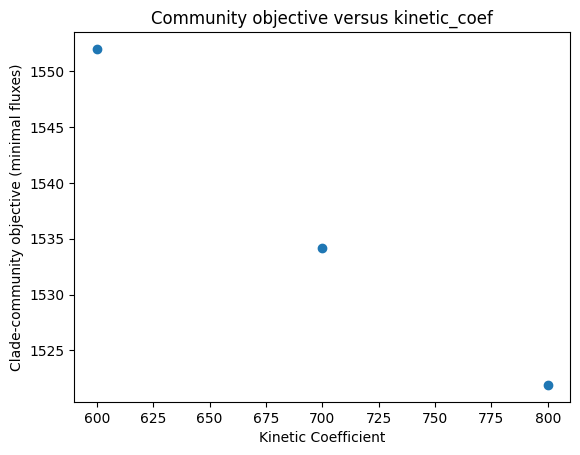

In [6]:
%run ../../ModelSEEDpy/modelseedpy/core/msprobability.py

from cobra.io import read_sbml_model
from numpy import linspace
from pandas import concat
from glob import glob

best_obj_val = 0
# coefs = linspace(450, 600, 4)
coefs = [600, 700, 800]
objs = []
fluxes_dfs = []
for coef in coefs:
    coef = int(coef)
    megaModels = [read_sbml_model(model) for model in glob("reaction_counts/*.xml")]
    prFBA_sol = MSProbability.prFBA(megaModels, printLP=True, kinetics_coef=coef)
    fluxes = prFBA_sol.fluxes
    fluxes_dfs.append(fluxes[abs(fluxes) > 1e-6].to_frame().rename(columns={"fluxes":f"{coef}_fluxes"},inplace=True))
    objs.append(prFBA_sol.objective_value)
    print(prFBA_sol.objective_value)

concat(fluxes_dfs).to_csv(f"CommKinetics_fluxes{coefs}.csv")

import matplotlib.pyplot as plt

x = [100, 400, 600, 800]
y = [0, 1923.5550077721484, 1551.997930179452, 1521.9042477678302]

plt.scatter(coefs, objs)
plt.title('Community objective versus kinetic_coef')
plt.xlabel('Kinetic Coefficient')
plt.ylabel('Clade-community objective (minimal fluxes)')
plt.savefig("clade-comm response versus kinetic_coef", format="jpg")

In [15]:
! cat "/Users/afreiburger/Library/Python/3.9/lib/python/site-packages/modelseedpy/fbapkg/commkineticpkg.py"

# -*- coding: utf-8 -*-

from __future__ import absolute_import

import logging
from modelseedpy.fbapkg.basefbapkg import BaseFBAPkg
from modelseedpy.core.fbahelper import FBAHelper

# Base class for FBA packages
class CommKineticPkg(BaseFBAPkg):
    def __init__(self, model):
        BaseFBAPkg.__init__(self, model, "community kinetics", {}, {"commkin": "string"})

    def build_package(self, kinetic_coef, community_model, rxn_coef=1):
        self.validate_parameters({}, [], {"kinetic_coef": kinetic_coef, "community": community_model})
        for member in self.parameters["community"].members:
            self.build_constraint(member, rxn_coef)

    def build_constraint(self, member, rxn_coef):
        bioRXN = member.primary_biomass
        coef = {bioRXN.forward_variable: -self.parameters["kinetic_coef"]}
        for reaction in self.model.reactions:
            if int(FBAHelper.rxn_compartment(reaction)[1:]) == member.index and reaction != bioRXN:
                coef[reaction.fo

In [ ]:
['cpd00001_c6', 'cpd00356_c6', 'cpd00012_c6', 'cpd00013_c6', 'cpd00067_c6', 'cpd00299_c6', 'cpd09878_e0', 'cpd00002_c6', 'cpd09878_c6', 'cpd00008_c6', 'cpd00009_c6', 'cpd00015_c5', 'cpd00067_c5', 'cpd00080_c5', 'cpd00095_c5', 'cpd00982_c5', 'cpd15753_c2', 'cpd00037_c2', 'cpd15771_c2', 'cpd00014_c2', 'cpd00208_e0', 'cpd01914_e0', 'cpd00022_c6', 'cpd00054_c6', 'cpd00010_c6', 'cpd00722_c6', 'cpd00064_e0', 'cpd00002_c2', 'cpd00013_c2', 'cpd00041_c2', 'cpd00012_c2', 'cpd00018_c2', 'cpd00067_c2', 'cpd00132_c2', 'cpd00013_c5', 'cpd00216_c5', 'cpd00001_c5', 'cpd00020_c5', 'cpd00093_c5', 'cpd00910_c6', 'cpd00108_c6', 'cpd00121_c6', 'cpd22027_c4', 'cpd00005_c4', 'cpd00067_c4', 'cpd22022_c4', 'cpd00006_c4', 'cpd00358_c6', 'cpd00367_c6', 'cpd00046_c6', 'cpd00978_c6', 'cpd00097_c2', 'cpd00383_c2', 'cpd00986_c2', 'cpd01716_c2', 'cpd00208_c6', 'cpd00027_c6', 'cpd00002_c5', 'cpd02775_c5', 'cpd00008_c5', 'cpd02894_c5', 'cpd00871_c6', 'cpd00011_c6', 'cpd00169_c6', 'cpd00002_c4', 'cpd00177_c4', 'cpd00008_c4', 'cpd00115_c4', 'cpd00007_c2', 'cpd03446_c2', 'cpd15359_c2', 'cpd00382_c6', 'cpd00076_c6', 'cpd00035_c5', 'cpd00117_c5', 'cpd00009_e0', 'cpd00971_e0', 'cpd00971_c6', 'cpd00408_c4', 'cpd00712_c4', 'cpd00006_c2', 'cpd00223_c2', 'cpd00145_c2', 'cpd00005_c2', 'cpd00159_c5', 'cpd15500_c5', 'cpd15499_c5', 'cpd00146_c6', 'cpd00089_c6', 'cpd00387_c6', 'cpd00847_c6', 'cpd00009_c2', 'cpd00032_c2', 'cpd00001_c2', 'cpd00011_c2', 'cpd00061_c2', 'cpd00268_c4', 'cpd00722_c4', 'cpd03456_c4', 'cpd00029_c4', 'cpd00012_c5', 'cpd02642_c5', 'cpd00103_c5', 'cpd08288_c6', 'cpd08301_c6', 'cpd00043_c6', 'cpd00091_c6', 'cpd00348_c6', 'cpd00241_c5', 'cpd00249_c5', 'cpd00091_c5', 'cpd00295_c5', 'cpd00020_c2', 'cpd00054_c2', 'cpd00035_c2', 'cpd15315_c4', 'cpd00001_c4', 'cpd00908_c4', 'cpd15298_c4', 'cpd00003_c4', 'cpd03607_c4', 'cpd00004_c4', 'cpd00011_c4', 'cpd08449_c4', 'cpd01329_c6', 'cpd15495_c6', 'cpd00018_c6', 'cpd00182_c6', 'cpd00341_c5', 'cpd00011_c5', 'cpd00118_c5', 'cpd00106_c2', 'cpd15353_c2', 'cpd00036_c2', 'cpd15352_c2', 'cpd00024_c4', 'cpd00107_c4', 'cpd00200_c4', 'cpd00023_c4', 'cpd00053_c5', 'cpd08210_c5', 'cpd00023_c5', 'cpd02572_c6', 'cpd02507_c6', 'cpd00029_c6', 'cpd00120_c6', 'cpd00211_c6', 'cpd00020_c6', 'cpd00199_c6', 'cpd03708_c6', 'cpd00658_c2', 'cpd00024_c2', 'cpd03451_c2', 'cpd11476_c4', 'cpd11477_c4', 'cpd12237_c5', 'cpd11420_c5', 'cpd14507_c5', 'cpd11421_c5', 'cpd00006_c6', 'cpd00223_c6', 'cpd00005_c6', 'cpd00843_c6', 'cpd11578_e0', 'cpd11578_c6', 'cpd11497_c4', 'cpd11498_c4', 'cpd00358_c5', 'cpd00367_c5', 'cpd00046_c5', 'cpd00978_c5', 'cpd00044_c2', 'cpd00193_c2', 'cpd00004_c6', 'cpd11509_c5', 'cpd11510_c5', 'cpd00355_c6', 'cpd02016_c6', 'cpd00072_c2', 'cpd00196_c2', 'cpd00236_c2', 'cpd00003_c5', 'cpd00199_c5', 'cpd00004_c5', 'cpd00036_c5', 'cpd00249_e0', 'cpd00067_e0', 'cpd00249_c2', 'cpd00822_c6', 'cpd00036_c6', 'cpd00094_c6', 'cpd11579_e0', 'cpd11579_c6', 'cpd00003_c2', 'cpd02147_c2', 'cpd00004_c2', 'cpd03606_c2', 'cpd00066_c4', 'cpd00143_c4', 'cpd00275_c5', 'cpd00434_c4', 'cpd00281_c4', 'cpd00210_e0', 'cpd00210_c6', 'cpd00008_c2', 'cpd11421_c2', 'cpd00177_c2', 'cpd11420_c2', 'cpd00357_c5', 'cpd00297_c5', 'cpd15414_c4', 'cpd00104_c4', 'cpd15352_c5', 'cpd15353_c5', 'cpd03217_c6', 'cpd03220_c6', 'cpd03048_e0', 'cpd03048_c6', 'cpd15361_c2', 'cpd15360_c2', 'cpd02978_c5', 'cpd02315_c5', 'cpd00421_c5', 'cpd15310_c4', 'cpd15525_c4', 'cpd00142_c6', 'cpd00279_c6', 'cpd00201_c2', 'cpd02394_c2', 'cpd00087_c2', 'cpd02678_c2', 'cpd00630_c5', 'cpd00078_c5', 'cpd01507_c5', 'cpd00104_e0', 'cpd00104_c5', 'cpd00009_c5', 'cpd02182_c4', 'cpd00042_c4', 'cpd00428_c4', 'cpd00092_c5', 'cpd00010_c4', 'cpd01080_c4', 'cpd00327_c4', 'cpd00012_c4', 'cpd00018_c4', 'cpd00413_c6', 'cpd00015_c6', 'cpd00650_c6', 'cpd00982_c6', 'cpd00478_c2', 'cpd00016_c2', 'cpd00025_c2', 'cpd00213_c5', 'cpd14702_c5', 'cpd00056_c5', 'cpd14703_c5', 'cpd11596_e0', 'cpd11596_c6', 'cpd00006_c5', 'cpd00005_c5', 'cpd00024_c5', 'cpd00956_c5', 'cpd02210_c5', 'cpd00210_c4', 'cpd00007_c4', 'cpd00036_c4', 'cpd00081_c4', 'cpd04122_c4', 'cpd00137_e0', 'cpd10516_e0', 'cpd00137_c6', 'cpd10516_c6', 'cpd00363_e0', 'cpd00344_c5', 'cpd00378_c5', 'cpd00017_c4', 'cpd02216_c4', 'cpd00019_c4', 'cpd02762_c4', 'cpd03196_c6', 'cpd00138_c6', 'cpd00338_c2', 'cpd02345_c2', 'cpd02566_c2', 'cpd21005_c5', 'cpd15560_c5', 'cpd14589_c5', 'cpd15561_c5', 'cpd00017_c5', 'cpd00800_c5', 'cpd00764_c5', 'cpd02701_c5', 'cpd00395_e0', 'cpd00395_c6', 'cpd00053_c2', 'cpd00216_c2', 'cpd00093_c2', 'cpd00023_c2', 'cpd00891_c5', 'cpd00519_c5', 'cpd11466_c4', 'cpd11467_c4', 'cpd00221_c5', 'cpd03198_c6', 'cpd15746_c2', 'cpd15764_c2', 'cpd00294_c4', 'cpd00009_c4', 'cpd00438_c4', 'cpd36025_c4', 'cpd19505_c4', 'cpd00254_c4', 'cpd00254_e0', 'cpd00113_c4', 'cpd17567_c4', 'cpd17568_c4', 'cpd00123_c5', 'cpd14700_c5', 'cpd00891_c6', 'cpd00078_c6', 'cpd11575_e0', 'cpd11575_c6', 'cpd08023_e0', 'cpd08023_c6', 'cpd00171_c2', 'cpd00198_c2', 'cpd11620_c4', 'cpd11621_c4', 'cpd00229_c5', 'cpd00139_c5', 'cpd00002_c3', 'cpd00297_c3', 'cpd00008_c3', 'cpd00357_c3', 'cpd15508_c5', 'cpd15507_c5', 'cpd01620_c3', 'cpd00003_c3', 'cpd03426_c3', 'cpd00004_c3', 'cpd00067_c3', 'cpd00001_c1', 'cpd00076_c1', 'cpd00027_c1', 'cpd00082_c1', 'cpd03918_c3', 'cpd03919_c3', 'cpd00024_c3', 'cpd00117_c3', 'cpd00020_c3', 'cpd00186_c3', 'cpd00532_c4', 'cpd00025_c4', 'cpd00012_c3', 'cpd00023_c3', 'cpd01982_c3', 'cpd00001_c3', 'cpd00053_c3', 'cpd00103_c3', 'cpd00002_c1', 'cpd00873_c1', 'cpd00012_c1', 'cpd00638_c1', 'cpd08288_c3', 'cpd00046_c3', 'cpd08301_c3', 'cpd00031_c3', 'cpd00038_c3', 'cpd15514_c5', 'cpd15510_c5', 'cpd15354_c4', 'cpd00080_c4', 'cpd15237_c4', 'cpd15352_c3', 'cpd15353_c3', 'cpd00130_c1', 'cpd15560_c1', 'cpd00032_c1', 'cpd15561_c1', 'cpd00264_e0', 'cpd00009_c3', 'cpd00264_c3', 'cpd03517_c4', 'cpd12847_c4', 'cpd12848_c4', 'cpd00533_c5', 'cpd00096_c5', 'cpd00017_c3', 'cpd03447_c3', 'cpd00019_c3', 'cpd03448_c3', 'cpd00214_c1', 'cpd15346_c1', 'cpd00018_c1', 'cpd00067_c1', 'cpd15538_c1', 'cpd16335_c3', 'cpd03451_c3', 'cpd00223_c5', 'cpd00145_c5', 'cpd00242_c1', 'cpd00011_c1', 'cpd00290_c3', 'cpd00095_c3', 'cpd00102_c3', 'cpd15302_c4', 'cpd00387_c4', 'cpd00155_c4', 'cpd00025_c1', 'cpd00007_c1', 'cpd03920_c3', 'cpd15323_c4', 'cpd02090_c4', 'cpd00136_c3', 'cpd00216_c3', 'cpd15339_c1', 'cpd15531_c1', 'cpd15506_c5', 'cpd00220_e0', 'cpd00220_c3', 'cpd00084_e0', 'cpd00084_c3', 'cpd00060_c4', 'cpd15306_c5', 'cpd15521_c5', 'cpd00045_c3', 'cpd00018_c3', 'cpd15500_c1', 'cpd15499_c1', 'cpd00047_c3', 'cpd00087_c3', 'cpd00201_c3', 'cpd00412_c4', 'cpd00299_c4', 'cpd00119_e0', 'cpd00119_c3', 'cpd15603_c4', 'cpd00033_c4', 'cpd00084_c4', 'cpd00305_e0', 'cpd00305_c3', 'cpd11310_c1', 'cpd02893_c1', 'cpd00322_e0', 'cpd00322_c5', 'cpd15330_c4', 'cpd02147_c3', 'cpd03606_c3', 'cpd00203_c1', 'cpd00009_c1', 'cpd00169_c1', 'cpd02904_c3', 'cpd03423_c3', 'cpd00264_c4', 'cpd00330_c5', 'cpd00393_c5', 'cpd00006_c3', 'cpd00773_c3', 'cpd00005_c3', 'cpd02820_c3', 'cpd02172_c4', 'cpd00136_c4', 'cpd02419_c4', 'cpd02698_c3', 'cpd02724_c3', 'cpd00003_c1', 'cpd03118_c1', 'cpd00004_c1', 'cpd03119_c1', 'cpd00052_c3', 'cpd08286_c3', 'cpd08287_c3', 'cpd09844_c1', 'cpd01507_c1', 'cpd00126_c3', 'cpd00166_c3', 'cpd02498_c5', 'cpd02569_c5', 'cpd15395_c4', 'cpd15531_c4', 'cpd11959_c4', 'cpd15339_c4', 'cpd00113_c3', 'cpd00202_c3', 'cpd00283_c3', 'cpd00223_c1', 'cpd00008_c1', 'cpd00482_c1', 'cpd00022_c4', 'cpd00449_c4', 'cpd00836_c4', 'cpd15521_c4', 'cpd00052_c4', 'cpd15417_c4', 'cpd02799_c5', 'cpd02597_c5', 'cpd00482_c3', 'cpd00061_c3', 'cpd01242_e0', 'cpd01242_c1', 'cpd11517_c4', 'cpd11518_c4', 'cpd01693_c1', 'cpd00079_c1', 'cpd00219_c6', 'cpd00868_c6', 'cpd15329_c5', 'cpd00327_c5', 'cpd00010_c5', 'cpd15526_c5', 'cpd11593_e0', 'cpd11593_c5', 'cpd00003_c6', 'cpd00403_c6', 'cpd00672_c6', 'cpd00114_c1', 'cpd00497_c1', 'cpd00239_c5', 'cpd00239_e0', 'cpd00164_c6', 'cpd03517_c5', 'cpd12847_c5', 'cpd00018_c5', 'cpd12848_c5', 'cpd00081_c5', 'cpd00081_e0', 'cpd00017_c6', 'cpd00033_c6', 'cpd00019_c6', 'cpd00183_c6', 'cpd11537_c5', 'cpd11538_c5', 'cpd00037_c1', 'cpd02782_c1', 'cpd00268_c5', 'cpd00268_e0', 'cpd15605_e0', 'cpd15605_c5', 'cpd00102_c5', 'cpd00203_c5', 'cpd05262_c6', 'cpd00437_c6', 'cpd15352_c4', 'cpd15353_c4', 'cpd00689_c5', 'cpd00755_c5', 'cpd11514_c4', 'cpd11515_c4', 'cpd02083_c5', 'cpd00060_c5', 'cpd00791_c5', 'cpd03091_c5', 'cpd00355_c1', 'cpd00029_c5', 'cpd00196_c5', 'cpd15553_c4', 'cpd15529_c4', 'cpd03428_c6', 'cpd11610_c6', 'cpd03431_c6', 'cpd11609_c6', 'cpd00103_c1', 'cpd00218_c1', 'cpd00041_e0', 'cpd00041_c5', 'cpd15336_c4', 'cpd01741_c4', 'cpd02375_c5', 'cpd00106_c5', 'cpd00020_c4', 'cpd00061_c4', 'cpd00026_c5', 'cpd00043_c5', 'cpd00196_c1', 'cpd00029_c1', 'cpd02295_c5', 'cpd02557_c5', 'cpd00635_c6', 'cpd00166_c6', 'cpd11472_c5', 'cpd11492_c5', 'cpd11490_c5', 'cpd11493_c5', 'cpd00276_e0', 'cpd00288_c4', 'cpd00048_e0', 'cpd00048_c1', 'cpd02021_c5', 'cpd15553_c5', 'cpd15529_c5', 'cpd00047_c1', 'cpd02333_c5', 'cpd03470_c5', 'cpd00061_c5', 'cpd00082_c6', 'cpd00115_c6', 'cpd00072_c6', 'cpd00177_c6', 'cpd00355_c5', 'cpd00873_c5', 'cpd03122_c1', 'cpd03123_c1', 'cpd00655_c4', 'cpd00215_e0', 'cpd00215_c5', 'cpd00288_c5', 'cpd15269_c1', 'cpd15342_c1', 'cpd15534_c1', 'cpd01679_c4', 'cpd00768_c4', 'cpd00069_c5', 'cpd00604_c5', 'cpd00655_c5', 'cpd11580_e0', 'cpd11580_c5', 'cpd00668_c6', 'cpd02569_c6', 'cpd00079_c6', 'cpd00911_c6', 'cpd00068_c4', 'cpd00114_c4', 'cpd11573_c5', 'cpd00068_c5', 'cpd00114_c5', 'cpd00284_c5', 'cpd02711_c5', 'cpd01775_c4', 'cpd00103_c4', 'cpd00055_c5', 'cpd00198_c5', 'cpd00157_c5', 'cpd01775_c5', 'cpd19030_c6', 'cpd19047_c6', 'cpd00498_c4', 'cpd10162_c4', 'cpd10515_c5', 'cpd10516_c5', 'cpd00498_c5', 'cpd10162_c5', 'cpd02197_c5', 'cpd00347_c5', 'cpd00107_e0', 'cpd00107_c6', 'cpd00774_c5', 'cpd11526_c5', 'cpd11527_c5', 'cpd11474_c6', 'cpd11475_c6', 'cpd00871_c5', 'cpd00169_c5', 'cpd00063_c5', 'cpd00063_e0', 'cpd00082_e0', 'cpd00802_c5', 'cpd11526_c4', 'cpd11527_c4', 'cpd00180_c6', 'cpd00047_c6', 'cpd00132_c5', 'cpd03385_c5', 'cpd11468_c6', 'cpd11469_c6', 'cpd00080_e0', 'cpd00196_c6', 'cpd00802_c4', 'cpd00183_c5', 'cpd00007_c5', 'cpd00025_c5', 'cpd00033_c5', 'cpd00006_c1', 'cpd00013_c1', 'cpd00005_c1', 'cpd00075_c1', 'cpd00867_c5', 'cpd00121_c5', 'cpd11514_c5', 'cpd11515_c5', 'cpd03449_c5', 'cpd00019_c5', 'cpd00342_c5', 'cpd00064_c5', 'cpd00241_c6', 'cpd00295_c6', 'cpd00811_c6', 'cpd00055_c6', 'cpd00425_c6', 'cpd00239_c6', 'cpd00081_c6', 'cpd02536_c1', 'cpd01630_c1', 'cpd15555_c4', 'cpd15499_c6', 'cpd00441_c6', 'cpd15500_c6', 'cpd02746_c1', 'cpd00113_c1', 'cpd02229_c1', 'cpd11421_c4', 'cpd11420_c4', 'cpd00041_c6', 'cpd00053_c6', 'cpd00023_c6', 'cpd00132_c6', 'cpd00309_c6', 'cpd04399_c6', 'cpd00007_c6', 'cpd15073_c6', 'cpd00441_e0', 'cpd11568_c1', 'cpd11569_c1', 'cpd00106_c4', 'cpd00142_c4', 'cpd00780_c4', 'cpd11420_c6', 'cpd11421_c6', 'cpd00010_c3', 'cpd15237_c3', 'cpd15238_c3', 'cpd00116_c6', 'cpd00342_c4', 'cpd00064_c4', 'cpd00025_c3', 'cpd00305_c6', 'cpd15606_c1', 'cpd00069_c1', 'cpd00033_c1', 'cpd15717_c4', 'cpd15723_c4', 'cpd00022_c3', 'cpd00227_c3', 'cpd00790_c3', 'cpd00238_c4', 'cpd04918_c4', 'cpd00797_c6', 'cpd00017_c2', 'cpd15561_c2', 'cpd00019_c2', 'cpd00011_c3', 'cpd00013_c3', 'cpd00146_c3', 'cpd08210_c6', 'cpd00443_c6', 'cpd11546_c1', 'cpd11547_c1', 'cpd00157_c3', 'cpd00076_e0', 'cpd01693_c2', 'cpd00064_c6', 'cpd00118_c6', 'cpd11539_c1', 'cpd11540_c1', 'cpd00705_c6', 'cpd00024_c6', 'cpd00269_c6', 'cpd12370_c3', 'cpd11493_c3', 'cpd01695_c4', 'cpd03114_c4', 'cpd15420_c1', 'cpd00080_c1', 'cpd15548_c1', 'cpd00046_c1', 'cpd00080_c3', 'cpd02522_c6', 'cpd04103_c6', 'cpd04104_c6', 'cpd00035_c3', 'cpd00890_c3', 'cpd00349_c6', 'cpd00238_c6', 'cpd00386_c4', 'cpd00120_c3', 'cpd00015_c3', 'cpd00650_c3', 'cpd00982_c3', 'cpd04111_c6', 'cpd00015_c1', 'cpd00129_c1', 'cpd02431_c1', 'cpd00982_c1', 'cpd00114_c3', 'cpd02884_c3', 'cpd03470_c6', 'cpd00169_c3', 'cpd00262_c4', 'cpd00592_c4', 'cpd15808_c6', 'cpd00782_c6', 'cpd11509_c4', 'cpd11510_c4', 'cpd11558_c1', 'cpd11559_c1', 'cpd11586_c3', 'cpd02656_c4', 'cpd00220_c4', 'cpd02882_c4', 'cpd15358_c1', 'cpd01080_c1', 'cpd00062_c3', 'cpd00129_c3', 'cpd02431_c3', 'cpd00035_c4', 'cpd00117_c4', 'cpd11468_c1', 'cpd11492_c1', 'cpd11491_c1', 'cpd11493_c1', 'cpd11310_c3', 'cpd02893_c3', 'cpd00039_c6', 'cpd15705_c2', 'cpd15681_c2', 'cpd11500_c5', 'cpd11501_c5', 'cpd00129_e0', 'cpd00129_c6', 'cpd03453_e0', 'cpd03726_e0', 'cpd00811_c4', 'cpd00441_c4', 'cpd11476_c6', 'cpd00134_c6', 'cpd11493_c6', 'cpd00242_c6', 'cpd00070_c6', 'cpd03422_c5', 'cpd03918_c5', 'cpd15306_c2', 'cpd15521_c2', 'cpd00363_c6', 'cpd00095_c2', 'cpd00157_c2', 'cpd00125_c6', 'cpd00347_c6', 'cpd00731_c6', 'cpd03490_c6', 'cpd02862_c6', 'cpd00220_c1', 'cpd00050_c1', 'cpd00071_c6', 'cpd00071_e0', 'cpd15703_c2', 'cpd15679_c2', 'cpd11640_c6', 'cpd11640_e0', 'cpd00091_c1', 'cpd00249_c1', 'cpd00434_c2', 'cpd00281_c2', 'cpd00260_c4', 'cpd00221_e0', 'cpd00221_c6', 'cpd09812_c4', 'cpd09813_c4', 'cpd00497_c6', 'cpd00126_c6', 'cpd15307_c2', 'cpd15522_c2', 'cpd00260_c6', 'cpd03187_c6', 'cpd11584_c2', 'cpd00119_c2', 'cpd00078_c1', 'cpd00449_c1', 'cpd00010_c1', 'cpd00860_c1', 'cpd00100_e0', 'cpd00100_c4', 'cpd00038_c6', 'cpd00957_c6', 'cpd02826_c6', 'cpd02140_c6', 'cpd00773_c5', 'cpd02820_c5', 'cpd15310_c2', 'cpd15525_c2', 'cpd00268_c6', 'cpd02857_c2', 'cpd27735_c4', 'cpd00193_c4', 'cpd28060_c4', 'cpd02197_c6', 'cpd00040_c4', 'cpd00843_c4', 'cpd00201_c6', 'cpd02851_c6', 'cpd00087_c6', 'cpd02884_c6', 'cpd00045_c2', 'cpd00048_c2', 'cpd00244_e0', 'cpd00244_c6', 'cpd00102_c2', 'cpd00227_c1', 'cpd00346_c1', 'cpd00971_c4', 'cpd11583_e0', 'cpd11583_c6', 'cpd00135_c6', 'cpd00064_c2', 'cpd00129_c2', 'cpd00024_e0', 'cpd08289_c2', 'cpd00284_c6', 'cpd00171_c6', 'cpd15556_c5', 'cpd15532_c5', 'cpd02524_c5', 'cpd02666_c5', 'cpd00349_c2', 'cpd08021_c4', 'cpd15499_c4', 'cpd00450_c4', 'cpd15500_c4', 'cpd02826_c2', 'cpd02446_c6', 'cpd02721_c6', 'cpd00106_e0', 'cpd00106_c6', 'cpd00044_c6', 'cpd00045_c6', 'cpd00010_c2', 'cpd00050_c2', 'cpd00022_c2', 'cpd01270_c2', 'cpd00506_c6', 'cpd00042_c6', 'cpd15690_c2', 'cpd15696_c2', 'cpd00911_c4', 'cpd00284_c4', 'cpd00790_c6', 'cpd00096_c6', 'cpd03518_c6', 'cpd03519_c6', 'cpd03470_c2', 'cpd00084_c6', 'cpd08021_e0', 'cpd00450_e0', 'cpd00001_e0', 'cpd02557_c6', 'cpd02590_c6', 'cpd00113_c6', 'cpd00130_c6', 'cpd11830_c2', 'cpd12225_c2', 'cpd00125_c2', 'cpd00238_c2', 'cpd02685_c6', 'cpd03289_c6', 'cpd01217_c6', 'cpd15540_c6', 'cpd15793_c6', 'cpd00100_c6', 'cpd00159_c1', 'cpd00020_c1', 'cpd00060_c2', 'cpd00324_c2', 'cpd00094_c2', 'cpd00292_c4', 'cpd00279_c4', 'cpd00034_c5', 'cpd00205_e0', 'cpd00034_e0', 'cpd00205_c5', 'cpd00794_e0', 'cpd00523_c2', 'cpd11492_c6', 'cpd11489_c6', 'cpd11483_c6', 'cpd11471_c6', 'cpd00171_c4', 'cpd00908_c1', 'cpd08023_c2', 'cpd00054_c4', 'cpd00738_c4', 'cpd02465_c6', 'cpd11506_c6', 'cpd11507_c6', 'cpd00061_c6', 'cpd02030_c6', 'cpd00932_c6', 'cpd11521_c1', 'cpd11522_c1', 'cpd00079_c2', 'cpd00055_c2', 'cpd00081_c2', 'cpd03116_c6', 'cpd02060_c6', 'cpd03118_c6', 'cpd03129_c6', 'cpd00817_c6', 'cpd00346_c6', 'cpd02120_c6', 'cpd00069_c6', 'cpd00604_c6', 'cpd03671_c2', 'cpd00812_c4', 'cpd17039_c4', 'cpd03002_c6', 'cpd02993_c6', 'cpd14698_c1', 'cpd00213_c1', 'cpd14699_c1', 'cpd00056_c1', 'cpd00282_c2', 'cpd00247_c2', 'cpd00024_c1', 'cpd00342_c1', 'cpd00918_c1', 'cpd00023_c1', 'cpd01501_c6', 'cpd02597_c6', 'cpd02730_c6', 'cpd00154_e0', 'cpd00154_c6', 'cpd10515_c3', 'cpd10516_c3', 'cpd00246_e0', 'cpd00048_c6', 'cpd00122_c1', 'cpd00492_c1', 'cpd00051_e0', 'cpd00117_c6', 'cpd00186_c6', 'cpd00214_c6', 'cpd00075_e0', 'cpd00649_c1', 'cpd02679_c1', 'cpd00792_c1', 'cpd02655_c1', 'cpd00438_e0', 'cpd00136_c6', 'cpd00216_c6', 'cpd00764_c1', 'cpd01311_c1', 'cpd00644_e0', 'cpd00007_c3', 'cpd00041_c3', 'cpd03470_c3', 'cpd00040_c6', 'cpd00039_e0', 'cpd00424_c1', 'cpd00084_c1', 'cpd00094_c1', 'cpd00738_c6', 'cpd15514_c3', 'cpd15510_c3', 'cpd00035_e0', 'cpd00062_c6', 'cpd03116_c1', 'cpd03117_c1', 'cpd00533_c3', 'cpd11420_c3', 'cpd00096_c3', 'cpd11421_c3', 'cpd00184_e0', 'cpd00030_e0', 'cpd00030_c6', 'cpd01293_c1', 'cpd00209_e0', 'cpd00223_c3', 'cpd00145_c3', 'cpd00289_c6', 'cpd02591_c6', 'cpd00033_e0', 'cpd00504_c1', 'cpd02465_c1', 'cpd01017_c6', 'cpd15306_c3', 'cpd15521_c3', 'cpd00367_e0', 'cpd00906_c6', 'cpd00268_c1', 'cpd00322_c3', 'cpd00128_e0', 'cpd00101_c6', 'cpd00307_c6', 'cpd02843_c1', 'cpd00930_c1', 'cpd02893_c6', 'cpd01669_c3', 'cpd00362_c3', 'cpd00048_c3', 'cpd00085_c6', 'cpd15683_c3', 'cpd15716_c3', 'cpd00465_c3', 'cpd00596_c3', 'cpd00408_c6', 'cpd00712_c6', 'cpd00105_c1', 'cpd00105_e0', 'cpd15268_c3', 'cpd15329_c3', 'cpd00330_c3', 'cpd00393_c3', 'cpd00393_c6', 'cpd00099_e0', 'cpd00099_c6', 'cpd02498_c3', 'cpd02569_c3', 'cpd01262_e0', 'cpd01262_c3', 'cpd00132_e0', 'cpd00382_c1', 'cpd03198_c1', 'cpd11498_c3', 'cpd11499_c3', 'cpd00179_e0', 'cpd00179_c3', 'cpd11466_c3', 'cpd11492_c3', 'cpd11485_c3', 'cpd00731_e0', 'cpd10515_e0', 'cpd00075_c6', 'cpd02661_c1', 'cpd00521_c1', 'cpd03115_c3', 'cpd03127_c3', 'cpd00246_c6', 'cpd00475_c6', 'cpd00226_c6', 'cpd01329_e0', 'cpd01329_c3', 'cpd00447_c6', 'cpd00540_c6', 'cpd00207_c1', 'cpd00309_c1', 'cpd00299_c3', 'cpd00412_c3', 'cpd08615_c3', 'cpd00268_c3', 'cpd00722_c3', 'cpd00029_c3', 'cpd00081_c3', 'cpd15671_c6', 'cpd11432_c6', 'cpd15677_c6', 'cpd00858_c3', 'cpd02097_c3', 'cpd00038_c1', 'cpd03518_c1', 'cpd11590_c3', 'cpd00060_c3', 'cpd00207_c3', 'cpd01982_c2', 'cpd00103_c2', 'cpd00626_c3', 'cpd00521_c3', 'cpd01260_c3', 'cpd02060_c3', 'cpd00051_c5', 'cpd00152_c5', 'cpd00599_c3', 'cpd00077_c3', 'cpd00282_c3', 'cpd15500_c3', 'cpd00247_c3', 'cpd15499_c3', 'cpd00200_c5', 'cpd14698_c5', 'cpd15557_c3', 'cpd15533_c3', 'cpd00400_c5', 'cpd01150_c5', 'cpd02691_c3', 'cpd02124_c3', 'cpd00842_c3', 'cpd00279_c3', 'cpd15684_c4', 'cpd00046_c4', 'cpd00062_c5', 'cpd00014_c5', 'cpd08366_c5', 'cpd00760_c3', 'cpd02125_c3', 'cpd00286_c3', 'cpd02862_c3', 'cpd02948_c3', 'cpd00091_c3', 'cpd15680_c4', 'cpd15686_c4', 'cpd00048_c4', 'cpd02857_c3', 'cpd00699_c3', 'cpd00388_c3', 'cpd00073_c3', 'cpd02536_c3', 'cpd01630_c3', 'cpd00115_c5', 'cpd00177_c5', 'cpd08288_c2', 'cpd08301_c2', 'cpd00046_c2', 'cpd00331_c4', 'cpd00038_c5', 'cpd00031_c5', 'cpd00242_c3', 'cpd00032_c3', 'cpd00309_c3', 'cpd00300_c3', 'cpd11468_c3', 'cpd11469_c3', 'cpd02799_c3', 'cpd00036_c3', 'cpd00296_c5', 'cpd00058_e0', 'cpd00058_c3', 'cpd00609_c3', 'cpd02439_c3', 'cpd11519_c4', 'cpd02233_c5', 'cpd02024_c5', 'cpd03915_c3', 'cpd00421_c3', 'cpd03916_c3', 'cpd00142_c3', 'cpd00178_c3', 'cpd11217_c5', 'cpd02152_c3', 'cpd00051_c3', 'cpd00106_c3', 'cpd00837_c4', 'cpd00118_c4', 'cpd00147_c4', 'cpd00424_c5', 'cpd00084_c5', 'cpd00094_c5', 'cpd00807_c3', 'cpd00641_c3', 'cpd00184_c3', 'cpd00151_c3', 'cpd00509_c3', 'cpd11436_c4', 'cpd11437_c4', 'cpd00461_c3', 'cpd02731_c3', 'cpd03812_c4', 'cpd03813_c4', 'cpd00919_c3', 'cpd02483_c3', 'cpd00311_c3', 'cpd00515_c3', 'cpd00126_c5', 'cpd15687_c3', 'cpd00054_c3', 'cpd15693_c3', 'cpd02961_c5', 'cpd03521_c5', 'cpd00022_c1', 'cpd00123_c1', 'cpd00712_c1', 'cpd00895_c1', 'cpd03120_c1', 'cpd03121_c1', 'cpd00128_c5', 'cpd02211_c1', 'cpd00136_c5', 'cpd15366_c2', 'cpd15569_c2', 'cpd00616_c1', 'cpd03607_c1', 'cpd08449_c1', 'cpd00443_c5', 'cpd00102_c1', 'cpd22830_c1', 'cpd00171_c5', 'cpd00016_c5', 'cpd11620_c1', 'cpd11621_c1', 'cpd00858_c5', 'cpd27484_c1', 'cpd26672_c1', 'cpd00045_c1', 'cpd00081_c1', 'cpd27735_c1', 'cpd00044_c1', 'cpd28060_c1', 'cpd02851_c5', 'cpd02506_c5', 'cpd21083_c1', 'cpd14866_c1', 'cpd00147_c5', 'cpd01981_c5', 'cpd14865_c1', 'cpd21082_c1', 'cpd02227_c5', 'cpd00282_c5', 'cpd00247_c5', 'cpd21041_c1', 'cpd00022_c5', 'cpd00449_c5', 'cpd00836_c5', 'cpd27758_c1', 'cpd08615_c1', 'cpd28083_c1', 'cpd08301_c1', 'cpd00289_c2', 'cpd02168_c2', 'cpd17278_c1', 'cpd00017_c1', 'cpd00060_c1', 'cpd03091_c1', 'cpd17281_c1', 'cpd31852_c1', 'cpd32612_c1', 'cpd24820_c1', 'cpd21005_c1', 'cpd14589_c1', 'cpd00097_c5', 'cpd00071_c5', 'cpd00986_c5', 'cpd15481_c1', 'cpd15480_c1', 'cpd00177_c1', 'cpd32711_c1', 'cpd24823_c1', 'cpd00106_c1', 'cpd00804_c1', 'cpd00510_c3', 'cpd01242_c3', 'cpd00082_c2', 'cpd03724_e0', 'cpd03724_c3', 'cpd07923_c2', 'cpd07924_c2', 'cpd00082_c3', 'cpd00072_c3', 'cpd00311_c5', 'cpd00834_c1', 'cpd00655_c1', 'cpd08632_c4', 'cpd08631_c4', 'cpd11498_c5', 'cpd11499_c5', 'cpd00460_c1', 'cpd15810_c1', 'cpd01260_c5', 'cpd02060_c5', 'cpd00518_c3', 'cpd11209_c4', 'cpd00274_c4', 'cpd00096_c1', 'cpd00533_c1', 'cpd00231_c2', 'cpd00233_c2', 'cpd15371_c2', 'cpd15572_c2', 'cpd11466_c5', 'cpd11485_c5', 'cpd11560_c1', 'cpd11561_c1', 'cpd00423_e0', 'cpd00423_c3', 'cpd28070_c4', 'cpd33817_c4', 'cpd27744_c4', 'cpd00421_c4', 'cpd03918_c4', 'cpd00210_c1', 'cpd00109_c1', 'cpd00110_c1', 'cpd31335_c2', 'cpd31339_c2', 'cpd15557_c5', 'cpd15533_c5', 'cpd15904_c1', 'cpd02246_c1', 'cpd03706_c3', 'cpd19503_c4', 'cpd21288_c4', 'cpd00395_c1', 'cpd00540_e0', 'cpd00540_c3', 'cpd36635_c4', 'cpd11492_c4', 'cpd11493_c4', 'cpd00095_c1', 'cpd02611_c1', 'cpd15752_c2', 'cpd15770_c2', 'cpd02233_e0', 'cpd11479_c5', 'cpd11473_c5', 'cpd00071_c3', 'cpd02258_c3', 'cpd22028_c4', 'cpd22065_c4', 'cpd00842_c5', 'cpd00279_c5', 'cpd00782_c1', 'cpd04111_c1', 'cpd00794_c2', 'cpd00027_c2', 'cpd00501_c2', 'cpd02524_c2', 'cpd02666_c2', 'cpd00666_c3', 'cpd00268_c2', 'cpd00286_c5', 'cpd02862_c5', 'cpd02948_c5', 'cpd00349_c1', 'cpd00236_c1', 'cpd02089_c1', 'cpd00379_c1', 'cpd01644_c3', 'cpd02183_c3', 'cpd00014_c1', 'cpd00971_c2', 'cpd00190_c1', 'cpd00170_c1', 'cpd01007_c3', 'cpd00127_c3', 'cpd02857_c5', 'cpd00699_c5', 'cpd00332_c1', 'cpd00812_c1', 'cpd00031_c1', 'cpd00012_e0', 'cpd19047_c4', 'cpd00060_e0', 'cpd00107_c1', 'cpd11571_c2', 'cpd11572_c2', 'cpd03115_c5', 'cpd03127_c5', 'cpd00121_c1', 'cpd00524_c1', 'cpd00863_c1', 'cpd00072_c1', 'cpd00242_c5', 'cpd00032_c5', 'cpd02720_c1', 'cpd02882_c1', 'cpd00286_c2', 'cpd00946_c2', 'cpd00091_c2', 'cpd03189_c2', 'cpd00213_c2', 'cpd00860_c2', 'cpd00056_c2', 'cpd03487_c1', 'cpd03488_c1', 'cpd12225_c3', 'cpd12005_c3', 'cpd11468_c5', 'cpd11469_c5', 'cpd00065_e0', 'cpd00065_c1', 'cpd00978_c2', 'cpd00358_c2', 'cpd00338_c1', 'cpd00689_c1', 'cpd15748_c2', 'cpd15766_c2', 'cpd00635_c4', 'cpd00166_c4', 'cpd00058_c5', 'cpd00299_c5', 'cpd00412_c5', 'cpd12543_c1', 'cpd00070_c1', 'cpd12848_c1', 'cpd00175_c1', 'cpd03915_c5', 'cpd03916_c5', 'cpd15809_c1', 'cpd15889_c1', 'cpd15754_c2', 'cpd15772_c2', 'cpd11590_c5', 'cpd00125_c5', 'cpd00087_c5', 'cpd00054_c5', 'cpd00202_c1', 'cpd21032_c4', 'cpd00013_c4', 'cpd00090_c2', 'cpd00068_c2', 'cpd00125_c1', 'cpd00299_c1', 'cpd00087_c1', 'cpd00298_c1', 'cpd00620_c2', 'cpd00834_c2', 'cpd11550_c5', 'cpd11551_c5', 'cpd00292_c1', 'cpd00279_c1', 'cpd00137_c2', 'cpd00029_c2', 'cpd02371_c3', 'cpd02152_c5', 'cpd15543_c5', 'cpd15536_c5', 'cpd00413_c1', 'cpd15747_c2', 'cpd15765_c2', 'cpd00452_c4', 'cpd21301_c4', 'cpd00822_c4', 'cpd19019_c4', 'cpd00334_c3', 'cpd00159_c3', 'cpd00078_c4', 'cpd00807_c5', 'cpd00641_c5', 'cpd11580_c1', 'cpd00053_c1', 'cpd00158_c3', 'cpd00027_c3', 'cpd00039_c1', 'cpd02074_c1', 'cpd15751_c2', 'cpd15769_c2', 'cpd15687_c5', 'cpd15693_c5', 'cpd11552_c1', 'cpd11553_c1', 'cpd15585_c3', 'cpd00116_c3', 'cpd06707_c1', 'cpd00153_c1', 'cpd00322_c1', 'cpd00976_c2', 'cpd00977_c2', 'cpd15584_c3', 'cpd00626_c5', 'cpd00521_c5', 'cpd00804_c6', 'cpd00025_c6', 'cpd00111_c6', 'cpd00327_c6', 'cpd01080_c6', 'cpd15526_c2', 'cpd00052_c2', 'cpd15421_c2', 'cpd11587_c4', 'cpd00053_c4', 'cpd15542_c6', 'cpd15535_c6', 'cpd00156_c4', 'cpd00123_c4', 'cpd11480_c4', 'cpd11489_c4', 'cpd02089_c6', 'cpd00379_c6', 'cpd00179_c4', 'cpd00630_c4', 'cpd01507_c4', 'cpd15543_c4', 'cpd15536_c4', 'cpd00339_c6', 'cpd08630_c4', 'cpd00549_c6', 'cpd00047_c5', 'cpd31161_c6', 'cpd02824_c6', 'cpd00216_c4', 'cpd00093_c4', 'cpd15511_c6', 'cpd15513_c6', 'cpd00051_c4', 'cpd00152_c4', 'cpd15398_c6', 'cpd15397_c6', 'cpd01335_c6', 'cpd03846_c6', 'cpd02979_c2', 'cpd02991_c2', 'cpd15504_c6', 'cpd15501_c6', 'cpd03519_c2', 'cpd03666_c2', 'cpd00038_c4', 'cpd00047_c4', 'cpd02978_c4', 'cpd00193_c6', 'cpd00924_c6', 'cpd15498_c4', 'cpd15502_c6', 'cpd15349_c4', 'cpd15269_c4', 'cpd15325_c6', 'cpd01741_c6', 'cpd00080_c6', 'cpd00264_c6', 'cpd11468_c4', 'cpd15325_c4', 'cpd11451_e0', 'cpd11606_e0', 'cpd11479_c4', 'cpd11473_c4', 'cpd03372_c6', 'cpd03287_c6', 'cpd11525_c4', 'cpd02483_c6', 'cpd15684_c2', 'cpd00854_c4', 'cpd02828_c4', 'cpd00873_c4', 'cpd00638_c4', 'cpd01792_c6', 'cpd01882_c4', 'cpd00015_c4', 'cpd01966_c4', 'cpd00982_c4', 'cpd00480_c6', 'cpd03860_c6', 'cpd11478_c4', 'cpd11488_c4', 'cpd00120_c4', 'cpd00211_c4', 'cpd00031_c4', 'cpd00222_c6', 'cpd02835_c4', 'cpd02930_c4', 'cpd00014_c4', 'cpd03002_c4', 'cpd00957_c4', 'cpd00931_c4', 'cpd11591_c2', 'cpd00033_c2', 'cpd12370_c2', 'cpd11493_c2', 'cpd08630_c5', 'cpd08631_c5', 'cpd00292_c2', 'cpd00279_c2', 'cpd02140_c5', 'cpd02893_c5', 'cpd00037_c6', 'cpd00492_c6', 'cpd00014_c6', 'cpd00332_c2', 'cpd14720_c5', 'cpd02535_c1', 'cpd10162_c1', 'cpd00107_c2', 'cpd00200_c2', 'cpd15401_c6', 'cpd15387_c6', 'cpd15399_c6', 'cpd16034_c6', 'cpd10515_c6', 'cpd00557_c6', 'cpd00102_c4', 'cpd00203_c4', 'cpd00220_c5', 'cpd00050_c5', 'cpd00938_c6', 'cpd02255_c6', 'cpd08615_c5', 'cpd00202_c5', 'cpd00830_c5', 'cpd00040_c5', 'cpd11548_c6', 'cpd11549_c6', 'cpd11476_c2', 'cpd11477_c2', 'cpd00031_c2', 'cpd00038_c2', 'cpd01620_c5', 'cpd03426_c5', 'cpd03725_e0', 'cpd03725_c6', 'cpd00297_c6', 'cpd00357_c6', 'cpd00288_c1', 'cpd11497_c2', 'cpd11498_c2', 'cpd03919_c5', 'cpd00867_c4', 'cpd00121_c4', 'cpd00424_c6', 'cpd00497_c2', 'cpd00126_c2', 'cpd00438_c1', 'cpd00383_c5', 'cpd01716_c5', 'cpd00201_c5', 'cpd01133_c6', 'cpd00264_c2', 'cpd00264_c5', 'cpd00345_c6', 'cpd03197_c6', 'cpd15606_e0', 'cpd15606_c5', 'cpd02835_c2', 'cpd02930_c2', 'cpd03002_c2', 'cpd00282_c4', 'cpd00247_c4', 'cpd15547_c5', 'cpd15540_c5', 'cpd11466_c2', 'cpd11467_c2', 'cpd03447_c5', 'cpd03448_c5', 'cpd03122_c6', 'cpd03123_c6', 'cpd01777_c1', 'cpd02979_c1', 'cpd03447_c2', 'cpd03448_c2', 'cpd16335_c5', 'cpd03451_c5', 'cpd11583_c5', 'cpd08615_c6', 'cpd00015_c2', 'cpd15237_c2', 'cpd00982_c2', 'cpd11537_c4', 'cpd11538_c4', 'cpd00932_c5', 'cpd00086_c6', 'cpd02124_c6', 'cpd03195_c6', 'cpd00588_c6', 'cpd02711_c1', 'cpd11589_e0', 'cpd11589_c5', 'cpd00254_c2', 'cpd16335_c2', 'cpd03920_c5', 'cpd15337_c1', 'cpd03847_c1', 'cpd00039_c2', 'cpd08629_c5', 'cpd15560_c6', 'cpd15561_c6', 'cpd00294_c2', 'cpd00438_c2', 'cpd00073_e0', 'cpd00073_c4', 'cpd03200_c6', 'cpd00508_c1', 'cpd03919_c2', 'cpd03920_c2', 'cpd00485_c5', 'cpd00083_c5', 'cpd15421_c5', 'cpd00156_c6', 'cpd00123_c6', 'cpd00367_c4', 'cpd27484_c6', 'cpd26672_c6', 'cpd00034_c1', 'cpd00699_c6', 'cpd01716_c6', 'cpd19019_c6', 'cpd15557_c4', 'cpd15533_c4', 'cpd11534_c1', 'cpd11535_c1', 'cpd00220_c2', 'cpd00023_e0', 'cpd00260_c2', 'cpd00331_c2', 'cpd00233_c1', 'cpd00066_c1', 'cpd00231_c1', 'cpd00084_c2', 'cpd11588_e0', 'cpd11588_c5', 'cpd11531_c6', 'cpd11532_c6', 'cpd00724_c6', 'cpd03113_c1', 'cpd03126_c1', 'cpd02611_c2', 'cpd00841_c2', 'cpd00113_c2', 'cpd00842_c4', 'cpd01982_c5', 'cpd02394_c5', 'cpd11582_c1', 'cpd00161_c1', 'cpd00035_c1', 'cpd19001_c6', 'cpd00115_c1', 'cpd00126_c1', 'cpd00080_c2', 'cpd15547_c2', 'cpd15604_e0', 'cpd15604_c5', 'cpd00305_c5', 'cpd11518_c2', 'cpd11519_c2', 'cpd02978_c6', 'cpd03521_c6', 'cpd11589_c6', 'cpd11225_c1', 'cpd02656_c1', 'cpd00812_c2', 'cpd00090_c5', 'cpd00638_c5', 'cpd02386_c6', 'cpd00229_c6', 'cpd01845_c5', 'cpd11490_c6', 'cpd01399_c6', 'cpd02857_c4', 'cpd00699_c4', 'cpd15294_c6', 'cpd15330_c6', 'cpd00161_c2', 'cpd02211_c2', 'cpd00286_c4', 'cpd02862_c4', 'cpd02948_c4', 'cpd00091_c4', 'cpd00175_c6', 'cpd00026_c6', 'cpd11459_c6', 'cpd15808_c1', 'cpd15829_c1', 'cpd00029_e0', 'cpd15827_c1', 'cpd00054_c1', 'cpd00062_c1', 'cpd00026_c2', 'cpd00043_c2', 'cpd15509_c6', 'cpd00054_e0', 'cpd00322_c2', 'cpd04103_c1', 'cpd04104_c1', 'cpd02187_c3', 'cpd03572_c3', 'cpd00425_c2', 'cpd02246_c2', 'cpd02438_c2', 'cpd15895_c2', 'cpd02835_c3', 'cpd03584_c3', 'cpd11484_c3', 'cpd01669_c6', 'cpd00362_c6', 'cpd11481_c2', 'cpd11485_c2', 'cpd00193_c1', 'cpd00116_c2', 'cpd11529_c5', 'cpd11530_c5', 'cpd00041_c1', 'cpd03470_c1', 'cpd01017_c3', 'cpd00033_c3', 'cpd15505_c6', 'cpd00289_c1', 'cpd02797_c1', 'cpd00180_c1', 'cpd15557_c2', 'cpd02625_c2', 'cpd01974_c2', 'cpd00089_c1', 'cpd15510_c6', 'cpd00841_c1', 'cpd00811_c2', 'cpd00078_c2', 'cpd15828_c1', 'cpd02817_c1', 'cpd00485_c3', 'cpd00083_c3', 'cpd02484_c1', 'cpd02065_c2', 'cpd00483_c2', 'cpd00231_c3', 'cpd00233_c3', 'cpd00374_c1', 'cpd00275_c2', 'cpd00339_c1', 'cpd02678_c3', 'cpd02394_c3', 'cpd00347_c3', 'cpd00441_c2', 'cpd00092_c1', 'cpd00475_c1', 'cpd02692_c2', 'cpd00868_c1', 'cpd15839_c1', 'cpd02535_c3', 'cpd00508_c3', 'cpd02824_c1', 'cpd01749_c2', 'cpd00047_c2', 'cpd15692_c3', 'cpd15698_c3', 'cpd00065_c2', 'cpd11593_c3', 'cpd03118_c3', 'cpd03119_c3', 'cpd01048_c6', 'cpd04098_c6', 'cpd00516_c3', 'cpd00039_c3', 'cpd00393_e0', 'cpd00393_c1', 'cpd03449_c3', 'cpd00100_c3', 'cpd03443_c3', 'cpd03444_c3', 'cpd00149_e0', 'cpd00149_c4', 'cpd00873_c3', 'cpd00218_c3', 'cpd00497_c3', 'cpd01217_c1', 'cpd00078_c3', 'cpd00338_c3', 'cpd00642_c1', 'cpd00831_c1', 'cpd00026_c4', 'cpd00079_c4', 'cpd00523_c4', 'cpd00658_c3', 'cpd01997_c3', 'cpd00062_c4', 'cpd02611_c4', 'cpd00037_c4', 'cpd15341_c1', 'cpd00557_c3', 'cpd01329_c4', 'cpd00216_c1', 'cpd00219_c1', 'cpd00182_c3', 'cpd03445_c3', 'cpd00774_c3', 'cpd02698_c4', 'cpd02724_c4', 'cpd08286_c4', 'cpd08287_c4', 'cpd01772_c3', 'cpd02021_c3', 'cpd00101_c1', 'cpd00171_c1', 'cpd00793_c3', 'cpd00030_c4', 'cpd00383_c1', 'cpd01716_c1', 'cpd02229_c3', 'cpd00191_c4', 'cpd08210_c4', 'cpd00443_c4', 'cpd02930_c3', 'cpd00338_c4', 'cpd00298_c3', 'cpd00041_c4', 'cpd03470_c4', 'cpd11474_c1', 'cpd11475_c1', 'cpd00014_c3', 'cpd00016_c4', 'cpd00099_c3', 'cpd00774_c4', 'cpd01620_c4', 'cpd11461_c3', 'cpd11463_c3', 'cpd11462_c3', 'cpd00205_c3', 'cpd00254_c3', 'cpd00063_c3', 'cpd00149_c3', 'cpd00030_c3', 'cpd00034_c3', 'cpd00016_c3', 'cpd00345_c3', 'cpd00042_c3', 'cpd00028_c3', 'cpd00118_c3', 'cpd00056_c3', 'cpd15560_c3', 'cpd15793_c3', 'cpd15540_c3', 'cpd03736_c3', 'cpd15665_c3', 'cpd11416_c3', 'cpd03422_c3', 'cpd15666_c3', 'cpd00305_c4', 'cpd00793_c4', 'cpd00654_e0', 'cpd00654_c1', 'cpd00069_e0', 'cpd00061_c1', 'cpd01030_e0', 'cpd01973_c1', 'cpd00762_c1', 'cpd15329_c1', 'cpd11582_e0', 'cpd11441_c4', 'cpd15676_c4', 'cpd15682_c4', 'cpd02394_c1', 'cpd02678_c1', 'cpd11481_c4', 'cpd00199_c4', 'cpd01171_e0', 'cpd03752_c1', 'cpd00032_c6', 'cpd15892_c1', 'cpd00658_c4', 'cpd03451_c4', 'cpd00541_c1', 'cpd14955_c1', 'cpd20413_c1', 'cpd20412_c1', 'cpd20411_c1', 'cpd00965_c4', 'cpd00531_c4', 'cpd00128_c1', 'cpd03525_c4', 'cpd01977_c6', 'cpd01982_c1', 'cpd00419_c4', 'cpd00493_c4', 'cpd11568_c6', 'cpd11569_c6', 'cpd08288_c1', 'cpd18042_c1', 'cpd22795_c1', 'cpd00095_c4', 'cpd15606_c6', 'cpd24817_c1', 'cpd10515_c4', 'cpd15366_c1', 'cpd15569_c1', 'cpd00550_c4', 'cpd11539_c6', 'cpd11540_c6', 'cpd00072_c4', 'cpd00290_c4', 'cpd24818_c1', 'cpd03116_c4', 'cpd03117_c4', 'cpd00053_e0', 'cpd00052_c1', 'cpd00215_c4', 'cpd11591_e0', 'cpd11591_c6', 'cpd02168_c1', 'cpd31161_c1', 'cpd35985_c1', 'cpd00161_c4', 'cpd00071_c4', 'cpd02851_c4', 'cpd02884_c4', 'cpd11491_c6', 'cpd15277_c1', 'cpd15327_c1', 'cpd15524_c1', 'cpd34057_c1', 'cpd31636_c1', 'cpd00201_c4', 'cpd00087_c4', 'cpd00731_c4', 'cpd15537_c4', 'cpd15345_c4', 'cpd34826_c1', 'cpd15554_c4', 'cpd15530_c4', 'cpd23146_c1', 'cpd02465_c4', 'cpd02120_c4', 'cpd15526_c1', 'cpd15421_c1', 'cpd00282_c6', 'cpd00343_c6', 'cpd00350_c4', 'cpd02590_c4', 'cpd02991_c1', 'cpd34482_c1', 'cpd11432_c4', 'cpd15671_c4', 'cpd15677_c4', 'cpd00295_c4', 'cpd15688_c1', 'cpd15721_c1', 'cpd15423_c4', 'cpd15277_c4', 'cpd15327_c4', 'cpd15524_c4', 'cpd11481_c1', 'cpd11485_c1', 'cpd00135_c4', 'cpd00182_c4', 'cpd11439_c4', 'cpd15675_c4', 'cpd15681_c4', 'cpd00449_c6', 'cpd00860_c6', 'cpd00118_e0', 'cpd00249_c6', 'cpd00227_c6', 'cpd11435_c4', 'cpd15673_c4', 'cpd15679_c4', 'cpd00293_c1', 'cpd00213_c4', 'cpd00101_c4', 'cpd00198_c4', 'cpd15239_c4', 'cpd15326_c4', 'cpd00342_c6', 'cpd00918_c6', 'cpd11434_c4', 'cpd15672_c4', 'cpd15678_c4', 'cpd00036_c1', 'cpd11585_e0', 'cpd11585_c1', 'cpd00113_c5', 'cpd00350_c5', 'cpd02229_c5', 'cpd02097_c5', 'cpd15421_c6', 'cpd15557_c6', 'cpd03285_c3', 'cpd00460_c3', 'cpd03113_c5', 'cpd03114_c5', 'cpd00135_c5', 'cpd19019_c5', 'cpd03752_c2', 'cpd00093_c3', 'cpd00689_c6', 'cpd00755_c6', 'cpd00040_c3', 'cpd15298_c3', 'cpd15294_c3', 'cpd00161_e0', 'cpd00161_c5', 'cpd15510_c2', 'cpd00117_c2', 'cpd15505_c2', 'cpd00655_c6', 'cpd01042_c5', 'cpd14545_c5', 'cpd00070_c5', 'cpd00134_c5', 'cpd00774_c6', 'cpd08289_c3', 'cpd18082_c4', 'cpd18081_c4', 'cpd01741_c5', 'cpd15533_c6', 'cpd02968_c3', 'cpd03494_c3', 'cpd09255_c3', 'cpd00063_c6', 'cpd00810_c6', 'cpd00103_c6', 'cpd00247_c6', 'cpd09791_c3', 'cpd01871_c3', 'cpd15238_c5', 'cpd03126_c5', 'cpd00356_c5', 'cpd11478_c6', 'cpd11465_c6', 'cpd09844_c3', 'cpd01507_c3', 'cpd11313_c4', 'cpd11312_c4', 'cpd00925_c5', 'cpd03163_c3', 'cpd03392_c3', 'cpd00290_c6', 'cpd00363_c3', 'cpd00925_c3', 'cpd00332_c5', 'cpd00292_c5', 'cpd00810_c3', 'cpd08625_c5', 'cpd09027_c5', 'cpd15268_c6', 'cpd15329_c6', 'cpd03372_c3', 'cpd11478_c3', 'cpd11465_c3', 'cpd19001_c4', 'cpd19006_c4', 'cpd00644_c6', 'cpd15277_c5', 'cpd15327_c5', 'cpd03449_c6', 'cpd15277_c3', 'cpd15327_c3', 'cpd00875_c6', 'cpd15832_c3', 'cpd15883_c3', 'cpd03734_c5', 'cpd00109_c4', 'cpd00110_c4', 'cpd02978_c3', 'cpd03666_c3', 'cpd00202_c6', 'cpd11556_c5', 'cpd11557_c5', 'cpd04918_c3', 'cpd08316_c3', 'cpd15237_c5', 'cpd00060_c6', 'cpd11556_c3', 'cpd11557_c3', 'cpd00446_c3', 'cpd00338_c6', 'cpd00107_c3', 'cpd03187_c5', 'cpd01747_c5', 'cpd00703_c5', 'cpd01449_c4', 'cpd01845_c4', 'cpd01620_c6', 'cpd03426_c6', 'cpd00350_c3', 'cpd00065_c5', 'cpd01749_c5', 'cpd03918_c6', 'cpd03919_c6', 'cpd00283_c5', 'cpd03424_e0', 'cpd03424_c3', 'cpd03607_c3', 'cpd04539_c3', 'cpd00841_c5', 'cpd00292_c6', 'cpd11830_c3', 'cpd03495_c3', 'cpd03496_c3', 'cpd00034_c6', 'cpd08367_c5', 'cpd03285_c5', 'cpd00812_c5', 'cpd00298_c5', 'cpd11217_c3', 'cpd19424_c4', 'cpd19423_c4', 'cpd09806_c3', 'cpd04117_c3', 'cpd00332_c6', 'cpd00137_c3', 'cpd00331_c3', 'cpd03517_c2', 'cpd12847_c2', 'cpd12848_c2', 'cpd11588_c3', 'cpd00738_c5', 'cpd00052_c5', 'cpd00638_c6', 'cpd00314_e0', 'cpd00491_c3', 'cpd00525_c3', 'cpd00149_c5', 'cpd00039_c5', 'cpd01046_c5', 'cpd00145_c6', 'cpd00035_c6', 'cpd18076_c4', 'cpd18075_c4', 'cpd19422_c4', 'cpd15558_c3', 'cpd15534_c3', 'cpd15882_c3', 'cpd15908_c3', 'cpd03495_c5', 'cpd03496_c5', 'cpd02465_c5', 'cpd02120_c5', 'cpd00045_c5', 'cpd27735_c5', 'cpd00044_c5', 'cpd28060_c5', 'cpd15526_c6', 'cpd00052_c6', 'cpd00108_c1', 'cpd02143_c1', 'cpd01015_c5', 'cpd01101_c5', 'cpd11586_e0', 'cpd11586_c1', 'cpd00727_c1', 'cpd00139_c1', 'cpd00064_c3', 'cpd11592_e0', 'cpd11592_c5', 'cpd02090_c1', 'cpd00100_c1', 'cpd00121_c3', 'cpd00524_c3', 'cpd00227_c4', 'cpd00809_c4', 'cpd11587_e0', 'cpd11587_c5', 'cpd01679_c1', 'cpd00768_c1', 'cpd11590_e0', 'cpd15579_c4', 'cpd02964_c4', 'cpd01017_e0', 'cpd01017_c1', 'cpd00241_c3', 'cpd00277_c3', 'cpd11581_e0', 'cpd11581_c5', 'cpd00219_c4', 'cpd00822_c1', 'cpd00239_c1', 'cpd00135_c1', 'cpd11488_c3', 'cpd02431_c5', 'cpd00507_c1', 'cpd00098_c1', 'cpd00065_c3', 'cpd11591_c1', 'cpd00706_c4', 'cpd15526_c3', 'cpd11593_c1', 'cpd00069_c3', 'cpd15538_c4', 'cpd15346_c4', 'cpd00906_c3', 'cpd11584_e0', 'cpd11584_c5', 'cpd00150_c1', 'cpd01211_c1', 'cpd15605_c1', 'cpd00481_c5', 'cpd02187_c5', 'cpd00681_c1', 'cpd00110_c5', 'cpd00109_c5', 'cpd00036_e0', 'cpd00223_c4', 'cpd15603_e0', 'cpd15603_c1', 'cpd00154_c3', 'cpd11209_c5', 'cpd00274_c5', 'cpd00355_c4', 'cpd02016_c4', 'cpd11583_c4', 'cpd00945_c5', 'cpd03049_c3', 'cpd00162_c1', 'cpd00129_c5', 'cpd00171_c3', 'cpd00871_c3', 'cpd00653_c4', 'cpd00894_c4', 'cpd00144_c1', 'cpd00163_c1', 'cpd02572_c4', 'cpd00481_c3', 'cpd00449_c3', 'cpd02700_c3', 'cpd11583_c1', 'cpd11609_c5', 'cpd02762_c5', 'cpd11610_c5', 'cpd00224_e0', 'cpd00224_c3', 'cpd00096_c4', 'cpd22065_c2', 'cpd27021_c2', 'cpd03424_c6', 'cpd00427_c6', 'cpd00520_c6', 'cpd02394_c6', 'cpd02678_c6', 'cpd22022_c2', 'cpd27020_c2', 'cpd00109_c6', 'cpd00110_c6', 'cpd15395_c1', 'cpd11959_c1', 'cpd15370_c2', 'cpd15568_c2', 'cpd00351_c6', 'cpd11574_e0', 'cpd11574_c2', 'cpd11573_c2', 'cpd00327_c2', 'cpd02655_c2', 'cpd00936_c2', 'cpd15330_c1', 'cpd15298_c1', 'cpd15465_c6', 'cpd15464_c6', 'cpd00115_c2', 'cpd15239_c2', 'cpd00957_c5', 'cpd00931_c5', 'cpd00460_c6', 'cpd15603_c2', 'cpd26760_c2', 'cpd26761_c2', 'cpd00109_c2', 'cpd00110_c2', 'cpd00905_c6', 'cpd00031_c6', 'cpd02311_c1', 'cpd00344_c1', 'cpd00770_c6', 'cpd24817_c2', 'cpd00867_c6', 'cpd00182_c1', 'cpd00298_c6', 'cpd00895_c2', 'cpd22290_c2', 'cpd03523_c2', 'cpd26978_c2', 'cpd11537_c6', 'cpd11538_c6', 'cpd00334_c1', 'cpd00428_c1', 'cpd00305_c2', 'cpd11478_c5', 'cpd11488_c5', 'cpd11554_c6', 'cpd11555_c6', 'cpd15510_c1', 'cpd00117_c1', 'cpd15505_c1', 'cpd00136_c2', 'cpd02172_c2', 'cpd02419_c2', 'cpd00070_c2', 'cpd15521_c6', 'cpd00387_c1', 'cpd15302_c1', 'cpd00155_c1', 'cpd00159_c6', 'cpd00533_c2', 'cpd00096_c2', 'cpd15807_c6', 'cpd08211_c2', 'cpd02229_c2', 'cpd00062_c2', 'cpd15323_c1', 'cpd02799_c6', 'cpd00191_c2', 'cpd11546_c6', 'cpd11547_c6', 'cpd00085_c2', 'cpd15391_c6', 'cpd11558_c6', 'cpd11559_c6', 'cpd00293_c6', 'cpd00162_c2', 'cpd00071_c2', 'cpd00412_c1', 'cpd15385_c6', 'cpd15388_c6', 'cpd00287_c2', 'cpd00086_c2', 'cpd11525_c5', 'cpd00145_c1', 'cpd00843_c1', 'cpd01966_c2', 'cpd00242_c2', 'cpd02068_c2', 'cpd11521_c6', 'cpd11522_c6', 'cpd15385_c2', 'cpd15388_c2', 'cpd03724_c6', 'cpd15417_c2', 'cpd31434_c6', 'cpd03091_c6', 'cpd15839_c6', 'cpd15354_c1', 'cpd15237_c1', 'cpd00350_c2', 'cpd02590_c2', 'cpd02679_c2', 'cpd11435_c1', 'cpd15673_c1', 'cpd15679_c1', 'cpd15521_c1', 'cpd15417_c1', 'cpd35556_c2', 'cpd32550_c2', 'cpd00162_e0', 'cpd01777_c6', 'cpd02979_c6', 'cpd02882_c6', 'cpd14545_c6', 'cpd00764_c2', 'cpd01311_c2', 'cpd01260_c4', 'cpd02060_c4', 'cpd15680_c2', 'cpd15686_c2', 'cpd11587_c1', 'cpd04122_c1', 'cpd00731_c2', 'cpd11482_c5', 'cpd11487_c5', 'cpd00532_c1', 'cpd11517_c1', 'cpd11518_c1', 'cpd15554_c2', 'cpd15530_c2', 'cpd00426_c4', 'cpd00763_c4', 'cpd00836_c1', 'cpd00295_c2', 'cpd00089_c4', 'cpd11480_c1', 'cpd11489_c1', 'cpd00242_c4', 'cpd00032_c4', 'cpd00135_c2', 'cpd00182_c2', 'cpd00051_c1', 'cpd00152_c1', 'cpd00954_c5', 'cpd02920_c5', 'cpd11469_c4', 'cpd00101_c2', 'cpd00058_c4', 'cpd03915_c4', 'cpd03916_c4', 'cpd15325_c1', 'cpd00449_c2', 'cpd00125_c4', 'cpd11525_c1', 'cpd11526_c1', 'cpd00793_c2', 'cpd02152_c4', 'cpd00939_c1', 'cpd02775_c1', 'cpd03527_c1', 'cpd00274_c1', 'cpd00418_c1', 'cpd15687_c4', 'cpd15693_c4', 'cpd15328_c4', 'cpd10515_c1', 'cpd10516_c1', 'cpd00296_c6', 'cpd02557_c4', 'cpd03443_c4', 'cpd00491_c5', 'cpd00111_c4', 'cpd00738_c3', 'cpd11554_c5', 'cpd11555_c5', 'cpd15468_c1', 'cpd00102_c6', 'cpd00198_c6', 'cpd00236_c6', 'cpd11535_c3', 'cpd11536_c3', 'cpd08286_c5', 'cpd08289_c5', 'cpd11589_c1', 'cpd11564_c6', 'cpd11565_c6', 'cpd00094_c3', 'cpd03593_c3', 'cpd11570_c4', 'cpd01335_c3', 'cpd11588_c1', 'cpd01741_c3', 'cpd03163_c5', 'cpd03392_c5', 'cpd00114_c6', 'cpd11470_c3', 'cpd11471_c3', 'cpd00793_c1', 'cpd00810_c5', 'cpd00434_c6', 'cpd00281_c6', 'cpd15604_c1', 'cpd15359_c4', 'cpd15361_c4', 'cpd11465_c5', 'cpd00790_c1', 'cpd11592_c1', 'cpd00138_e0', 'cpd00235_c3', 'cpd03666_c5', 'cpd03560_c4', 'cpd00086_c4', 'cpd02849_c3', 'cpd15170_c3', 'cpd11431_c6', 'cpd04918_c5', 'cpd08316_c5', 'cpd11590_c1', 'cpd00800_c3', 'cpd00764_c3', 'cpd02701_c3', 'cpd00107_c5', 'cpd11581_c1', 'cpd00290_c5', 'cpd00072_c5', 'cpd00146_c4', 'cpd00343_c4', 'cpd11584_c1', 'cpd11584_c6', 'cpd00119_c6', 'cpd15321_c4', 'cpd00214_c4', 'cpd19019_c1', 'cpd11825_c3', 'cpd15328_c3', 'cpd15527_c3', 'cpd00159_c4', 'cpd03607_c5', 'cpd04539_c5', 'cpd15353_c6', 'cpd15720_c3', 'cpd15726_c3', 'cpd15678_c3', 'cpd15684_c3', 'cpd00658_c6', 'cpd16335_c6', 'cpd00604_c1', 'cpd02642_c3', 'cpd00956_c3', 'cpd00134_c4', 'cpd02574_c5', 'cpd15557_c1', 'cpd15533_c1', 'cpd02886_c4', 'cpd03584_c4', 'cpd02857_c6', 'cpd00294_c1', 'cpd03120_c4', 'cpd03130_c4', 'cpd15701_c3', 'cpd15677_c3', 'cpd00350_c1', 'cpd02557_c1', 'cpd00042_c2', 'cpd01017_c2', 'cpd00186_c1', 'cpd00137_c5', 'cpd00331_c5', 'cpd15277_c2', 'cpd00277_c1', 'cpd00296_c1', 'cpd00307_e0', 'cpd00307_c3', 'cpd15500_c2', 'cpd00186_c5', 'cpd00890_c5', 'cpd00525_c5', 'cpd00183_c3', 'cpd15352_c1', 'cpd15353_c1', 'cpd00347_c2', 'cpd00116_e0', 'cpd00241_c2', 'cpd15558_c5', 'cpd15534_c5', 'cpd03449_c2', 'cpd00092_e0', 'cpd00092_c3', 'cpd01092_e0', 'cpd01092_c3', 'cpd02016_c1', 'cpd16335_c1', 'cpd03451_c1', 'cpd03584_c2', 'cpd11484_c2', 'cpd02968_c5', 'cpd03494_c5', 'cpd11488_c1', 'cpd15268_c1', 'cpd02835_c1', 'cpd02930_c1', 'cpd03002_c1', 'cpd00207_c5', 'cpd00309_c5', 'cpd00136_c1', 'cpd02197_c2', 'cpd15074_c3', 'cpd00055_c3', 'cpd11472_c1', 'cpd11473_c1', 'cpd00215_c2', 'cpd00111_c3', 'cpd00119_c1', 'cpd00143_c1', 'cpd00644_c2', 'cpd02201_c2', 'cpd04399_c3', 'cpd11533_c5', 'cpd11534_c5', 'cpd00706_c1', 'cpd15666_c5', 'cpd15665_c5', 'cpd00875_c2', 'cpd02546_c2', 'cpd00215_c1', 'cpd00016_c1', 'cpd00797_e0', 'cpd00797_c3', 'cpd11492_c2', 'cpd15268_c2', 'cpd00509_c1', 'cpd00510_c1', 'cpd03447_c1', 'cpd00019_c1', 'cpd03448_c1', 'cpd02904_c2', 'cpd03423_c2', 'cpd02851_c1', 'cpd02884_c1', 'cpd15298_c5', 'cpd15294_c5', 'cpd02698_c2', 'cpd02724_c2', 'cpd00403_c3', 'cpd00672_c3', 'cpd00149_c1', 'cpd08632_c3', 'cpd08631_c3', 'cpd11462_c5', 'cpd01449_c3', 'cpd01845_c3', 'cpd00166_c2', 'cpd00367_c1', 'cpd00658_c1', 'cpd02678_c5', 'cpd11420_c1', 'cpd11421_c1', 'cpd00791_c2', 'cpd01476_c2', 'cpd00731_c3', 'cpd00620_c5', 'cpd00834_c5', 'cpd00179_c1', 'cpd15495_c1', 'cpd01329_c1', 'cpd00030_c2', 'cpd11632_c3', 'cpd00653_c1', 'cpd00894_c1', 'cpd00156_e0', 'cpd00156_c1', 'cpd00977_c5', 'cpd03704_c5', 'cpd15329_c2', 'cpd00105_c6', 'cpd00128_c6', 'cpd00863_c6', 'cpd00523_c6', 'cpd15739_c6', 'cpd15730_c6', 'cpd00139_c6', 'cpd00149_c6', 'cpd00861_c6', 'cpd00946_c6', 'cpd02967_c6', 'cpd03283_c6', 'cpd00122_c6', 'cpd00275_c6', 'cpd02065_c6', 'cpd00254_c6', 'cpd03698_c6', 'cpd01553_c6', 'cpd02760_c6', 'cpd03697_c6', 'cpd00415_c6', 'cpd00402_c6', 'cpd15748_c6', 'cpd00858_c6', 'cpd11466_c6', 'cpd15277_c6', 'cpd02961_c6', 'cpd15514_c6', 'cpd15503_c6', 'cpd15325_c5', 'cpd15311_c6', 'cpd15302_c6', 'cpd00155_c6', 'cpd00205_c6', 'cpd16315_c6', 'cpd00626_c6', 'cpd00521_c6', 'cpd00483_c6', 'cpd02692_c6', 'cpd00522_c6', 'cpd00350_c6', 'cpd02746_c6', 'cpd02654_c6', 'cpd02894_c6', 'cpd00793_c6', 'cpd15661_c6', 'cpd15662_c6', 'cpd02642_c6', 'cpd00956_c6', 'cpd00232_c6', 'cpd00330_c6', 'cpd00653_c6', 'cpd00894_c6', 'cpd00361_c6', 'cpd15663_c6', 'cpd11589_c4', 'cpd00424_c2', 'cpd00182_c5', 'cpd00830_c2', 'cpd15368_c3', 'cpd15570_c3', 'cpd02904_c5', 'cpd03423_c5', 'cpd11585_c4', 'cpd00851_c2', 'cpd00638_c3', 'cpd00235_c5', 'cpd11582_c4', 'cpd02698_c5', 'cpd02724_c5', 'cpd00132_c1', 'cpd11463_c1', 'cpd11586_c4', 'cpd02851_c2', 'cpd02506_c2', 'cpd00044_c4', 'cpd15481_c4', 'cpd00045_c4', 'cpd15480_c4', 'cpd03125_c4', 'cpd03124_c4', 'cpd00115_c3', 'cpd00177_c3', 'cpd00525_c6', 'cpd02861_c6', 'cpd08287_c5', 'cpd00128_c2', 'cpd00649_c4', 'cpd11640_c4', 'cpd00792_c4', 'cpd00620_c3', 'cpd00834_c3', 'cpd00834_c6', 'cpd11591_c4', 'cpd00166_c5', 'cpd00932_c1', 'cpd00220_c6', 'cpd00050_c6', 'cpd01335_c4', 'cpd00424_c3', 'cpd00135_c3', 'cpd00095_c6', 'cpd11593_c4', 'cpd00056_c4', 'cpd00840_c1', 'cpd15489_c2', 'cpd15479_c2', 'cpd00210_c3', 'cpd04122_c3', 'cpd11461_c5', 'cpd00524_c6', 'cpd00635_e0', 'cpd00077_c4', 'cpd01630_c4', 'cpd00134_c3', 'cpd03126_c3', 'cpd03487_c6', 'cpd03488_c6', 'cpd04097_c2', 'cpd04097_e0', 'cpd08316_c4', 'cpd04920_c4', 'cpd00030_c5', 'cpd11472_c3', 'cpd11473_c3', 'cpd12543_c6', 'cpd12848_c6', 'cpd00448_c3', 'cpd15605_c4', 'cpd02921_c5', 'cpd02140_c3', 'cpd00290_c1', 'cpd00843_c2', 'cpd00448_c4', 'cpd15574_e0', 'cpd15574_c4', 'cpd11580_c6', 'cpd02234_c3', 'cpd00145_c4', 'cpd00191_c5', 'cpd00085_c3', 'cpd01504_c3', 'cpd15319_c4', 'cpd03847_c4', 'cpd00166_e0', 'cpd00104_c3', 'cpd03127_c4', 'cpd02964_c3', 'cpd00460_c5', 'cpd00100_c5', 'cpd02843_c4', 'cpd00930_c4', 'cpd00532_c2', 'cpd01294_c3', 'cpd03641_c3', 'cpd11580_c4', 'cpd03124_c3', 'cpd03125_c3', 'cpd03443_c5', 'cpd03444_c5', 'cpd03115_c6', 'cpd12689_c6', 'cpd08287_c1', 'cpd01012_c2', 'cpd01012_e0', 'cpd00423_c4', 'cpd00218_c5', 'cpd11560_c6', 'cpd11561_c6', 'cpd01793_c4', 'cpd00781_c4', 'cpd00338_c5', 'cpd00132_c3', 'cpd08625_c3', 'cpd09027_c3', 'cpd00239_c2', 'cpd02375_c1', 'cpd00658_c5', 'cpd00170_c3', 'cpd00222_c3', 'cpd03126_c4', 'cpd00205_c2', 'cpd00246_c1', 'cpd00322_c6', 'cpd00508_c6', 'cpd00254_c5', 'cpd15561_c3', 'cpd03128_c4', 'cpd03129_c4', 'cpd00531_c2', 'cpd00531_e0', 'cpd00241_c1', 'cpd00421_c1', 'cpd00142_c5', 'cpd00408_c5', 'cpd00712_c5', 'cpd00098_c3', 'cpd00447_c3', 'cpd15606_c4', 'cpd00139_c4', 'cpd11552_c6', 'cpd11553_c6', 'cpd00277_e0', 'cpd00277_c4', 'cpd00037_c3', 'cpd02886_c3', 'cpd09812_c3', 'cpd09813_c3', 'cpd00412_e0', 'cpd15689_c3', 'cpd15695_c3', 'cpd00371_c3', 'cpd03559_c3', 'cpd11542_c1', 'cpd11543_c1', 'cpd03279_e0', 'cpd03279_c4', 'cpd11588_c4', 'cpd00557_c5', 'cpd01335_c1', 'cpd03130_c1', 'cpd00176_c5', 'cpd00448_c5', 'cpd19168_c5', 'cpd20940_c5', 'cpd30750_c5', 'cpd00231_c5', 'cpd00233_c5', 'cpd11433_c4', 'cpd00668_c5', 'cpd08301_c5', 'cpd15679_c3', 'cpd15685_c3', 'cpd11542_c4', 'cpd11543_c4', 'cpd11474_c5', 'cpd11475_c5', 'cpd11570_c3', 'cpd11571_c3', 'cpd00048_c5', 'cpd11494_c5', 'cpd11470_c5', 'cpd00295_c3', 'cpd08288_c4', 'cpd00179_c5', 'cpd00027_c5', 'cpd02234_c5', 'cpd00650_c5', 'cpd15552_c4', 'cpd15528_c4', 'cpd12225_c5', 'cpd12005_c5', 'cpd00169_c4', 'cpd15546_c3', 'cpd15539_c3', 'cpd02375_c4', 'cpd02160_c5', 'cpd00146_c5', 'cpd18031_c5', 'cpd03217_c5', 'cpd03220_c5', 'cpd00232_c5', 'cpd00492_c5', 'cpd00066_e0', 'cpd00296_c3', 'cpd00246_c4', 'cpd00329_c1', 'cpd01294_c1', 'cpd11438_c3', 'cpd11439_c3', 'cpd00120_c5', 'cpd00232_c1', 'cpd11592_c4', 'cpd02065_c1', 'cpd00483_c1', 'cpd02484_c4', 'cpd01260_c1', 'cpd02060_c1', 'cpd01324_c3', 'cpd00837_c5', 'cpd00065_c4', 'cpd00119_c4', 'cpd00132_c4', 'cpd00039_c4', 'cpd00069_c4', 'cpd00129_c4', 'cpd00322_c4', 'cpd11463_c4', 'cpd01476_c5', 'cpd00932_c4', 'cpd00348_c5', 'cpd11509_c2', 'cpd11510_c2', 'cpd02843_c2', 'cpd00930_c2', 'cpd00051_c2', 'cpd03445_c5', 'cpd11476_c5', 'cpd11570_c5', 'cpd00143_c6', 'cpd00066_c6', 'cpd03491_c4', 'cpd00274_c2', 'cpd02152_c2', 'cpd00288_c2', 'cpd00293_c2', 'cpd00900_c5', 'cpd00472_c6', 'cpd00272_c5', 'cpd00123_c2', 'cpd00712_c2', 'cpd00040_c2', 'cpd03049_c5', 'cpd00144_c6', 'cpd15481_c2', 'cpd15480_c2', 'cpd03560_c5', 'cpd00086_c5', 'cpd00882_c5', 'cpd00599_c5', 'cpd02484_c6', 'cpd15508_c2', 'cpd15507_c2', 'cpd02465_c2', 'cpd00516_c2', 'cpd15705_c4', 'cpd11517_c2', 'cpd15386_c5', 'cpd15385_c5', 'cpd00516_c5', 'cpd15514_c2', 'cpd00277_c2', 'cpd00421_c2', 'cpd00152_c2', 'cpd00333_c5', 'cpd01224_c5', 'cpd11480_c2', 'cpd11489_c2', 'cpd15506_c2', 'cpd00343_c5', 'cpd03049_c2', 'cpd00330_c2', 'cpd00393_c2', 'cpd00069_c2', 'cpd00604_c2', 'cpd01646_c4', 'cpd01710_c4', 'cpd00156_c5', 'cpd00114_c2', 'cpd02498_c2', 'cpd02569_c2', 'cpd10515_c2', 'cpd10516_c2', 'cpd00939_c5', 'cpd15544_c5', 'cpd15537_c5', 'cpd11499_c2', 'cpd00183_c2', 'cpd00756_c2', 'cpd00214_c5', 'cpd00236_c4', 'cpd03446_c5', 'cpd15359_c5', 'cpd00299_c2', 'cpd00412_c2', 'cpd00324_c5', 'cpd00790_c5', 'cpd00119_c5', 'cpd11590_c2', 'cpd00644_c4', 'cpd02201_c4', 'cpd00287_c4', 'cpd02096_c4', 'cpd01080_c5', 'cpd00011_e0', 'cpd15385_c1', 'cpd15388_c1', 'cpd11465_c4', 'cpd00134_c1', 'cpd08023_c5', 'cpd00027_e0', 'cpd00347_c1', 'cpd00201_c1', 'cpd01048_c1', 'cpd00042_c1', 'cpd04098_c1', 'cpd00111_c1', 'cpd00810_c4', 'cpd03128_c1', 'cpd03129_c1', 'cpd00126_c4', 'cpd00311_c4', 'cpd03192_c1', 'cpd03171_c1', 'cpd00626_c4', 'cpd00521_c4', 'cpd00026_c1', 'cpd00043_c1', 'cpd00275_c1', 'cpd00093_c1', 'cpd12547_c4', 'cpd00650_c1', 'cpd00013_e0', 'cpd00859_c1', 'cpd00120_c1', 'cpd00218_e0', 'cpd11433_c1', 'cpd11434_c1', 'cpd00133_c1', 'cpd00976_c5', 'cpd00122_e0', 'cpd02524_c1', 'cpd02666_c1', 'cpd11464_c1', 'cpd11465_c1', 'cpd01695_c1', 'cpd03127_c1', 'cpd11310_c5', 'cpd00020_e0', 'cpd00731_c5', 'cpd02964_c5', 'cpd00307_c1', 'cpd08289_c4', 'cpd03124_c5', 'cpd03125_c5', 'cpd00408_c1', 'cpd03163_c4', 'cpd03392_c4', 'cpd00837_c1', 'cpd00118_c1', 'cpd00147_c1', 'cpd00264_c1', 'cpd03666_c4', 'cpd02113_c1', 'cpd00522_c1', 'cpd03124_c1', 'cpd03125_c1', 'cpd00620_c1', 'cpd00290_c2', 'cpd02021_c6', 'cpd11217_c6', 'cpd31852_c2', 'cpd32612_c2', 'cpd24820_c2', 'cpd00837_c2', 'cpd00118_c2', 'cpd00147_c2', 'cpd11477_c6', 'cpd00735_c2', 'cpd00643_c2', 'cpd00649_c2', 'cpd00792_c2', 'cpd02069_c6', 'cpd00742_c2', 'cpd27090_c2', 'cpd11621_c2', 'cpd27506_c2', 'cpd11620_c2', 'cpd02631_c6', 'cpd33647_c2', 'cpd35194_c2', 'cpd19503_c2', 'cpd21167_c2', 'cpd11830_c6', 'cpd12225_c6', 'cpd03520_c2', 'cpd00074_c2', 'cpd27758_c2', 'cpd08615_c2', 'cpd28083_c2', 'cpd00477_c1', 'cpd02552_c1', 'cpd00374_c2', 'cpd00200_c6', 'cpd15314_c1', 'cpd21005_c2', 'cpd15560_c2', 'cpd14589_c2', 'cpd24818_c2', 'cpd11566_c1', 'cpd11567_c1', 'cpd02685_c1', 'cpd03289_c1', 'cpd15341_c6', 'cpd02361_c1', 'cpd00489_c1', 'cpd15314_c6', 'cpd00908_c6', 'cpd03847_c6', 'cpd00355_e0', 'cpd15674_c4', 'cpd11468_c2', 'cpd15325_c2', 'cpd01882_c3', 'cpd14699_c3', 'cpd19168_c1', 'cpd30750_c1', 'cpd20940_c1', 'cpd15331_c4', 'cpd15522_c4', 'cpd00361_c3', 'cpd00425_c1', 'cpd02438_c1', 'cpd15895_c1', 'cpd00116_c1', 'cpd00516_c4', 'cpd14703_c3', 'cpd02978_c2', 'cpd03444_c1', 'cpd03445_c1', 'cpd00070_c4', 'cpd01324_c5', 'cpd00971_c3', 'cpd15238_c4', 'cpd00811_c1', 'cpd00055_c1', 'cpd00186_c4', 'cpd19168_c3', 'cpd00239_c3', 'cpd20940_c3', 'cpd30750_c3', 'cpd00055_c4', 'cpd11571_c5', 'cpd00198_c1', 'cpd00157_c1', 'cpd00050_c4', 'cpd00056_c6', 'cpd03049_c6', 'cpd00644_c3', 'cpd15504_c1', 'cpd02394_c4', 'cpd02678_c4', 'cpd00298_c4', 'cpd15546_c5', 'cpd15539_c5', 'cpd15511_c1', 'cpd00130_c2', 'cpd00075_c4', 'cpd00549_c1', 'cpd01982_c4', 'cpd02572_c1', 'cpd02507_c1', 'cpd15423_c6', 'cpd15553_c6', 'cpd15509_c1', 'cpd00731_c1', 'cpd11474_c4', 'cpd11475_c4', 'cpd11464_c4', 'cpd00277_c5', 'cpd00668_c1', 'cpd11472_c4', 'cpd11438_c5', 'cpd11439_c5', 'cpd15529_c6', 'cpd00854_c1', 'cpd02828_c1', 'cpd00066_c3', 'cpd01449_c5', 'cpd03214_c5', 'cpd03148_c5', 'cpd15526_c4', 'cpd15329_c4', 'cpd00085_c4', 'cpd00441_c1', 'cpd11479_c6', 'cpd11473_c6', 'cpd00051_c6', 'cpd00297_c2', 'cpd00357_c2', 'cpd15523_c6', 'cpd00100_c2', 'cpd01982_c6', 'cpd00311_c6', 'cpd00207_c6', 'cpd02835_c6', 'cpd02930_c6', 'cpd03443_c2', 'cpd03444_c2', 'cpd00259_c6', 'cpd00504_c6', 'cpd00873_c2', 'cpd00218_c2', 'cpd01777_c5', 'cpd00272_c3', 'cpd00900_c3', 'cpd03113_c6', 'cpd03126_c6', 'cpd03451_c6', 'cpd15327_c6', 'cpd15524_c6', 'cpd02685_c2', 'cpd03289_c2', 'cpd01651_c3', 'cpd03646_c3', 'cpd02375_c6', 'cpd02535_c5', 'cpd00508_c5', 'cpd00288_c6', 'cpd02535_c6', 'cpd10162_c6', 'cpd00421_c6', 'cpd00277_c6', 'cpd00184_c6', 'cpd00509_c6', 'cpd00151_c6', 'cpd17564_c3', 'cpd17566_c3', 'cpd03446_c6', 'cpd03447_c6', 'cpd00412_c6', 'cpd03696_e0', 'cpd03697_c1', 'cpd15371_c3', 'cpd15572_c3', 'cpd03920_c6', 'cpd00345_c2', 'cpd15673_c6', 'cpd11435_c6', 'cpd15679_c6', 'cpd00780_c3', 'cpd15352_c6', 'cpd11582_c6', 'cpd00161_c6', 'cpd00169_c2', 'cpd02069_c2', 'cpd15547_c6', 'cpd15395_c6', 'cpd15531_c6', 'cpd11959_c6', 'cpd15339_c6', 'cpd15717_c3', 'cpd15723_c3', 'cpd00295_c1', 'cpd03585_c2', 'cpd03586_c2', 'cpd11488_c6', 'cpd00482_c5', 'cpd11525_c6', 'cpd11526_c6', 'cpd01695_c3', 'cpd03114_c3', 'cpd00311_c1', 'cpd01997_c2', 'cpd00386_c3', 'cpd00557_c2', 'cpd03426_c2', 'cpd12547_c2', 'cpd00908_c2', 'cpd15269_c2', 'cpd08211_c6', 'cpd15538_c6', 'cpd15346_c6', 'cpd00184_c1', 'cpd00159_c2', 'cpd00221_c2', 'cpd00841_c6', 'cpd00383_c6', 'cpd15666_c6', 'cpd15669_c6', 'cpd00286_c6', 'cpd00262_c3', 'cpd00592_c3', 'cpd00668_c2', 'cpd00812_c6', 'cpd02656_c3', 'cpd02882_c3', 'cpd00774_c2', 'cpd01620_c2', 'cpd00028_e0', 'cpd00028_c6', 'cpd15350_c2', 'cpd01741_c2', 'cpd00101_c5', 'cpd11500_c1', 'cpd11501_c1', 'cpd15666_c2', 'cpd03495_c2', 'cpd15665_c2', 'cpd15357_c2', 'cpd11593_c6', 'cpd08306_e0', 'cpd08306_c6', 'cpd00164_e0', 'cpd00164_c1', 'cpd01772_c2', 'cpd02021_c2', 'cpd00391_c1', 'cpd02386_c1', 'cpd15541_c2', 'cpd15349_c2', 'cpd03448_c6', 'cpd15555_c3', 'cpd15531_c3', 'cpd15527_c2', 'cpd11500_c6', 'cpd11501_c6', 'cpd11509_c3', 'cpd11510_c3', 'cpd11566_c6', 'cpd11567_c6', 'cpd03584_c6', 'cpd11484_c6', 'cpd00351_c1', 'cpd00355_c3', 'cpd15683_c4', 'cpd15716_c4', 'cpd03327_c1', 'cpd00199_c1', 'cpd03762_c3', 'cpd00791_c3', 'cpd01476_c3', 'cpd01960_c1', 'cpd15362_c4', 'cpd00209_c4', 'cpd00305_c1', 'cpd15419_c3', 'cpd15545_c3', 'cpd02234_c4', 'cpd01772_c5', 'cpd00199_c3', 'cpd15508_c4', 'cpd15507_c4', 'cpd03407_c3', 'cpd00793_c5', 'cpd00196_c3', 'cpd15560_c4', 'cpd15561_c4', 'cpd01011_c3', 'cpd03662_c3', 'cpd00278_c4', 'cpd11175_c4', 'cpd00428_c3', 'cpd03105_c3', 'cpd15662_c1', 'cpd15666_c1', 'cpd15669_c1', 'cpd00286_c1', 'cpd15398_c3', 'cpd00122_c3', 'cpd15401_c3', 'cpd03662_e0', 'cpd00918_c5', 'cpd02552_c5', 'cpd00911_c3', 'cpd00284_c3', 'cpd15514_c4', 'cpd15510_c4', 'cpd01914_c1', 'cpd00957_c3', 'cpd15661_c1', 'cpd15667_c1', 'cpd00099_c5', 'cpd11464_c3', 'cpd03034_c4', 'cpd03063_c4', 'cpd00540_c1', 'cpd11463_c5', 'cpd00345_c5', 'cpd00042_c5', 'cpd00028_c5', 'cpd15793_c5', 'cpd03736_c5', 'cpd11416_c5', 'cpd12370_c5', 'cpd01997_c5', 'cpd00533_c4', 'cpd02591_c1', 'cpd03217_c3', 'cpd03220_c3', 'cpd00906_c1', 'cpd00244_c3', 'cpd00278_c3', 'cpd11621_c3', 'cpd11175_c3', 'cpd11620_c3', 'cpd15506_c4', 'cpd09410_c1', 'cpd01401_c1', 'cpd00822_c3', 'cpd00489_c3', 'cpd00854_c3', 'cpd00153_c3', 'cpd11467_c3', 'cpd27484_c4', 'cpd26672_c4', 'cpd15663_c1', 'cpd15668_c1', 'cpd03518_c3', 'cpd03519_c3', 'cpd02498_c4', 'cpd02569_c4', 'cpd15306_c4', 'cpd02522_c1', 'cpd15704_c3', 'cpd15680_c3', 'cpd21184_c3', 'cpd09843_c3', 'cpd28260_c4', 'cpd03520_c4', 'cpd28253_c4', 'cpd00330_c4', 'cpd00393_c4', 'cpd01919_c3', 'cpd02255_c3', 'cpd02843_c5', 'cpd02991_c5', 'cpd00918_c3', 'cpd02552_c3', 'cpd00858_c2', 'cpd02097_c2', 'cpd15294_c1', 'cpd15523_c1', 'cpd03122_c3', 'cpd00156_c3', 'cpd15716_c5', 'cpd15722_c5', 'cpd00782_c3', 'cpd00735_c1', 'cpd00643_c1', 'cpd00936_c1', 'cpd01107_c3', 'cpd11474_c3', 'cpd00925_c2', 'cpd15348_c1', 'cpd00040_c1', 'cpd15327_c2', 'cpd03671_c3', 'cpd00288_c3', 'cpd15538_c3', 'cpd15525_c5', 'cpd15418_c5', 'cpd11556_c2', 'cpd11557_c2', 'cpd02465_c3', 'cpd00283_c2', 'cpd15422_c3', 'cpd15554_c3', 'cpd15320_c1', 'cpd00954_c1', 'cpd02920_c1', 'cpd03189_c3', 'cpd03496_c2', 'cpd15548_c3', 'cpd15541_c3', 'cpd11482_c1', 'cpd11487_c1', 'cpd15525_c1', 'cpd15418_c1', 'cpd00408_c3', 'cpd00939_c6', 'cpd02775_c6', 'cpd15900_c1', 'cpd15832_c1', 'cpd04122_c2', 'cpd01080_c3', 'cpd15358_c3', 'cpd01725_c6', 'cpd00705_c1', 'cpd00269_c1', 'cpd00706_c2', 'cpd00176_c1', 'cpd02636_c6', 'cpd03052_c1', 'cpd01831_c1', 'cpd00070_c3', 'cpd00214_c3', 'cpd00139_e0', 'cpd15681_c1', 'cpd15687_c1', 'cpd15831_c3', 'cpd00738_c1', 'cpd11479_c1', 'cpd11486_c1', 'cpd00939_c2', 'cpd02775_c2', 'cpd00133_c6', 'cpd02197_c1', 'cpd15348_c6', 'cpd15560_e0', 'cpd15561_e0', 'cpd15536_c6', 'cpd15344_c6', 'cpd36635_c3', 'cpd02090_c6', 'cpd11587_c2', 'cpd00359_c1', 'cpd03049_c1', 'cpd01270_c3', 'cpd17040_c3', 'cpd32452_c3', 'cpd15543_c6', 'cpd02921_c1', 'cpd15361_c6', 'cpd15360_c6', 'cpd15888_c1', 'cpd15901_c1', 'cpd00281_c3', 'cpd00281_e0', 'cpd08211_c1', 'cpd15831_c1', 'cpd00219_c2', 'cpd00143_c2', 'cpd02555_c6', 'cpd02738_c6', 'cpd02693_c1', 'cpd01710_c1', 'cpd02483_c1', 'cpd11512_c1', 'cpd11513_c1', 'cpd00229_e0', 'cpd16398_c1', 'cpd15073_c5', 'cpd00082_c5', 'cpd01311_c5', 'cpd00347_c4', 'cpd00461_c4', 'cpd02731_c4', 'cpd00293_c4', 'cpd00108_c5', 'cpd00868_c4', 'cpd11590_c4', 'cpd00043_c4', 'cpd02135_c5', 'cpd00646_c5', 'cpd11581_c4', 'cpd00635_c5', 'cpd02661_c5', 'cpd11584_c4', 'cpd00127_c5', 'cpd02211_c5', 'cpd04399_c5', 'cpd00089_c5', 'cpd00724_c5', 'cpd02065_c4', 'cpd00483_c4', 'cpd00094_c4', 'cpd00239_c4', 'cpd00263_c5', 'cpd01773_c5', 'cpd00971_c5', 'cpd00157_c4', 'cpd02791_c4', 'cpd11295_c4', 'cpd00478_c5', 'cpd21472_c5', 'cpd21481_c5', 'cpd15341_c4', 'cpd00206_c5', 'cpd00137_c4', 'cpd00111_c5', 'cpd00075_c5', 'cpd00275_c4', 'cpd00258_c5', 'cpd02636_c5', 'cpd02654_c5', 'cpd00919_c1', 'cpd15401_c5', 'cpd15400_c5', 'cpd03128_c5', 'cpd15757_c6', 'cpd15883_c1', 'cpd15909_c1', 'cpd01335_c5', 'cpd01329_c2', 'cpd00089_c2', 'cpd15495_c2', 'cpd15775_c6', 'cpd11527_c1', 'cpd11528_c1', 'cpd15882_c1', 'cpd15908_c1', 'cpd15579_c5', 'cpd00871_c2', 'cpd00153_c5', 'cpd00066_c2', 'cpd00184_c4', 'cpd00851_c6', 'cpd02175_c6', 'cpd00356_c1', 'cpd00139_c2', 'cpd11554_c4', 'cpd11555_c4', 'cpd00180_c5', 'cpd00851_c1', 'cpd02175_c1', 'cpd00805_c6', 'cpd02371_c6', 'cpd00068_c6', 'cpd00090_c6', 'cpd01399_c2', 'cpd01960_c6', 'cpd03326_c6', 'cpd00179_c2', 'cpd00083_c1', 'cpd00900_c1', 'cpd00387_c2', 'cpd00581_c6', 'cpd04539_c4', 'cpd00340_c2', 'cpd24376_c2', 'cpd15884_c2', 'cpd01949_c1', 'cpd01221_c1', 'cpd00244_c2', 'cpd02626_c6', 'cpd00340_c6', 'cpd01155_c1', 'cpd00184_c2', 'cpd00151_c2', 'cpd00509_c2', 'cpd00357_c4', 'cpd00297_c4', 'cpd00128_c4', 'cpd02574_c4', 'cpd15302_c2', 'cpd00155_c2', 'cpd02884_c5', 'cpd11466_c1', 'cpd07923_c1', 'cpd07924_c1', 'cpd00567_c6', 'cpd02235_c6', 'cpd03187_c1', 'cpd01262_c2', 'cpd00066_c5', 'cpd00485_c6', 'cpd00083_c6', 'cpd00251_c2', 'cpd15361_c5', 'cpd15360_c5', 'cpd15494_c2', 'cpd00226_c1', 'cpd00227_c2', 'cpd00790_c2', 'cpd03120_c5', 'cpd03130_c5', 'cpd00722_c2', 'cpd00083_c2', 'cpd00900_c2', 'cpd02574_c2', 'cpd02791_c2', 'cpd11516_c1', 'cpd15689_c5', 'cpd15695_c5', 'cpd00446_c2', 'cpd02605_c1', 'cpd00875_c4', 'cpd02546_c4', 'cpd00882_c2', 'cpd00599_c2', 'cpd15345_c1', 'cpd00130_c4', 'cpd01324_c1', 'cpd00037_c5', 'cpd11484_c5', 'cpd02886_c5', 'cpd00482_c2', 'cpd00853_c2', 'cpd11484_c4', 'cpd11491_c4', 'cpd15368_c5', 'cpd15570_c5', 'cpd15547_c1', 'cpd08629_c4', 'cpd00311_c2', 'cpd00475_c2', 'cpd00207_c2', 'cpd03831_c1', 'cpd15485_c1', 'cpd15484_c1', 'cpd00141_c1', 'cpd03560_c1', 'cpd11504_c5', 'cpd11505_c5', 'cpd15672_c1', 'cpd15678_c1', 'cpd11496_c5', 'cpd11497_c5', 'cpd15400_c4', 'cpd15399_c4', 'cpd15386_c4', 'cpd02333_c1', 'cpd02140_c2', 'cpd02893_c2', 'cpd15422_c4', 'cpd15544_c4', 'cpd00280_e0', 'cpd00280_c1', 'cpd02431_c2', 'cpd03584_c5', 'cpd11494_c4', 'cpd01107_c5', 'cpd15572_c5', 'cpd15268_c5', 'cpd00162_c4', 'cpd02740_c4', 'cpd11494_c1', 'cpd15355_c1', 'cpd02835_c5', 'cpd02930_c5', 'cpd03002_c5', 'cpd15704_c5', 'cpd15680_c5', 'cpd03518_c5', 'cpd03519_c5', 'cpd15679_c5', 'cpd15685_c5', 'cpd11467_c6', 'cpd01262_c1', 'cpd01399_c1', 'cpd11588_c6', 'cpd01651_c5', 'cpd03407_c5', 'cpd03491_c1', 'cpd03492_c1', 'cpd00497_c5', 'cpd00294_c6', 'cpd00438_c6', 'cpd15398_c5', 'cpd00122_c5', 'cpd00367_c2', 'cpd00802_c1', 'cpd00448_c1', 'cpd00244_c5', 'cpd03671_c6', 'cpd02611_c6', 'cpd00146_c1', 'cpd00355_c2', 'cpd02016_c2', 'cpd11518_c6', 'cpd11519_c6', 'cpd11578_c5', 'cpd11436_c6', 'cpd11437_c6', 'cpd12370_c1', 'cpd00822_c5', 'cpd03117_c6', 'cpd14702_c1', 'cpd14703_c1', 'cpd00388_c5', 'cpd00073_c5', 'cpd00465_c5', 'cpd11467_c5', 'cpd01501_c5', 'cpd03583_c1', 'cpd00978_c1', 'cpd00358_c1', 'cpd01012_c6', 'cpd00214_c2', 'cpd01695_c6', 'cpd15331_c6', 'cpd15676_c6', 'cpd11441_c6', 'cpd15682_c6', 'cpd15603_c6', 'cpd11512_c6', 'cpd11513_c6', 'cpd00504_c2', 'cpd02693_c6', 'cpd01710_c6', 'cpd11485_c4', 'cpd15605_c6', 'cpd00075_c2', 'cpd03446_c4', 'cpd03447_c4', 'cpd01262_c6', 'cpd15672_c6', 'cpd11434_c6', 'cpd15678_c6', 'cpd15495_c3', 'cpd01399_c3', 'cpd01080_c2', 'cpd04918_c6', 'cpd08316_c6', 'cpd09027_c4', 'cpd19020_c4', 'cpd02168_c6', 'cpd15348_c2', 'cpd02090_c2', 'cpd02135_c3', 'cpd00646_c3', 'cpd04920_c6', 'cpd03830_c6', 'cpd15499_c2', 'cpd03918_c2', 'cpd27021_c4', 'cpd02991_c6', 'cpd15533_c2', 'cpd21488_c4', 'cpd03666_c6', 'cpd11516_c6', 'cpd11517_c6', 'cpd15313_c2', 'cpd21118_c4', 'cpd11481_c6', 'cpd11485_c6', 'cpd21090_c4', 'cpd11574_c4', 'cpd00446_c6', 'cpd15807_c4', 'cpd02720_c4', 'cpd00150_c6', 'cpd01211_c6', 'cpd02172_c6', 'cpd16494_c6', 'cpd15431_c2', 'cpd02311_c6', 'cpd00344_c6', 'cpd00655_c2', 'cpd27020_c4', 'cpd11533_c6', 'cpd11534_c6', 'cpd03128_c6', 'cpd01260_c6', 'cpd02230_c6', 'cpd11541_c6', 'cpd11542_c6', 'cpd02799_c4', 'cpd02597_c4', 'cpd01270_c4', 'cpd17040_c4', 'cpd32452_c4', 'cpd00218_c6', 'cpd00873_c6', 'cpd00480_c3', 'cpd15540_c2', 'cpd11574_c6', 'cpd11640_c3', 'cpd03115_c4', 'cpd11499_c4', 'cpd00179_c6', 'cpd01029_c4', 'cpd14718_c4', 'cpd00079_c3', 'cpd03517_c6', 'cpd12847_c6', 'cpd01646_c6', 'cpd00510_c4', 'cpd00349_c4', 'cpd00616_c4', 'cpd00186_c2', 'cpd00890_c2', 'cpd00525_c2', 'cpd02345_c4', 'cpd03413_c4', 'cpd15359_c3', 'cpd15361_c3', 'cpd15558_c2', 'cpd15534_c2', 'cpd02782_c4', 'cpd11476_c3', 'cpd00581_c4', 'cpd15681_c5', 'cpd02968_c2', 'cpd03494_c2', 'cpd16292_c4', 'cpd06588_c4', 'cpd00193_c3', 'cpd00027_c4', 'cpd01792_c4', 'cpd11479_c3', 'cpd02311_c4', 'cpd00344_c4', 'cpd02083_c2', 'cpd00770_c4', 'cpd00116_c4', 'cpd15298_c2', 'cpd15294_c2', 'cpd00480_c4', 'cpd03860_c4', 'cpd11462_c2', 'cpd00834_c4', 'cpd03704_c2', 'cpd00222_c4', 'cpd01966_c3', 'cpd00906_c4', 'cpd11486_c5', 'cpd03343_e0', 'cpd00332_c4', 'cpd00047_e0', 'cpd00263_c4', 'cpd11472_c2', 'cpd11473_c2', 'cpd15543_c3', 'cpd15536_c3', 'cpd00105_c4', 'cpd00931_c3', 'cpd00249_c4', 'cpd00092_c4', 'cpd00343_c3', 'cpd00478_c4', 'cpd00007_e0', 'cpd02775_c3', 'cpd02894_c3', 'cpd00509_c4', 'cpd02746_c3', 'cpd02216_c3', 'cpd15671_c3', 'cpd11432_c3', 'cpd11539_c3', 'cpd11540_c3', 'cpd15703_c3', 'cpd03214_c3', 'cpd03148_c3', 'cpd11489_c3', 'cpd02546_c3', 'cpd02993_c3', 'cpd03585_c3', 'cpd15239_c3', 'cpd15326_c3', 'cpd15525_c3', 'cpd11583_c2', 'cpd11506_c3', 'cpd11507_c3', 'cpd15325_c3', 'cpd03129_c3', 'cpd12072_c3', 'cpd12139_c3', 'cpd00219_c5', 'cpd00143_c5', 'cpd00292_c3', 'cpd02068_c3', 'cpd15524_c3', 'cpd02210_c3', 'cpd00125_c3', 'cpd15673_c3', 'cpd11435_c3', 'cpd15719_c3', 'cpd15725_c3', 'cpd08630_c3', 'cpd00498_c3', 'cpd00706_c3', 'cpd11572_c3', 'cpd11573_c3', 'cpd15330_c3', 'cpd15523_c3', 'cpd15312_c3', 'cpd15718_c3', 'cpd08629_c3', 'cpd02730_c3', 'cpd00875_c3', 'cpd15672_c3', 'cpd11434_c3', 'cpd15387_c3', 'cpd15396_c3', 'cpd00809_c2', 'cpd00843_c3', 'cpd00491_c4', 'cpd00346_c3', 'cpd02120_c3', 'cpd17565_c3', 'cpd15676_c3', 'cpd11441_c3', 'cpd15682_c3', 'cpd15309_c3', 'cpd02762_c3', 'cpd03116_c3', 'cpd02666_c3', 'cpd11568_c3', 'cpd11569_c3', 'cpd00241_c4', 'cpd15674_c3', 'cpd11437_c3', 'cpd02691_c4', 'cpd02124_c4', 'cpd00289_c3', 'cpd15420_c3', 'cpd15606_c3', 'cpd15417_c3', 'cpd15542_c3', 'cpd15675_c3', 'cpd15681_c3', 'cpd02993_c2', 'cpd15238_c1', 'cpd15692_c5', 'cpd15698_c5', 'cpd00099_c2', 'cpd11461_c2', 'cpd11463_c2', 'cpd00063_c2', 'cpd00149_c2', 'cpd00058_c2', 'cpd00034_c2', 'cpd00028_c2', 'cpd15793_c2', 'cpd03736_c2', 'cpd11416_c2', 'cpd03422_c2', 'cpd03738_c1', 'cpd08289_c1', 'cpd02978_c1', 'cpd02961_c1', 'cpd00485_c1', 'cpd00311_e0', 'cpd00090_c1', 'cpd00068_c1', 'cpd15344_c1', 'cpd02230_c5', 'cpd11533_c1', 'cpd02230_c1', 'cpd00450_c2', 'cpd00740_c2', 'cpd00105_c2', 'cpd02886_c6', 'cpd00092_c2', 'cpd03443_c6', 'cpd02546_c6', 'cpd00144_c4', 'cpd00163_c4', 'cpd02904_c6', 'cpd03423_c6', 'cpd00333_c2', 'cpd02232_c2', 'cpd03422_c6', 'cpd00065_c6', 'cpd03671_c5', 'cpd00510_c2', 'cpd03049_c4', 'cpd00283_c6', 'cpd15545_c5', 'cpd15538_c5', 'cpd00954_c4', 'cpd00683_c4', 'cpd01646_c5', 'cpd01710_c5', 'cpd02820_c6', 'cpd03471_c2', 'cpd00891_c4', 'cpd11480_c6', 'cpd00203_c2', 'cpd03736_c6', 'cpd03586_c6', 'cpd03444_c6', 'cpd15422_c5', 'cpd15554_c5', 'cpd15314_c4', 'cpd03585_c6', 'cpd00156_c2', 'cpd02642_c4', 'cpd00924_c4', 'cpd00446_c4', 'cpd01997_c6', 'cpd03189_c5', 'cpd00477_c4', 'cpd02552_c4', 'cpd00533_c6', 'cpd00906_c2', 'cpd00356_c4', 'cpd00358_c4', 'cpd11566_c4', 'cpd11567_c4', 'cpd03122_c5', 'cpd00340_c1', 'cpd00706_c5', 'cpd11541_c1', 'cpd01501_c3', 'cpd02597_c3', 'cpd00074_c3', 'cpd01747_c3', 'cpd02147_c5', 'cpd03606_c5', 'cpd03584_c1', 'cpd11484_c1', 'cpd00089_c3', 'cpd00390_c3', 'cpd31335_c3', 'cpd31339_c3', 'cpd00236_c5', 'cpd00897_c3', 'cpd00516_c1', 'cpd00293_c5', 'cpd01792_c3', 'cpd03860_c3', 'cpd02187_c1', 'cpd03572_c1', 'cpd02611_c5', 'cpd11209_c3', 'cpd00274_c3', 'cpd03593_c1', 'cpd00251_c1', 'cpd00419_c5', 'cpd11470_c1', 'cpd11471_c1', 'cpd00086_c3', 'cpd00867_c3', 'cpd03283_c5', 'cpd02484_c3', 'cpd01741_c1', 'cpd15337_c6', 'cpd00397_c5', 'cpd00808_c5', 'cpd00608_c5', 'cpd15388_c5', 'cpd11568_c5', 'cpd11569_c5', 'cpd01627_c6', 'cpd01562_c6', 'cpd00573_c6', 'cpd00781_c6', 'cpd02782_c6', 'cpd01919_c5', 'cpd00522_c5', 'cpd15319_c6', 'cpd03708_c5', 'cpd11489_c5', 'cpd02027_c6', 'cpd00868_c5', 'cpd11506_c5', 'cpd11507_c5', 'cpd00378_c6', 'cpd03118_c5', 'cpd03129_c5', 'cpd01647_c6', 'cpd00430_c6', 'cpd00510_c5', 'cpd01242_c5', 'cpd00334_c6', 'cpd06707_c6', 'cpd00153_c6', 'cpd11830_c5', 'cpd03706_c6', 'cpd01973_c6', 'cpd00762_c6', 'cpd00630_c6', 'cpd01507_c6', 'cpd03812_c6', 'cpd03813_c6', 'cpd00400_c6', 'cpd01150_c6', 'cpd15312_c5', 'cpd15527_c5', 'cpd00616_c5', 'cpd00396_c6', 'cpd00642_c6', 'cpd03734_c6', 'cpd02730_c5', 'cpd00875_c5', 'cpd01747_c6', 'cpd00703_c6', 'cpd00346_c5', 'cpd15309_c5', 'cpd15524_c5', 'cpd03116_c5', 'cpd11539_c5', 'cpd11540_c5', 'cpd00843_c5', 'cpd00077_c5', 'cpd00518_c5', 'cpd00261_c6', 'cpd01067_c6', 'cpd00831_c6', 'cpd11546_c5', 'cpd11547_c5', 'cpd01651_c1', 'cpd03646_c1', 'cpd03491_c3', 'cpd00104_c6', 'cpd08625_c4', 'cpd11597_e0', 'cpd11597_c6', 'cpd00363_c1', 'cpd00071_c1', 'cpd02201_c3', 'cpd02498_c6', 'cpd08287_c2', 'cpd00284_c1', 'cpd03471_c6', 'cpd03120_c3', 'cpd03130_c3', 'cpd03444_c4', 'cpd03445_c4', 'cpd00235_c1', 'cpd02740_c6', 'cpd00213_c6', 'cpd15313_c1', 'cpd00448_c6', 'cpd00800_c1', 'cpd02701_c1', 'cpd02843_c6', 'cpd00930_c6', 'cpd01294_c4', 'cpd03641_c4', 'cpd02557_c3', 'cpd00842_c6', 'cpd02234_c6', 'cpd01646_c3', 'cpd01710_c3', 'cpd14545_c1', 'cpd15508_c6', 'cpd15507_c6', 'cpd00510_c6', 'cpd02691_c1', 'cpd02125_c1', 'cpd11550_c4', 'cpd11551_c4', 'cpd11529_c6', 'cpd11530_c6', 'cpd15552_c2', 'cpd15528_c2', 'cpd11825_c1', 'cpd15328_c1', 'cpd15527_c1', 'cpd15667_c6', 'cpd00238_c3', 'cpd00236_c3', 'cpd00858_c4', 'cpd02097_c4', 'cpd00092_c6', 'cpd02642_c1', 'cpd00956_c1', 'cpd15604_c6', 'cpd02258_c4', 'cpd00139_c3', 'cpd15705_c3', 'cpd15506_c6', 'cpd00925_c4', 'cpd15326_c6', 'cpd15239_c6', 'cpd15525_c6', 'cpd15684_c1', 'cpd11536_c1', 'cpd11491_c3', 'cpd11498_c6', 'cpd11499_c6', 'cpd15430_c4', 'cpd15540_c4', 'cpd15338_c2', 'cpd00869_c4', 'cpd11310_c2', 'cpd00341_c1', 'cpd02692_c4', 'cpd01504_c2', 'cpd00836_c6', 'cpd15341_c2', 'cpd17564_c1', 'cpd17566_c1', 'cpd00558_c4', 'cpd01504_c4', 'cpd01749_c4', 'cpd00359_c5', 'cpd02964_c2', 'cpd00909_c2', 'cpd15371_c1', 'cpd15572_c1', 'cpd15347_c2', 'cpd15539_c2', 'cpd00218_c4', 'cpd02135_c2', 'cpd00646_c2', 'cpd00142_c1', 'cpd00780_c1', 'cpd08211_c4', 'cpd02229_c4', 'cpd15346_c2', 'cpd15538_c2', 'cpd04122_c6', 'cpd15339_c2', 'cpd15531_c2', 'cpd03583_c2', 'cpd11587_c6', 'cpd00064_c1', 'cpd15342_c2', 'cpd15337_c4', 'cpd03114_c1', 'cpd00706_c6', 'cpd00158_e0', 'cpd02760_c2', 'cpd15397_c5', 'cpd15396_c5', 'cpd15689_c2', 'cpd15695_c2', 'cpd19168_c2', 'cpd20940_c2', 'cpd30750_c2', 'cpd11509_c1', 'cpd11510_c1', 'cpd00774_c1', 'cpd11206_c1', 'cpd08287_c6', 'cpd02886_c2', 'cpd00272_c1', 'cpd01960_c2', 'cpd03326_c2', 'cpd15368_c2', 'cpd15570_c2', 'cpd11558_c2', 'cpd11559_c2', 'cpd16292_c6', 'cpd06588_c6', 'cpd00191_c6', 'cpd17565_c4', 'cpd00481_c6', 'cpd02187_c6', 'cpd00298_c2', 'cpd21481_c4', 'cpd11511_c5', 'cpd00085_c5', 'cpd00644_c5', 'cpd00945_c4', 'cpd15548_c5', 'cpd15541_c5', 'cpd00760_c6', 'cpd02125_c6', 'cpd16355_c4', 'cpd03214_c4', 'cpd03149_c4', 'cpd11537_c2', 'cpd11538_c2', 'cpd00588_e0', 'cpd00491_c6', 'cpd00074_c4', 'cpd12072_c5', 'cpd12139_c5', 'cpd11554_c2', 'cpd11555_c2', 'cpd11482_c2', 'cpd11487_c2', 'cpd11546_c2', 'cpd11547_c2', 'cpd27758_c4', 'cpd08615_c4', 'cpd28083_c4', 'cpd08301_c4', 'cpd02612_c6', 'cpd11521_c2', 'cpd11522_c2', 'cpd17566_c5', 'cpd17567_c5', 'cpd00395_c5', 'cpd11525_c2', 'cpd11526_c2', 'cpd15716_c2', 'cpd15722_c2', 'cpd27144_c4', 'cpd11470_c4', 'cpd27713_c4', 'cpd11566_c2', 'cpd11567_c2', 'cpd15418_c2', 'cpd03738_c6', 'cpd00742_c5', 'cpd11500_c2', 'cpd11501_c2', 'cpd00208_c4', 'cpd00108_c4', 'cpd15719_c5', 'cpd15725_c5', 'cpd11512_c2', 'cpd11513_c2', 'cpd19030_c4', 'cpd11516_c2', 'cpd00224_c6', 'cpd00397_c6', 'cpd03052_c2', 'cpd01831_c2', 'cpd11533_c2', 'cpd11534_c2', 'cpd15691_c5', 'cpd15697_c5', 'cpd01693_c6', 'cpd15677_c5', 'cpd15683_c5', 'cpd00902_c6', 'cpd11541_c2', 'cpd11542_c2', 'cpd00175_c2', 'cpd00144_c2', 'cpd15634_c2', 'cpd00157_c6', 'cpd11572_c5', 'cpd15687_c2', 'cpd02746_c4', 'cpd00045_e0', 'cpd00086_c1', 'cpd00249_c3', 'cpd02894_c1', 'cpd01017_c4', 'cpd00342_c3', 'cpd00260_c3', 'cpd02590_c3', 'cpd15349_c1', 'cpd00760_c4', 'cpd02125_c4', 'cpd01298_c3', 'cpd15546_c4', 'cpd15539_c4', 'cpd00860_c3', 'cpd00296_c4', 'cpd01977_c3', 'cpd00261_c1', 'cpd03861_c1', 'cpd11438_c4', 'cpd00957_c1', 'cpd00931_c1', 'cpd00130_c3', 'cpd11571_c4', 'cpd00050_c3', 'cpd11478_c1', 'cpd15752_c1', 'cpd15770_c1', 'cpd11476_c1', 'cpd11570_c1', 'cpd00219_c3', 'cpd00868_c3', 'cpd15341_c3', 'cpd00246_c2', 'cpd00327_c3', 'cpd01795_c3', 'cpd02441_c3', 'cpd15699_c4', 'cpd11592_c2', 'cpd01217_c3', 'cpd03697_c4', 'cpd04099_e0', 'cpd04099_c3', 'cpd03589_c3', 'cpd19588_c3', 'cpd25679_c3', 'cpd15429_c3', 'cpd00525_c4', 'cpd00196_c4', 'cpd15348_c3', 'cpd15407_c3', 'cpd02090_c3', 'cpd00246_c3', 'cpd00475_c3', 'cpd00226_c3', 'cpd02484_c2', 'cpd00121_c2', 'cpd15748_c4', 'cpd15766_c4', 'cpd00519_c4', 'cpd00390_c4', 'cpd00616_c3', 'cpd19422_c3', 'cpd19423_c3', 'cpd01646_c1', 'cpd00773_c4', 'cpd02820_c4', 'cpd15269_c3', 'cpd15274_c3', 'cpd15331_c3', 'cpd15522_c3', 'cpd00224_c4', 'cpd00830_c4', 'cpd11482_c3', 'cpd11475_c3', 'cpd00395_c3', 'cpd00492_c4', 'cpd02612_c4', 'cpd12689_c3', 'cpd00630_c3', 'cpd00343_c1', 'cpd00668_c3', 'cpd02233_c4', 'cpd03706_c1', 'cpd15423_c3', 'cpd00478_c3', 'cpd03919_c4', 'cpd15321_c1', 'cpd03608_c4', 'cpd10516_c4', 'cpd19424_c3', 'cpd15676_c1', 'cpd11441_c1', 'cpd15682_c1', 'cpd02182_c3', 'cpd00221_c3', 'cpd00346_c4', 'cpd11471_c4', 'cpd02720_c3', 'cpd03121_c3', 'cpd00083_c4', 'cpd00900_c4', 'cpd11581_c3', 'cpd16355_c3', 'cpd03149_c3', 'cpd00608_c4', 'cpd00176_c4', 'cpd15746_c4', 'cpd15764_c4', 'cpd00911_c1', 'cpd15753_c4', 'cpd15771_c4', 'cpd03422_c4', 'cpd02211_c3', 'cpd15754_c4', 'cpd15772_c4', 'cpd03847_c3', 'cpd00034_c4', 'cpd00205_c4', 'cpd15752_c4', 'cpd15770_c4', 'cpd11529_c4', 'cpd11530_c4', 'cpd02083_c4', 'cpd00791_c4', 'cpd02886_c1', 'cpd15751_c4', 'cpd15769_c4', 'cpd00946_c4', 'cpd15747_c4', 'cpd15765_c4', 'cpd15666_c4', 'cpd03495_c4', 'cpd15665_c4', 'cpd11556_c4', 'cpd11557_c4', 'cpd00283_c4', 'cpd02375_c2', 'cpd03424_c4', 'cpd03496_c4', 'cpd03572_c5', 'cpd03282_c4', 'cpd00890_c4', 'cpd15558_c4', 'cpd15534_c4', 'cpd02968_c4', 'cpd03494_c4', 'cpd00170_c4', 'cpd00207_c4', 'cpd00309_c4', 'cpd03593_c5', 'cpd15350_c3', 'cpd00782_c2', 'cpd00800_c2', 'cpd00809_c1', 'cpd01107_c2', 'cpd11474_c2', 'cpd14700_c1', 'cpd00284_c2', 'cpd02711_c2', 'cpd00238_c1', 'cpd11479_c2', 'cpd11486_c2', 'cpd00493_c5', 'cpd08211_c5', 'cpd11640_c5', 'cpd15545_c2', 'cpd01414_e0', 'cpd15398_c4', 'cpd00122_c4', 'cpd15401_c4', 'cpd00805_c5', 'cpd02371_c5', 'cpd00641_c4', 'cpd01324_c4', 'cpd00359_c2', 'cpd15422_c2', 'cpd11512_c5', 'cpd11513_c5', 'cpd03091_c3', 'cpd03148_c4', 'cpd15685_c4', 'cpd02921_c2', 'cpd00075_c3', 'cpd15422_c1', 'cpd15544_c1', 'cpd07923_c3', 'cpd07924_c3', 'cpd15397_c2', 'cpd15386_c2', 'cpd15396_c2', 'cpd03518_c2', 'cpd00193_c5', 'cpd15720_c4', 'cpd00918_c2', 'cpd02552_c2', 'cpd00026_c3', 'cpd00144_c3', 'cpd01651_c4', 'cpd03407_c4', 'cpd00351_c5', 'cpd02522_c5', 'cpd00413_c5', 'cpd15317_c3', 'cpd00908_c3', 'cpd00208_c5', 'cpd15322_c4', 'cpd00390_c5', 'cpd00897_c5', 'cpd00408_c2', 'cpd00875_c1', 'cpd02546_c1', 'cpd15343_c4', 'cpd03414_c3', 'cpd03416_c3', 'cpd00497_c4', 'cpd00443_c1', 'cpd00683_c1', 'cpd00222_c5', 'cpd00530_c3', 'cpd00101_c3', 'cpd15387_c5', 'cpd15238_c2', 'cpd15317_c5', 'cpd00908_c5', 'cpd11440_c2', 'cpd11441_c2', 'cpd01298_c5', 'cpd00428_c5', 'cpd11438_c2', 'cpd11439_c2', 'cpd17565_c5', 'cpd17564_c5', 'cpd11433_c2', 'cpd11434_c2', 'cpd03846_c3', 'cpd15350_c5', 'cpd11464_c6', 'cpd02570_c3', 'cpd00134_c2', 'cpd15357_c5', 'cpd15269_c5', 'cpd00203_c6', 'cpd00142_c2', 'cpd00541_c3', 'cpd14955_c3', 'cpd00581_c5', 'cpd02544_c3', 'cpd02746_c5', 'cpd11430_c2', 'cpd11435_c2', 'cpd00232_c3', 'cpd00112_c3', 'cpd15336_c5', 'cpd00238_c5', 'cpd11431_c2', 'cpd11432_c2', 'cpd02661_c3', 'cpd03830_c5', 'cpd03831_c5', 'cpd02045_c5', 'cpd01932_c5', 'cpd02536_c5', 'cpd01630_c5', 'cpd11592_c6', 'cpd14958_c3', 'cpd11491_c5', 'cpd01048_c3', 'cpd04098_c3', 'cpd01679_c5', 'cpd00768_c5', 'cpd11463_c6', 'cpd11436_c2', 'cpd11437_c2', 'cpd01647_c3', 'cpd00430_c3', 'cpd11433_c6', 'cpd00492_c3', 'cpd00300_c5', 'cpd00287_c5', 'cpd02096_c5', 'cpd15274_c2', 'cpd06707_c3', 'cpd00260_c5', 'cpd15328_c5', 'cpd02546_c5', 'cpd02993_c5', 'cpd03585_c5', 'cpd03847_c2', 'cpd01695_c2', 'cpd01973_c3', 'cpd00762_c3', 'cpd11558_c5', 'cpd11559_c5', 'cpd12547_c5', 'cpd00860_c5', 'cpd00861_c3', 'cpd00906_c5', 'cpd02590_c5', 'cpd15703_c5', 'cpd00489_c2', 'cpd00854_c2', 'cpd00477_c6', 'cpd02552_c6', 'cpd00386_e0', 'cpd02691_c5', 'cpd02124_c5', 'cpd15705_c5', 'cpd00400_c3', 'cpd01150_c3', 'cpd01017_c5', 'cpd03734_c3', 'cpd00199_c2', 'cpd00703_c3', 'cpd00342_c2', 'cpd27180_c3', 'cpd22028_c3', 'cpd00127_c6', 'cpd00180_c4', 'cpd00608_c1', 'cpd17039_c6', 'cpd03608_c1', 'cpd03830_c4', 'cpd08021_c6', 'cpd00450_c6', 'cpd15400_c3', 'cpd15386_c3', 'cpd15399_c3', 'cpd15544_c3', 'cpd03127_c6', 'cpd15546_c6', 'cpd15539_c6', 'cpd11494_c3', 'cpd15323_c6', 'cpd15322_c6', 'cpd15237_c6', 'cpd00058_c1', 'cpd11590_c6', 'cpd11500_c4', 'cpd11501_c4', 'cpd02074_c6', 'cpd15354_c6', 'cpd03445_c6', 'cpd15556_c4', 'cpd15532_c4', 'cpd02740_c3', 'cpd00773_c6', 'cpd15074_c6', 'cpd02345_c6', 'cpd03413_c6', 'cpd00390_c1', 'cpd00364_c6', 'cpd00016_c6', 'cpd00446_c1', 'cpd00443_c3', 'cpd00954_c3', 'cpd00683_c3', 'cpd00464_c6', 'cpd00426_c1', 'cpd11494_c6', 'cpd11470_c6', 'cpd02097_c6', 'cpd00391_c4', 'cpd02386_c4', 'cpd00891_c3', 'cpd00225_c6', 'cpd00809_c3', 'cpd00161_c3', 'cpd03495_c6', 'cpd03496_c6', 'cpd02229_c6', 'cpd00202_c4', 'cpd15348_c4', 'cpd11556_c6', 'cpd11557_c6', 'cpd15547_c4', 'cpd00869_c3', 'cpd02693_c2', 'cpd01710_c2', 'cpd00932_c2', 'cpd01294_c6', 'cpd03641_c6', 'cpd28205_c4', 'cpd14548_c4', 'cpd15665_c6', 'cpd11543_c2', 'cpd21088_c4', 'cpd00274_c6', 'cpd02152_c6', 'cpd15395_c5', 'cpd15346_c5', 'cpd11959_c5', 'cpd27180_c4', 'cpd00654_c6', 'cpd02605_c2', 'cpd15675_c6', 'cpd11439_c6', 'cpd15681_c6', 'cpd11482_c6', 'cpd00028_c4', 'cpd00443_c2', 'cpd02920_c2', 'cpd00683_c2', 'cpd00226_c2', 'cpd00209_c6', 'cpd11527_c2', 'cpd11528_c2', 'cpd08289_c6', 'cpd11461_c6', 'cpd11462_c6', 'cpd00058_c6', 'cpd11416_c6', 'cpd12370_c6', 'cpd08305_e0', 'cpd08305_c6', 'cpd19168_c4', 'cpd20940_c4', 'cpd30750_c4', 'cpd01324_c2', 'cpd01155_c2', 'cpd00331_c6', 'cpd21005_c4', 'cpd14589_c4', 'cpd15674_c6', 'cpd15680_c6', 'cpd01399_c4', 'cpd01262_c4', 'cpd02557_c2', 'cpd26984_c4', 'cpd37010_c4', 'cpd00616_c2', 'cpd01101_c4', 'cpd03187_c2', 'cpd15522_c6', 'cpd14960_c2', 'cpd08372_c2', 'cpd00182_e0', 'cpd11529_c2', 'cpd11530_c2', 'cpd00361_c1', 'cpd02782_c2', 'cpd03446_c3', 'cpd00198_c3', 'cpd12237_c2', 'cpd14507_c2', 'cpd00289_c5', 'cpd11550_c2', 'cpd11551_c2', 'cpd03422_c1', 'cpd03918_c1', 'cpd03487_c3', 'cpd03488_c3', 'cpd11529_c1', 'cpd11530_c1', 'cpd11504_c2', 'cpd11505_c2', 'cpd00689_c3', 'cpd15722_c3', 'cpd15794_c3', 'cpd11496_c2', 'cpd12543_c3', 'cpd12848_c3', 'cpd00215_c3', 'cpd00830_c1', 'cpd11580_c3', 'cpd00773_c1', 'cpd02820_c1', 'cpd15795_c3', 'cpd15792_c3', 'cpd11508_c2', 'cpd15727_c3', 'cpd15799_c3', 'cpd11562_c2', 'cpd11563_c2', 'cpd15797_c3', 'cpd11560_c3', 'cpd11561_c3', 'cpd15791_c3', 'cpd03913_c2', 'cpd03914_c2', 'cpd15724_c3', 'cpd15796_c3', 'cpd01695_c5', 'cpd15798_c3', 'cpd11552_c3', 'cpd11553_c3', 'cpd00357_c1', 'cpd11461_c1', 'cpd00655_c3', 'cpd18042_c2', 'cpd22795_c2', 'cpd00882_c3', 'cpd15391_c3', 'cpd15338_c1', 'cpd00604_c3', 'cpd11534_c3', 'cpd01260_c2', 'cpd00293_c3', 'cpd01777_c3', 'cpd02979_c3', 'cpd01775_c1', 'cpd08286_c1', 'cpd00260_e0', 'cpd02720_c2', 'cpd02882_c2', 'cpd02572_c2', 'cpd02507_c2', 'cpd00482_c4', 'cpd02828_c2', 'cpd03327_c2', 'cpd04654_c2', 'cpd04653_c2', 'cpd15358_c6', 'cpd01501_c2', 'cpd02799_c2', 'cpd02524_c4', 'cpd02666_c4', 'cpd02068_c4', 'cpd02711_c6', 'cpd00830_c6', 'cpd00235_c4', 'cpd00176_c6', 'cpd11461_c4', 'cpd15359_c6', 'cpd00868_c2', 'cpd15338_c4', 'cpd00152_c6', 'cpd00361_c4', 'cpd00800_c6', 'cpd00764_c6', 'cpd02701_c6', 'cpd01777_c4', 'cpd02654_c4', 'cpd02894_c4', 'cpd15548_c2', 'cpd12072_c2', 'cpd12139_c2', 'cpd01501_c4', 'cpd03518_c4', 'cpd03519_c4', 'cpd00395_c2', 'cpd03285_c2', 'cpd15719_c2', 'cpd15725_c2', 'cpd02693_c5', 'cpd00498_c2', 'cpd11523_c3', 'cpd11524_c3', 'cpd01669_c4', 'cpd00362_c4', 'cpd15307_c3', 'cpd03480_c4', 'cpd14874_c3', 'cpd14875_c3', 'cpd00244_c4', 'cpd15677_c2', 'cpd15683_c2', 'cpd02069_c3', 'cpd00251_c5', 'cpd00971_c1', 'cpd00183_c4', 'cpd11255_c1', 'cpd00869_c1', 'cpd15418_c3', 'cpd02605_c5', 'cpd00791_c1', 'cpd01476_c1', 'cpd15398_c2', 'cpd15387_c2', 'cpd15481_c3', 'cpd15480_c3', 'cpd15704_c4', 'cpd17565_c2', 'cpd17564_c2', 'cpd15316_c1', 'cpd00978_c3', 'cpd03119_c5', 'cpd11511_c1', 'cpd15295_c4', 'cpd02210_c2', 'cpd11487_c3', 'cpd06227_c3', 'cpd15320_c4', 'cpd12005_c1', 'cpd11830_c1', 'cpd17567_c1', 'cpd00504_c3', 'cpd15318_c1', 'cpd11508_c5', 'cpd00924_c2', 'cpd02140_c4', 'cpd11310_c4', 'cpd00282_c1', 'cpd00247_c1', 'cpd12689_c5', 'cpd15294_c4', 'cpd15340_c4', 'cpd15522_c5', 'cpd15423_c5', 'cpd11462_c4', 'cpd03831_c2', 'cpd15485_c2', 'cpd15484_c2', 'cpd03471_c1', 'cpd11562_c5', 'cpd11563_c5', 'cpd00620_c4', 'cpd00977_c4', 'cpd03704_c4', 'cpd02182_c5', 'cpd11430_c1', 'cpd02720_c5', 'cpd02333_c2', 'cpd02255_c5', 'cpd15604_c2', 'cpd00388_c4', 'cpd01419_c4', 'cpd00158_c1', 'cpd00260_c1', 'cpd00976_c4', 'cpd00141_c5', 'cpd02826_c1', 'cpd02140_c1', 'cpd15339_c5', 'cpd03048_c3', 'cpd15673_c2', 'cpd15532_c3', 'cpd15322_c5', 'cpd02090_c5', 'cpd01772_c6', 'cpd00954_c2', 'cpd02570_c5', 'cpd00356_c3', 'cpd03587_c3', 'cpd15459_c3', 'cpd15310_c3', 'cpd15544_c2', 'cpd15537_c2', 'cpd00308_e0', 'cpd00308_c5', 'cpd12547_c3', 'cpd15343_c5', 'cpd15671_c2', 'cpd00977_c6', 'cpd03704_c6', 'cpd03052_c4', 'cpd01831_c4', 'cpd00507_c5', 'cpd00098_c5', 'cpd01700_c6', 'cpd11440_c6', 'cpd15322_c3', 'cpd15524_c2', 'cpd02201_c5', 'cpd03282_c6', 'cpd02636_c3', 'cpd00939_c3', 'cpd15330_c2', 'cpd15523_c2', 'cpd00890_c6', 'cpd02068_c5', 'cpd15672_c2', 'cpd15678_c2', 'cpd03128_c3', 'cpd03117_c3', 'cpd02968_c6', 'cpd03494_c6', 'cpd02882_c5', 'cpd02508_c5', 'cpd02663_c5', 'cpd15676_c2', 'cpd15682_c2', 'cpd03608_c3', 'cpd02654_c3', 'cpd02920_c4', 'cpd15342_c5', 'cpd15326_c2', 'cpd15298_c6', 'cpd15675_c2', 'cpd11482_c4', 'cpd11487_c4', 'cpd15337_c5', 'cpd03847_c5', 'cpd15674_c2', 'cpd00109_c3', 'cpd00110_c3', 'cpd02083_c3', 'cpd11578_c3', 'cpd15746_c5', 'cpd15764_c5', 'cpd15331_c2', 'cpd02991_c4', 'cpd11596_c3', 'cpd03491_c5', 'cpd02065_c5', 'cpd15722_c4', 'cpd15341_c5', 'cpd11579_c3', 'cpd11486_c4', 'cpd15418_c4', 'cpd02700_c5', 'cpd11575_c3', 'cpd00620_c6', 'cpd15753_c5', 'cpd15771_c5', 'cpd02524_c3', 'cpd01669_c5', 'cpd00362_c5', 'cpd11552_c5', 'cpd11553_c5', 'cpd01620_c1', 'cpd15343_c3', 'cpd00946_c1', 'cpd15357_c3', 'cpd15326_c1', 'cpd15239_c1', 'cpd00227_c5', 'cpd01977_c5', 'cpd11571_c1', 'cpd11572_c1', 'cpd15336_c3', 'cpd00130_c5', 'cpd15363_c1', 'cpd00068_c3', 'cpd11521_c5', 'cpd11522_c5', 'cpd00797_c1', 'cpd00367_c3', 'cpd00349_c5', 'cpd15746_c3', 'cpd15764_c3', 'cpd00516_c6', 'cpd02964_c6', 'cpd15339_c3', 'cpd03487_c5', 'cpd03488_c5', 'cpd03217_c1', 'cpd15584_c1', 'cpd11560_c5', 'cpd11561_c5', 'cpd12543_c5', 'cpd15753_c3', 'cpd15771_c3', 'cpd02566_c6', 'cpd02738_c4', 'cpd02555_c4', 'cpd00147_c6', 'cpd02574_c6', 'cpd15675_c1', 'cpd11439_c1', 'cpd02086_c4', 'cpd02831_c4', 'cpd15904_c6', 'cpd02246_c6', 'cpd01414_c4', 'cpd02431_c4', 'cpd01567_c4', 'cpd00272_c4', 'cpd01550_c4', 'cpd00585_c4', 'cpd00348_c4', 'cpd02074_c4', 'cpd00922_c4', 'cpd11469_c1', 'cpd02414_c4', 'cpd00133_c4', 'cpd00141_c4', 'cpd15419_c1', 'cpd22830_c6', 'cpd00233_c4', 'cpd00231_c4', 'cpd02605_c4', 'cpd00153_c4', 'cpd00333_c4', 'cpd21032_c6', 'cpd02333_c4', 'cpd02030_c1', 'cpd09879_c4', 'cpd22637_c6', 'cpd25981_c6', 'cpd00297_c1', 'cpd01092_c4', 'cpd34057_c6', 'cpd31636_c6', 'cpd01298_c4', 'cpd02211_c4', 'cpd02893_c4', 'cpd35985_c6', 'cpd00339_c4', 'cpd00861_c4', 'cpd03732_c4', 'cpd14545_c4', 'cpd00232_c4', 'cpd00345_c1', 'cpd32711_c6', 'cpd24823_c6', 'cpd15810_c6', 'cpd02124_c1', 'cpd03736_c1', 'cpd03586_c1', 'cpd02679_c6', 'cpd00895_c6', 'cpd00363_c4', 'cpd15688_c2', 'cpd15694_c2', 'cpd00957_c2', 'cpd00931_c2', 'cpd15358_c2', 'cpd36025_c6', 'cpd19505_c6', 'cpd27540_c6', 'cpd27515_c6', 'cpd15721_c2', 'cpd15727_c2', 'cpd11550_c6', 'cpd11551_c6', 'cpd11589_c2', 'cpd00209_c3', 'cpd03128_c2', 'cpd15535_c3', 'cpd15318_c3', 'cpd01335_c2', 'cpd00170_c6', 'cpd15425_c3', 'cpd03279_c6', 'cpd15323_c3', 'cpd11504_c6', 'cpd11505_c6', 'cpd00206_c2', 'cpd03527_c3', 'cpd00418_c3', 'cpd02172_c3', 'cpd11496_c6', 'cpd11497_c6', 'cpd11430_c5', 'cpd11435_c5', 'cpd00104_c2', 'cpd00133_c3', 'cpd11478_c2', 'cpd11488_c2', 'cpd02724_c6', 'cpd11508_c6', 'cpd11509_c6', 'cpd02016_c3', 'cpd00419_c2', 'cpd00506_c4', 'cpd11562_c6', 'cpd11563_c6', 'cpd15686_c5', 'cpd03283_c2', 'cpd00226_c5', 'cpd15360_c3', 'cpd15668_c6', 'cpd03211_c2', 'cpd00383_c3', 'cpd01716_c3', 'cpd11494_c2', 'cpd02345_c3', 'cpd03113_c3', 'cpd03491_c2', 'cpd03492_c2', 'cpd10162_c3', 'cpd00146_c2', 'cpd11225_c3', 'cpd15691_c4', 'cpd15697_c4', 'cpd00246_c5', 'cpd15316_c4', 'cpd15694_c3', 'cpd15700_c3', 'cpd02227_c3', 'cpd00128_c3', 'cpd11582_c3', 'cpd11511_c4', 'cpd17566_c4', 'cpd04099_c4', 'cpd03830_c2', 'cpd11483_c1', 'cpd11490_c1', 'cpd03449_c4', 'cpd15274_c5', 'cpd11548_c1', 'cpd11549_c1', 'cpd08210_c1', 'cpd15706_c5', 'cpd15682_c5', 'cpd03118_c4', 'cpd00507_c4', 'cpd00098_c4', 'cpd00699_c1', 'cpd15419_c5', 'cpd15555_c5', 'cpd11475_c2', 'cpd15419_c4', 'cpd15545_c4', 'cpd11523_c5', 'cpd11524_c5', 'cpd00790_c4', 'cpd11531_c1', 'cpd11532_c1', 'cpd15423_c2', 'cpd15307_c5', 'cpd02182_c2', 'cpd02069_c5', 'cpd03897_c1', 'cpd01919_c4', 'cpd00683_c5', 'cpd00911_c2', 'cpd11581_c2', 'cpd11564_c1', 'cpd11565_c1', 'cpd11506_c4', 'cpd11507_c4', 'cpd15481_c5', 'cpd15480_c5', 'cpd11295_c1', 'cpd00773_c2', 'cpd02884_c2', 'cpd02484_c5', 'cpd11586_c2', 'cpd00909_c6', 'cpd00151_e0', 'cpd02211_c6', 'cpd00726_c6', 'cpd03802_c6', 'cpd02857_c1', 'cpd28083_c6', 'cpd27758_c6', 'cpd03445_c2', 'cpd15833_c6', 'cpd03583_c6', 'cpd00452_c6', 'cpd11203_c6', 'cpd01046_c6', 'cpd01914_c2', 'cpd15900_c6', 'cpd15832_c6', 'cpd15886_c6', 'cpd00882_c6', 'cpd00599_c6', 'cpd03091_c2', 'cpd15908_c6', 'cpd12237_c1', 'cpd14507_c1', 'cpd01447_c6', 'cpd00925_c6', 'cpd00333_c6', 'cpd01981_c6', 'cpd03897_c2', 'cpd16540_c6', 'cpd15720_c5', 'cpd00405_c6', 'cpd00356_c2', 'cpd02232_c6', 'cpd00434_c1', 'cpd00281_c1', 'cpd04242_c6', 'cpd11431_c1', 'cpd11432_c1', 'cpd15420_c5', 'cpd00752_c6', 'cpd15688_c5', 'cpd15721_c5', 'cpd04920_c5', 'cpd09255_c2', 'cpd00461_c2', 'cpd00812_c3', 'cpd00841_c3', 'cpd11640_c2', 'cpd03708_c2', 'cpd11541_c5', 'cpd11542_c5', 'cpd15323_c5', 'cpd17567_c3', 'cpd17568_c3', 'cpd02611_c3', 'cpd15549_c5', 'cpd15488_c5', 'cpd00413_c4', 'cpd00650_c4', 'cpd12547_c1', 'cpd15689_c4', 'cpd15695_c4', 'cpd15330_c5', 'cpd00208_c2', 'cpd00108_c2', 'cpd00332_c3', 'cpd19001_c2', 'cpd15354_c5', 'cpd15073_c3', 'cpd11574_c5', 'cpd02711_c4', 'cpd02069_c1', 'cpd00229_c2', 'cpd02197_c4', 'cpd15314_c5', 'cpd15430_c3', 'cpd00348_c1', 'cpd02636_c2', 'cpd00359_c4', 'cpd02135_c4', 'cpd00646_c4', 'cpd03456_c3', 'cpd15348_c5', 'cpd02654_c2', 'cpd12225_c1', 'cpd08449_c3', 'cpd15320_c5', 'cpd00044_c3', 'cpd02921_c4', 'cpd02691_c2', 'cpd02124_c2', 'cpd00430_c5', 'cpd00452_c5', 'cpd15397_c4', 'cpd15396_c4', 'cpd03583_c3', 'cpd00143_c3', 'cpd03585_c1', 'cpd00333_c3', 'cpd02232_c3', 'cpd15345_c5', 'cpd00507_c2', 'cpd00098_c2', 'cpd00523_c1', 'cpd22027_c3', 'cpd22022_c3', 'cpd01844_c5', 'cpd11512_c4', 'cpd11513_c4', 'cpd15495_c4', 'cpd09844_c2', 'cpd01507_c2', 'cpd02731_c2', 'cpd00430_c4', 'cpd00085_c1', 'cpd15355_c5', 'cpd15268_c4', 'cpd03052_c5', 'cpd01831_c5', 'cpd00954_c6', 'cpd02920_c6', 'cpd00524_c5', 'cpd15691_c3', 'cpd15697_c3', 'cpd01092_c6', 'cpd00127_c4', 'cpd02572_c5', 'cpd02507_c5', 'cpd00666_c5', 'cpd01775_c3', 'cpd00976_c6', 'cpd00939_c4', 'cpd02775_c4', 'cpd15399_c5', 'cpd15391_c5', 'cpd11472_c6', 'cpd02979_c5', 'cpd15523_c4', 'cpd11310_c6', 'cpd01504_c6', 'cpd04122_c5', 'cpd02828_c5', 'cpd01773_c4', 'cpd02636_c4', 'cpd00093_c6', 'cpd03124_c6', 'cpd03125_c6', 'cpd11535_c5', 'cpd02431_c6', 'cpd11511_c3', 'cpd00461_c5', 'cpd02731_c5', 'cpd15360_c4', 'cpd00501_c5', 'cpd00863_c5', 'cpd00164_c5', 'cpd03524_c2', 'cpd00477_c2', 'cpd00175_c3', 'cpd00654_c2', 'cpd15342_c3', 'cpd00807_c2', 'cpd00349_c3', 'cpd11570_c2', 'cpd03414_c2', 'cpd03416_c2', 'cpd00438_c3', 'cpd15337_c3', 'cpd15505_c3', 'cpd15354_c3', 'cpd15314_c3', 'cpd00532_c3', 'cpd02120_c2', 'cpd06227_c5', 'cpd15421_c3', 'cpd15883_c6', 'cpd15909_c6', 'cpd15888_c6', 'cpd15901_c6', 'cpd11481_c3', 'cpd15831_c6', 'cpd02720_c6', 'cpd15419_c2', 'cpd15555_c2', 'cpd15809_c6', 'cpd15889_c6', 'cpd11523_c2', 'cpd11524_c2', 'cpd00663_c3', 'cpd00504_c5', 'cpd00738_c2', 'cpd15829_c6', 'cpd15827_c6', 'cpd01693_c3', 'cpd15366_c3', 'cpd15569_c3', 'cpd00778_c6', 'cpd02797_c6', 'cpd01123_c6', 'cpd00919_c6', 'cpd02991_c3', 'cpd06227_c2', 'cpd15688_c3', 'cpd15721_c3', 'cpd15828_c6', 'cpd02817_c6', 'cpd00448_c2', 'cpd00996_c6', 'cpd15690_c3', 'cpd15311_c5', 'cpd01720_c4', 'cpd19503_c6', 'cpd21167_c6', 'cpd01155_c4', 'cpd00309_c2', 'cpd11440_c4', 'cpd03520_c6', 'cpd21090_c6', 'cpd00493_c2', 'cpd15315_c1', 'cpd11528_c4', 'cpd09878_c3', 'cpd08023_c3', 'cpd02506_c1', 'cpd02591_c5', 'cpd15686_c1', 'cpd15719_c1', 'cpd00200_c1', 'cpd11477_c1', 'cpd28260_c6', 'cpd28253_c6', 'cpd15331_c1', 'cpd15522_c1', 'cpd11497_c1', 'cpd11498_c1', 'cpd02961_c3', 'cpd03521_c3', 'cpd01476_c4', 'cpd33647_c6', 'cpd35194_c6', 'cpd00327_c1', 'cpd02498_c1', 'cpd11467_c1', 'cpd00105_c3', 'cpd20171_c2', 'cpd00847_c3', 'cpd07923_c4', 'cpd07924_c4', 'cpd03113_c4', 'cpd11544_c1', 'cpd00254_c1', 'cpd00221_c4', 'cpd15692_c4', 'cpd11539_c4', 'cpd11540_c4', 'cpd01324_c6', 'cpd18082_c3', 'cpd18081_c3', 'cpd11487_c6', 'cpd00289_c4', 'cpd02685_c4', 'cpd03289_c4', 'cpd11546_c4', 'cpd11547_c4', 'cpd11313_c3', 'cpd11312_c3', 'cpd02295_c4', 'cpd02021_c4', 'cpd15793_c4', 'cpd03052_c6', 'cpd01831_c6', 'cpd36025_c3', 'cpd19505_c3', 'cpd11486_c6', 'cpd28070_c3', 'cpd33817_c3', 'cpd27744_c3', 'cpd02147_c4', 'cpd11573_c4', 'cpd22065_c3', 'cpd21480_c3', 'cpd00359_c6', 'cpd00755_c4', 'cpd15312_c4', 'cpd15527_c4', 'cpd00063_c4', 'cpd11430_c4', 'cpd00807_c4', 'cpd19047_c3', 'cpd02921_c6', 'cpd15309_c4', 'cpd15386_c6', 'cpd15396_c6', 'cpd03283_c4', 'cpd00635_c3', 'cpd19019_c3', 'cpd11568_c4', 'cpd11569_c4', 'cpd02730_c4', 'cpd15542_c4', 'cpd15535_c4', 'cpd15358_c4', 'cpd18076_c3', 'cpd18075_c3', 'cpd02333_c6', 'cpd02605_c6', 'cpd02591_c4', 'cpd15420_c4', 'cpd15548_c4', 'cpd00808_c6', 'cpd00116_c5', 'cpd03326_c4', 'cpd03708_c4', 'cpd00489_c4', 'cpd01107_c4', 'cpd11496_c4', 'cpd00175_c4', 'cpd15634_c4', 'cpd15680_c1', 'cpd15368_c4', 'cpd15570_c4', 'cpd00331_c1', 'cpd03671_c1', 'cpd11519_c1', 'cpd11437_c1', 'cpd15674_c1', 'cpd11504_c4', 'cpd11505_c4', 'cpd03671_c4', 'cpd00447_c4', 'cpd15572_c4', 'cpd15748_c1', 'cpd15766_c1', 'cpd11436_c1', 'cpd15717_c1', 'cpd03812_c1', 'cpd03813_c1', 'cpd00861_c5', 'cpd00663_c5', 'cpd11225_c5', 'cpd02656_c5', 'cpd15344_c5', 'cpd15694_c5', 'cpd15700_c5', 'cpd15319_c1', 'cpd00142_e0', 'cpd01844_c4', 'cpd11582_c5', 'cpd00507_c3', 'cpd09791_c5', 'cpd01871_c5', 'cpd02693_c4', 'cpd09844_c5', 'cpd15313_c5', 'cpd15507_c3', 'cpd15506_c3', 'cpd15423_c1', 'cpd15543_c1', 'cpd00334_c5', 'cpd15706_c4', 'cpd15501_c3', 'cpd15397_c3', 'cpd15349_c5', 'cpd02345_c5', 'cpd00162_c3', 'cpd15468_c3', 'cpd00851_c3', 'cpd01882_c5', 'cpd01966_c5', 'cpd15421_c4', 'cpd15321_c5', 'cpd15754_c1', 'cpd15772_c1', 'cpd08368_c3', 'cpd01693_c5', 'cpd11471_c5', 'cpd11544_c2', 'cpd02894_c2', 'cpd11483_c2', 'cpd11471_c2', 'cpd11430_c3', 'cpd11225_c2', 'cpd02921_c3', 'cpd02851_c3', 'cpd02701_c2', 'cpd15686_c3', 'cpd02591_c3', 'cpd00343_c2', 'cpd11514_c2', 'cpd00626_c2', 'cpd00521_c2', 'cpd03187_c3', 'cpd15720_c2', 'cpd15420_c2', 'cpd02826_c3', 'cpd00524_c2', 'cpd15685_c2', 'cpd15691_c2', 'cpd00638_c2', 'cpd00817_c2', 'cpd02511_c2', 'cpd03560_c2', 'cpd00111_c2', 'cpd11506_c2', 'cpd00180_c3', 'cpd02125_c5', 'cpd00059_c6', 'cpd00335_c6', 'cpd00074_c6', 'cpd01107_c6', 'cpd03189_c6', 'cpd12547_c6', 'cpd15269_c6', 'cpd00330_c1', 'cpd02227_c2', 'cpd00162_c5', 'cpd11581_c6', 'cpd02227_e0', 'cpd00363_c5', 'cpd15683_c1', 'cpd15716_c1', 'cpd15338_c6', 'cpd02152_c1', 'cpd00280_c5', 'cpd00098_c6', 'cpd01011_c5', 'cpd03662_c5', 'cpd15530_c6', 'cpd00108_e0', 'cpd15554_c6', 'cpd15362_c1', 'cpd09255_c5', 'cpd15295_c6', 'cpd11621_c5', 'cpd11620_c5', 'cpd15572_c6', 'cpd14961_c1', 'cpd08375_c1', 'cpd04099_c5', 'cpd15422_c6', 'cpd15508_c1', 'cpd15507_c1', 'cpd01217_c2', 'cpd15585_c1', 'cpd02438_c6', 'cpd15752_c5', 'cpd15770_c5', 'cpd16398_c6', 'cpd11499_c1', 'cpd03897_c5', 'cpd15514_c1', 'cpd15506_c1', 'cpd02569_c1', 'cpd14699_c5', 'cpd21036_c6', 'cpd21037_c6', 'cpd02961_c2', 'cpd17565_c6', 'cpd03752_c6', 'cpd11206_c6', 'cpd00073_c6', 'cpd11470_c2', 'cpd01242_c6', 'cpd11593_c2', 'cpd15485_c5', 'cpd15484_c5', 'cpd15718_c4', 'cpd15724_c4', 'cpd00308_c6', 'cpd11543_c5', 'cpd03607_c2', 'cpd02826_c4', 'cpd15318_c4', 'cpd02535_c2', 'cpd00508_c2', 'cpd03456_c2', 'cpd02083_c6', 'cpd00791_c6', 'cpd08449_c2', 'cpd15692_c2', 'cpd15698_c2', 'cpd01476_c6', 'cpd11572_c4', 'cpd17564_c6', 'cpd17566_c6', 'cpd00428_c2', 'cpd15363_c4', 'cpd17567_c6', 'cpd17568_c6', 'cpd02230_c2', 'cpd00797_c4', 'cpd00722_c5', 'cpd03456_c5', 'cpd08449_c5', 'cpd15310_c5', 'cpd02920_c3', 'cpd00506_c3', 'cpd00522_c3', 'cpd02216_c5', 'cpd17568_c5', 'cpd02566_c3', 'cpd11440_c3', 'cpd11527_c3', 'cpd11528_c3', 'cpd00213_c3', 'cpd00836_c3', 'cpd22027_c5', 'cpd22022_c5', 'cpd18042_c6', 'cpd01015_c3', 'cpd01101_c3', 'cpd00209_c2', 'cpd02230_c3', 'cpd00683_c6', 'cpd11527_c6', 'cpd11528_c6', 'cpd00858_c1', 'cpd02097_c1', 'cpd03524_c6', 'cpd11480_c3', 'cpd15468_c2', 'cpd00150_c3', 'cpd01211_c3', 'cpd00842_c2', 'cpd02234_c2', 'cpd03752_c3', 'cpd03115_c1', 'cpd15882_c6', 'cpd15338_c5', 'cpd17150_c6', 'cpd19587_c6', 'cpd11464_c2', 'cpd11465_c2', 'cpd00900_c6', 'cpd01973_c2', 'cpd00762_c2', 'cpd03517_c3', 'cpd12847_c3', 'cpd15316_c5', 'cpd02168_c3', 'cpd03211_c3', 'cpd03114_c6', 'cpd00073_c2', 'cpd16397_c6', 'cpd11469_c2', 'cpd15549_c3', 'cpd03831_c3', 'cpd15488_c3', 'cpd15320_c3', 'cpd07923_c6', 'cpd07924_c6', 'cpd24820_c6', 'cpd15892_c6', 'cpd15318_c5', 'cpd15345_c3', 'cpd15238_c6', 'cpd20413_c6', 'cpd20412_c6', 'cpd15603_c3', 'cpd00649_c6', 'cpd20411_c6', 'cpd03641_c1', 'cpd02419_c3', 'cpd02685_c3', 'cpd03289_c3', 'cpd01844_c3', 'cpd15363_c5', 'cpd15395_c3', 'cpd11959_c3', 'cpd15355_c3', 'cpd22795_c6', 'cpd03123_c5', 'cpd00802_c3', 'cpd11550_c1', 'cpd11551_c1', 'cpd02295_c6', 'cpd24817_c6', 'cpd03205_c3', 'cpd00358_c3', 'cpd09806_c5', 'cpd04117_c5', 'cpd00374_c6', 'cpd31852_c6', 'cpd00090_c3', 'cpd24818_c6', 'cpd11517_c3', 'cpd11518_c3', 'cpd32612_c6', 'cpd11574_c3', 'cpd15344_c3', 'cpd02201_c6', 'cpd02666_c6', 'cpd03211_c6', 'cpd00400_c1', 'cpd01150_c1', 'cpd00152_c3', 'cpd00251_c3', 'cpd00203_c3', 'cpd03471_c3', 'cpd04097_c1', 'cpd15317_c1', 'cpd00206_c1', 'cpd00137_c1', 'cpd15574_c3', 'cpd19503_c3', 'cpd21288_c3', 'cpd01700_c1', 'cpd00294_c3', 'cpd02201_c1', 'cpd01889_c3', 'cpd03211_c1', 'cpd03529_c3', 'cpd00030_c1', 'cpd01758_c3', 'cpd00419_c3', 'cpd03524_c1', 'cpd11556_c1', 'cpd11557_c1', 'cpd03572_c4', 'cpd00876_c4', 'cpd00506_c5', 'cpd11528_c5', 'cpd11296_c1', 'cpd15688_c4', 'cpd15694_c4', 'cpd03283_c3', 'cpd15718_c5', 'cpd15724_c5', 'cpd15721_c4', 'cpd15727_c4', 'cpd03495_c1', 'cpd03496_c1', 'cpd00136_e0', 'cpd00300_c4', 'cpd00206_c4', 'cpd00493_c3', 'cpd03414_c1', 'cpd03416_c1', 'cpd00403_c1', 'cpd00259_c1', 'cpd11558_c4', 'cpd11559_c4', 'cpd11440_c5', 'cpd11441_c5', 'cpd03282_c1', 'cpd00807_c1', 'cpd15663_c4', 'cpd15668_c4', 'cpd00810_c2', 'cpd00150_c5', 'cpd01211_c5', 'cpd03492_c4', 'cpd11578_c4', 'cpd11579_c4', 'cpd21167_c4', 'cpd15311_c4', 'cpd03587_c2', 'cpd15662_c4', 'cpd15669_c4', 'cpd03831_c4', 'cpd15485_c4', 'cpd15484_c4', 'cpd08288_c5', 'cpd01981_c4', 'cpd15366_c5', 'cpd15569_c5', 'cpd03048_c4', 'cpd03698_c2', 'cpd15604_c4', 'cpd02168_c5', 'cpd00530_c2', 'cpd15355_c4', 'cpd11596_c4', 'cpd15661_c4', 'cpd15667_c4', 'cpd00158_c4', 'cpd00587_c5', 'cpd15584_c4', 'cpd11516_c4', 'cpd02730_c2', 'cpd00395_c4', 'cpd15605_c2', 'cpd15684_c5', 'cpd15690_c5', 'cpd11575_c4', 'cpd11481_c5', 'cpd01977_c2', 'cpd01914_c4', 'cpd09878_c4', 'cpd15585_c4', 'cpd11579_c5', 'cpd01646_c2', 'cpd00693_c4', 'cpd33647_c4', 'cpd35194_c4', 'cpd08023_c4', 'cpd15542_c5', 'cpd15535_c5', 'cpd03593_c2', 'cpd17567_c2', 'cpd17568_c2', 'cpd22027_c2', 'cpd00320_c3', 'cpd36025_c5', 'cpd19505_c5', 'cpd16494_c3', 'cpd28259_c5', 'cpd21479_c5', 'cpd28253_c5', 'cpd20171_c3', 'cpd36025_c2', 'cpd19505_c2', 'cpd03196_c3', 'cpd00138_c3', 'cpd00108_c3', 'cpd03913_c5', 'cpd03914_c5', 'cpd28070_c2', 'cpd33817_c2', 'cpd27744_c2', 'cpd28070_c5', 'cpd33817_c5', 'cpd27744_c5', 'cpd03198_c3', 'cpd00910_c3', 'cpd02826_c5', 'cpd36635_c5', 'cpd12489_c2', 'cpd03491_c6', 'cpd03492_c6', 'cpd00382_c3', 'cpd00076_c3', 'cpd36635_c2', 'cpd01133_c3', 'cpd22028_c5', 'cpd22065_c5', 'cpd22028_c2', 'cpd03197_c3', 'cpd22312_c5', 'cpd03195_c3', 'cpd00588_c3', 'cpd21480_c2', 'cpd03200_c3', 'cpd21480_c5', 'cpd00235_c2', 'cpd19047_c2', 'cpd02700_c1', 'cpd11516_c5', 'cpd11517_c5', 'cpd00722_c1', 'cpd00258_c3', 'cpd00185_c3', 'cpd19047_c5', 'cpd11440_c1', 'cpd11586_c6', 'cpd00635_c2', 'cpd15717_c5', 'cpd03279_c1', 'cpd11825_c5', 'cpd15717_c2', 'cpd15543_c2', 'cpd00192_c1', 'cpd03969_c1', 'cpd00447_c5', 'cpd02083_c1', 'cpd00371_c6', 'cpd03559_c6', 'cpd00371_c5', 'cpd03559_c5', 'cpd00222_c1', 'cpd15718_c2', 'cpd03285_c6', 'cpd15340_c1', 'cpd15417_c5', 'cpd00235_c6', 'cpd15542_c2', 'cpd11462_c1', 'cpd15546_c2', 'cpd02210_c6', 'cpd21088_c2', 'cpd21087_c2', 'cpd21032_c2', 'cpd00498_c6', 'cpd00977_c1', 'cpd03704_c1', 'cpd11572_c6', 'cpd11573_c6', 'cpd00976_c1', 'cpd00438_c5', 'cpd00294_c5', 'cpd01749_c6', 'cpd11206_c4', 'cpd11480_c5', 'cpd03426_c4', 'cpd03586_c3', 'cpd03048_c5', 'cpd15368_c1', 'cpd15570_c1', 'cpd14545_c2', 'cpd03448_c4', 'cpd00504_c4', 'cpd00229_c4', 'cpd02030_c5', 'cpd03113_c2', 'cpd03114_c2', 'cpd16335_c4', 'cpd11585_c2', 'cpd03920_c4', 'cpd11433_c5', 'cpd11434_c5', 'cpd15503_c3', 'cpd15504_c3', 'cpd01504_c1', 'cpd11582_c2', 'cpd11825_c2', 'cpd15328_c2', 'cpd00841_c4', 'cpd03490_c3', 'cpd03115_c2', 'cpd12689_c2', 'cpd02135_c1', 'cpd00646_c1', 'cpd03586_c5', 'cpd01012_c5', 'cpd02030_c3', 'cpd00932_c3', 'cpd03606_c4', 'cpd11580_c2', 'cpd02904_c4', 'cpd03423_c4', 'cpd03123_c3', 'cpd03118_c2', 'cpd03119_c2', 'cpd08210_c3', 'cpd01012_c3', 'cpd15754_c5', 'cpd15772_c5', 'cpd15748_c5', 'cpd15766_c5', 'cpd00144_c5', 'cpd00163_c5', 'cpd00158_c5', 'cpd15584_c5', 'cpd00946_c5', 'cpd15468_c5', 'cpd02782_c5', 'cpd00434_c5', 'cpd00281_c5', 'cpd02016_c5', 'cpd02631_c5', 'cpd03812_c5', 'cpd03813_c5', 'cpd03205_c2', 'cpd15315_c5', 'cpd11502_c2', 'cpd11503_c2', 'cpd02544_c5', 'cpd15693_c2', 'cpd15699_c2', 'cpd21087_c3', 'cpd33647_c3', 'cpd35194_c3', 'cpd04097_c4', 'cpd03117_c5', 'cpd00860_c4', 'cpd21479_c3', 'cpd02168_c4', 'cpd03211_c4', 'cpd15319_c5', 'cpd03524_c4', 'cpd15553_c2', 'cpd15362_c5', 'cpd01977_c4', 'cpd00654_c4', 'cpd28260_c3', 'cpd03520_c3', 'cpd28253_c3', 'cpd15556_c2', 'cpd00278_c5', 'cpd11175_c5', 'cpd27484_c3', 'cpd26672_c3', 'cpd00197_c4', 'cpd27021_c3', 'cpd21488_c3', 'cpd15342_c4', 'cpd15340_c5', 'cpd12543_c2', 'cpd21090_c3', 'cpd11521_c4', 'cpd11522_c4', 'cpd02948_c2', 'cpd15326_c5', 'cpd02961_c4', 'cpd15317_c4', 'cpd15807_c3', 'cpd15324_c5', 'cpd14878_c3', 'cpd19245_c3', 'cpd21124_c3', 'cpd03414_c4', 'cpd03416_c4', 'cpd00918_c4', 'cpd02508_c6', 'cpd02663_c6', 'cpd01107_c1', 'cpd00842_c1', 'cpd01914_c5', 'cpd02698_c6', 'cpd00822_c2', 'cpd19019_c2', 'cpd03282_c3', 'cpd11504_c1', 'cpd11505_c1', 'cpd11543_c6', 'cpd11544_c6', 'cpd00447_c1', 'cpd11313_c2', 'cpd11312_c2', 'cpd00206_c6', 'cpd01155_c3', 'cpd01217_c4', 'cpd00978_c4', 'cpd01155_c5', 'cpd11587_c3', 'cpd03002_c3', 'cpd00693_c5', 'cpd03734_c1', 'cpd07923_c5', 'cpd07924_c5', 'cpd00876_c3', 'cpd15346_c3', 'cpd11496_c1', 'cpd04097_c6', 'cpd00222_c2', 'cpd00807_c6', 'cpd00507_c6', 'cpd11589_c3', 'cpd02506_c6', 'cpd15503_c4', 'cpd15504_c4', 'cpd11583_c3', 'cpd01795_c6', 'cpd02441_c6', 'cpd00206_c3', 'cpd15552_c3', 'cpd15528_c3', 'cpd15579_c3', 'cpd02375_c3', 'cpd03490_c4', 'cpd15727_c5', 'cpd03492_c5', 'cpd11225_c6', 'cpd03480_c6', 'cpd00924_c5', 'cpd14700_c6', 'cpd02700_c6', 'cpd03119_c6', 'cpd19168_c6', 'cpd20940_c6', 'cpd30750_c6', 'cpd03572_c6', 'cpd21032_c5', 'cpd15726_c2', 'cpd15541_c4', 'cpd01155_c6', 'cpd02642_c2', 'cpd00956_c2', 'cpd00371_c4', 'cpd03559_c4', 'cpd03285_c1', 'cpd15528_c6', 'cpd15336_c6', 'cpd00215_c6', 'cpd12072_c1', 'cpd12139_c1', 'cpd08632_c5', 'cpd15350_c6', 'cpd11535_c2', 'cpd11536_c2', 'cpd03189_c4', 'cpd31434_c5', 'cpd03189_c1', 'cpd03122_c4', 'cpd15552_c6', 'cpd15839_c5', 'cpd15417_c6', 'cpd12370_c4', 'cpd11464_c5', 'cpd00185_c6', 'cpd00258_c6', 'cpd11539_c2', 'cpd03285_c4', 'cpd01773_c6', 'cpd01747_c1', 'cpd00703_c1', 'cpd00644_c1', 'cpd12072_c4', 'cpd12139_c4', 'cpd15545_c6', 'cpd00371_c1', 'cpd03559_c1', 'cpd02210_c1', 'cpd15747_c1', 'cpd15765_c1', 'cpd03593_c6', 'cpd00428_c6', 'cpd28260_c5', 'cpd03520_c5', 'cpd33647_c5', 'cpd35194_c5', 'cpd27484_c5', 'cpd19020_c5', 'cpd02597_c2', 'cpd19503_c5', 'cpd21167_c5', 'cpd11313_c5', 'cpd11217_c2', 'cpd00797_c5', 'cpd01792_c5', 'cpd03349_c6', 'cpd03362_c6', 'cpd15316_c3', 'cpd15313_c3', 'cpd14545_c3', 'cpd00519_c3', 'cpd11206_c3', 'cpd15349_c3', 'cpd00727_c5', 'cpd15752_c3', 'cpd15770_c3', 'cpd01157_c5', 'cpd03560_c3', 'cpd15321_c3', 'cpd11531_c5', 'cpd11532_c5', 'cpd00163_c3', 'cpd00608_c3', 'cpd00176_c3', 'cpd15338_c3', 'cpd15726_c5', 'cpd00202_c2', 'cpd11521_c3', 'cpd11522_c3', 'cpd00649_c3', 'cpd00792_c3', 'cpd16292_c2', 'cpd06588_c2', 'cpd00291_c3', 'cpd03752_c5', 'cpd01630_e0', 'cpd04073_c3', 'cpd00197_c3', 'cpd00210_c5', 'cpd01157_c3', 'cpd00561_c3', 'cpd00881_c3', 'cpd01059_c3', 'cpd11536_c5', 'cpd00321_c3', 'cpd15503_c5', 'cpd15504_c5', 'cpd00123_c3', 'cpd11537_c3', 'cpd11538_c3', 'cpd14876_c3', 'cpd00727_c3', 'cpd11554_c3', 'cpd11555_c3', 'cpd03490_c5', 'cpd11546_c3', 'cpd11547_c3', 'cpd11525_c3', 'cpd11526_c3', 'cpd11500_c3', 'cpd11501_c3', 'cpd15430_c2', 'cpd11531_c3', 'cpd11532_c3', 'cpd11558_c3', 'cpd11559_c3', 'cpd00153_c2', 'cpd11566_c3', 'cpd11567_c3', 'cpd03034_c3', 'cpd03063_c3', 'cpd00192_c3', 'cpd03969_c3', 'cpd00752_c3', 'cpd00778_c3', 'cpd15751_c5', 'cpd15769_c5', 'cpd11491_c2', 'cpd06227_c6', 'cpd01123_c3', 'cpd00329_c4', 'cpd17566_c2', 'cpd03521_c4', 'cpd00996_c3', 'cpd15585_c5', 'cpd04918_c2', 'cpd15324_c1', 'cpd02506_c4', 'cpd03105_c5', 'cpd15719_c4', 'cpd01700_c5', 'cpd00653_c3', 'cpd00894_c3', 'cpd00478_c6', 'cpd02024_c3', 'cpd00905_c2', 'cpd00155_c5', 'cpd15302_c5', 'cpd02182_c6', 'cpd00931_c6', 'cpd00498_c1', 'cpd15723_c2', 'cpd00097_c3', 'cpd00986_c3', 'cpd00475_c5', 'cpd03120_c6', 'cpd03121_c6', 'cpd00308_c3', 'cpd01504_c5', 'cpd02386_c3', 'cpd00229_c3', 'cpd15677_c1', 'cpd01329_c5', 'cpd15495_c5', 'cpd11573_c1', 'cpd01914_c3', 'cpd15274_c6', 'cpd00689_c2', 'cpd00755_c2', 'cpd15685_c1', 'cpd15718_c1', 'cpd03480_c3', 'cpd16315_c3', 'cpd11544_c4', 'cpd17565_c1', 'cpd11483_c4', 'cpd00782_c5', 'cpd11225_c4', 'cpd11490_c2', 'cpd00616_c6', 'cpd02993_c1', 'cpd15747_c5', 'cpd15765_c5', 'cpd01720_c3', 'cpd15529_c2', 'cpd11523_c6', 'cpd11524_c6', 'cpd00481_c1', 'cpd26760_c3', 'cpd21085_c3', 'cpd02656_c2', 'cpd00760_c5', 'cpd15606_c2', 'cpd02740_c5', 'cpd15331_c5', 'cpd02979_c4', 'cpd34826_c6', 'cpd03121_c5', 'cpd23146_c6', 'cpd03122_c2', 'cpd03123_c2', 'cpd09812_c5', 'cpd09813_c5', 'cpd34482_c6', 'cpd00478_c1', 'cpd01651_c6', 'cpd03407_c6', 'cpd00296_c2', 'cpd15347_c5', 'cpd01298_c6', 'cpd08373_c1', 'cpd03697_c2', 'cpd11588_c2', 'cpd21184_c5', 'cpd09843_c5', 'cpd03116_c2', 'cpd03117_c2', 'cpd21301_c5', 'cpd00859_c6', 'cpd15542_c1', 'cpd03487_c4', 'cpd03488_c4', 'cpd11596_c5', 'cpd02361_c6', 'cpd00689_c4', 'cpd12543_c4', 'cpd11508_c1', 'cpd12689_c4', 'cpd26672_c5', 'cpd11560_c4', 'cpd11561_c4', 'cpd12689_c1', 'cpd16292_c5', 'cpd06588_c5', 'cpd03646_c6', 'cpd08286_c6', 'cpd11552_c4', 'cpd11553_c4', 'cpd03120_c2', 'cpd03121_c2', 'cpd22312_c6', 'cpd11562_c1', 'cpd11563_c1', 'cpd00180_c2', 'cpd21479_c2', 'cpd01716_c4', 'cpd28260_c2', 'cpd28253_c2', 'cpd00727_c4', 'cpd32550_c3', 'cpd03414_c5', 'cpd03416_c5', 'cpd11533_c4', 'cpd11534_c4', 'cpd02030_c4', 'cpd00090_c4', 'cpd35556_c3', 'cpd03211_c5', 'cpd03524_c5', 'cpd27020_c3', 'cpd21488_c2', 'cpd00477_c5', 'cpd00345_c4', 'cpd01046_c3', 'cpd00654_c5', 'cpd03736_c4', 'cpd03586_c4', 'cpd01012_c4', 'cpd21118_c2', 'cpd21167_c3', 'cpd03123_c4', 'cpd21090_c2', 'cpd01029_c3', 'cpd14718_c3', 'cpd27735_c3', 'cpd28060_c3', 'cpd04097_c5', 'cpd15807_c2', 'cpd27758_c3', 'cpd28083_c3', 'cpd03343_c3', 'cpd00485_c4', 'cpd00930_c5', 'cpd26761_c3', 'cpd01157_c4', 'cpd00531_c3', 'cpd15344_c4', 'cpd09255_c4', 'cpd03589_c2', 'cpd25679_c2', 'cpd19424_c5', 'cpd19423_c5', 'cpd12005_c2', 'cpd15358_c5', 'cpd17564_c4', 'cpd19422_c5', 'cpd01997_c4', 'cpd00557_c4', 'cpd01772_c4', 'cpd00141_c2', 'cpd11312_c5', 'cpd00099_c4', 'cpd15751_c1', 'cpd15769_c1', 'cpd00515_c2', 'cpd11416_c4', 'cpd02120_c1', 'cpd00424_c4', 'cpd00742_c4', 'cpd00956_c4', 'cpd02210_c4', 'cpd00480_c5', 'cpd03860_c5', 'cpd00863_c2', 'cpd11592_c3', 'cpd15725_c4', 'cpd11542_c3', 'cpd11543_c3', 'cpd15347_c1', 'cpd15274_c1', 'cpd00859_c2', 'cpd11523_c1', 'cpd11524_c1', 'cpd03126_c2', 'cpd03129_c2', 'cpd15387_c4', 'cpd00043_c3', 'cpd02060_c2', 'cpd11433_c3', 'cpd00493_c6', 'cpd02506_c3', 'cpd11585_c6', 'cpd03524_c3', 'cpd00477_c3', 'cpd00654_c3', 'cpd00191_c3', 'cpd15536_c2', 'cpd04097_c3', 'cpd00930_c3', 'cpd00530_c6', 'cpd03606_c1', 'cpd15546_c1', 'cpd09844_c6', 'cpd00938_c3', 'cpd06227_c1', 'cpd15369_c2', 'cpd15571_c2', 'cpd01078_c3', 'cpd03078_c3', 'cpd15494_c1', 'cpd11548_c3', 'cpd11549_c3', 'cpd02691_c6', 'cpd11825_c6', 'cpd15328_c6', 'cpd15527_c6', 'cpd02698_c1', 'cpd11483_c3', 'cpd11490_c3', 'cpd11535_c6', 'cpd11536_c6', 'cpd11564_c3', 'cpd11565_c3', 'cpd03897_c3', 'cpd00780_c6', 'cpd12237_c3', 'cpd14507_c3', 'cpd03608_c2', 'cpd21288_c6', 'cpd00506_c2', 'cpd03413_c5', 'cpd00740_c6', 'cpd03413_c2', 'cpd21480_c1', 'cpd01078_c5', 'cpd03078_c5', 'cpd02828_c6', 'cpd28253_c1', 'cpd22312_c1', 'cpd00079_c5', 'cpd15481_c6', 'cpd15480_c6', 'cpd17568_c1', 'cpd00945_c6', 'cpd11548_c5', 'cpd11549_c5', 'cpd00752_c5', 'cpd00778_c5', 'cpd00550_c6', 'cpd11483_c5', 'cpd00390_c6', 'cpd01123_c5', 'cpd22027_c1', 'cpd22022_c1', 'cpd15701_c5', 'cpd11564_c5', 'cpd11565_c5', 'cpd00897_c6', 'cpd36025_c1', 'cpd19505_c1', 'cpd03583_c5', 'cpd28259_c1', 'cpd21479_c1', 'cpd15430_c6', 'cpd01947_c1', 'cpd19008_c1', 'cpd00938_c5', 'cpd00996_c5', 'cpd28070_c1', 'cpd33817_c1', 'cpd27744_c1', 'cpd11206_c5', 'cpd36635_c1', 'cpd27090_c1', 'cpd27506_c1', 'cpd22028_c1', 'cpd22065_c1', 'cpd02113_c6', 'cpd03698_c4', 'cpd15584_c6', 'cpd15748_c3', 'cpd15766_c3', 'cpd15308_c4', 'cpd00141_c3', 'cpd01775_c2', 'cpd02197_c3', 'cpd00817_c4', 'cpd15363_c3', 'cpd03192_c6', 'cpd03171_c6', 'cpd10162_c2', 'cpd15400_c2', 'cpd15399_c2', 'cpd02511_c4', 'cpd15505_c4', 'cpd00802_c2', 'cpd00946_c3', 'cpd00482_c6', 'cpd11515_c2', 'cpd02782_c3', 'cpd00341_c6', 'cpd00162_c6', 'cpd00867_c2', 'cpd00426_c6', 'cpd15350_c4', 'cpd02843_c3', 'cpd02740_c2', 'cpd15315_c3', 'cpd15468_c6', 'cpd03587_c4', 'cpd00158_c6', 'cpd15319_c3', 'cpd17026_e0', 'cpd17027_e0', 'cpd00314_c6', 'cpd01949_c6', 'cpd01221_c6', 'cpd04920_c2', 'cpd14702_c6', 'cpd11512_c3', 'cpd11513_c3', 'cpd11313_c1', 'cpd11312_c1', 'cpd15700_c4', 'cpd14698_c6', 'cpd14699_c6', 'cpd11516_c3', 'cpd11533_c3', 'cpd14958_c1', 'cpd11541_c3', 'cpd14703_c6', 'cpd19047_c1', 'cpd11529_c3', 'cpd11530_c3', 'cpd00508_c4', 'cpd11550_c3', 'cpd11551_c3', 'cpd15532_c2', 'cpd11504_c3', 'cpd11505_c3', 'cpd11496_c3', 'cpd11497_c3', 'cpd00635_c1', 'cpd00166_c1', 'cpd11508_c3', 'cpd21032_c1', 'cpd01947_c6', 'cpd19008_c6', 'cpd11562_c3', 'cpd11563_c3', 'cpd11535_c4', 'cpd11209_c1', 'cpd01947_e0', 'cpd01224_c3', 'cpd00426_c3', 'cpd00763_c3', 'cpd11640_c1', 'cpd02535_c4', 'cpd01270_c6', 'cpd00434_c3', 'cpd00388_c6', 'cpd01046_c2', 'cpd22028_c6', 'cpd22065_c6', 'cpd00809_c6', 'cpd01311_c3', 'cpd27484_c2', 'cpd36635_c6', 'cpd22027_c6', 'cpd15686_c6', 'cpd15719_c6', 'cpd02547_c4', 'cpd03917_c4', 'cpd27144_c3', 'cpd27713_c3', 'cpd15688_c6', 'cpd02511_c5', 'cpd19442_c5', 'cpd11490_c4', 'cpd21087_c5', 'cpd00945_c2', 'cpd11531_c4', 'cpd11532_c4', 'cpd19006_c3', 'cpd15324_c4', 'cpd02039_c4', 'cpd27735_c2', 'cpd28060_c2', 'cpd03915_c6', 'cpd03916_c6', 'cpd27021_c5', 'cpd19030_c3', 'cpd15746_c6', 'cpd15764_c6', 'cpd15468_c4', 'cpd00097_c4', 'cpd00986_c4', 'cpd35556_c5', 'cpd32550_c5', 'cpd15685_c6', 'cpd03607_c6', 'cpd03606_c6', 'cpd21488_c5', 'cpd26760_c5', 'cpd26761_c5', 'cpd15687_c6', 'cpd15720_c6', 'cpd11544_c5', 'cpd27144_c2', 'cpd27713_c2', 'cpd21481_c3', 'cpd00481_c4', 'cpd02187_c4', 'cpd15753_c6', 'cpd15771_c6', 'cpd00383_c4', 'cpd15419_c6', 'cpd21472_c3', 'cpd19001_c5', 'cpd15420_c6', 'cpd15548_c6', 'cpd01078_c4', 'cpd03078_c4', 'cpd02993_c4', 'cpd03585_c4', 'cpd21118_c5', 'cpd08211_c3', 'cpd15703_c4', 'cpd00522_c4', 'cpd02656_c6', 'cpd19030_c2', 'cpd15721_c6', 'cpd21088_c3', 'cpd21090_c5', 'cpd01399_c5', 'cpd01262_c5', 'cpd00318_c6', 'cpd00817_c5', 'cpd22022_c6', 'cpd00745_c3', 'cpd15807_c5', 'cpd11548_c4', 'cpd11549_c4', 'cpd11508_c4', 'cpd03192_c4', 'cpd03171_c4', 'cpd15505_c5', 'cpd15418_c6', 'cpd00608_c6', 'cpd00727_c6', 'cpd11431_c5', 'cpd11432_c5', 'cpd00802_c6', 'cpd11575_c5', 'cpd01919_c6', 'cpd00924_c3', 'cpd00859_c5', 'cpd00287_c3', 'cpd11507_c2', 'cpd00346_c2', 'cpd11544_c3', 'cpd18082_c1', 'cpd18081_c1', 'cpd02333_c3', 'cpd00147_c3', 'cpd01981_c3', 'cpd02849_c5', 'cpd15170_c5', 'cpd00272_c6', 'cpd00446_c5', 'cpd00817_c3', 'cpd02511_c3', 'cpd00204_c5', 'cpd11570_c6', 'cpd03130_c6', 'cpd03205_c6', 'cpd11502_c6', 'cpd11503_c6', 'cpd00809_c5', 'cpd08286_c2', 'cpd00728_c3', 'cpd07946_c3', 'cpd15605_c3', 'cpd11568_c2', 'cpd11569_c2', 'cpd09421_c3', 'cpd11566_c5', 'cpd11567_c5', 'cpd01777_c2', 'cpd00756_c3', 'cpd00523_c3', 'cpd02862_c2', 'cpd00712_c3', 'cpd00427_c3', 'cpd00520_c3', 'cpd15696_c3', 'cpd02187_c2', 'cpd03572_c2', 'cpd02125_c2', 'cpd01725_c3', 'cpd03130_c2', 'cpd11431_c3', 'cpd09252_c3', 'cpd09254_c3', 'cpd00120_c2', 'cpd15698_c4', 'cpd24823_c3', 'cpd32995_c3', 'cpd32565_c3', 'cpd03915_c2', 'cpd03916_c2', 'cpd11584_c3', 'cpd03127_c2', 'cpd08304_c3', 'cpd02501_c3', 'cpd00770_c3', 'cpd00650_c2', 'cpd02230_c4', 'cpd03125_c2', 'cpd03119_c4', 'cpd03588_c3', 'cpd00641_c2', 'cpd11540_c2', 'cpd11585_c3', 'cpd03385_c4', 'cpd03846_c2', 'cpd21032_c3', 'cpd11511_c2', 'cpd01557_c3', 'cpd00481_c2', 'cpd00251_c4', 'cpd15552_c5', 'cpd15528_c5', 'cpd11591_c3', 'cpd17150_c3', 'cpd19587_c3', 'cpd02746_c2', 'cpd15697_c2', 'cpd03593_c4', 'cpd21087_c1', 'cpd27020_c5', 'cpd01029_c5', 'cpd14718_c5', 'cpd33647_c1', 'cpd35194_c1', 'cpd28260_c1', 'cpd03520_c1', 'cpd16355_c5', 'cpd03149_c5', 'cpd00074_c5', 'cpd20413_c5', 'cpd20412_c5', 'cpd00649_c5', 'cpd15889_c5', 'cpd27021_c1', 'cpd27758_c5', 'cpd28083_c5', 'cpd21488_c1', 'cpd00531_c5', 'cpd11574_c1', 'cpd21090_c1', 'cpd19503_c1', 'cpd15807_c1', 'cpd27144_c5', 'cpd27713_c5', 'cpd00780_c2', 'cpd00232_c2', 'cpd00112_c2', 'cpd15549_c2', 'cpd00531_c1', 'cpd08316_c2', 'cpd04099_c2', 'cpd15696_c5', 'cpd27020_c1', 'cpd01270_c1', 'cpd17040_c1', 'cpd32452_c1', 'cpd00770_c5', 'cpd01046_c1', 'cpd00523_c5', 'cpd00184_c5', 'cpd24376_c1', 'cpd15884_c1', 'cpd21167_c1', 'cpd03521_c2', 'cpd11591_c5', 'cpd02311_c5', 'cpd02507_c4', 'cpd02027_c2', 'cpd15603_c5', 'cpd01029_c1', 'cpd14718_c1', 'cpd11477_c5', 'cpd00483_c5', 'cpd02692_c5', 'cpd00097_c6', 'cpd00986_c6', 'cpd03205_c4', 'cpd03830_c3', 'cpd15357_c4', 'cpd15585_c6', 'cpd15324_c3', 'cpd00226_c4', 'cpd15754_c3', 'cpd15772_c3', 'cpd00530_c4', 'cpd00668_c4', 'cpd15702_c4', 'cpd15362_c3', 'cpd26760_c6', 'cpd21085_c6', 'cpd15508_c3', 'cpd11562_c4', 'cpd11563_c4', 'cpd18082_c6', 'cpd18081_c6', 'cpd15340_c3', 'cpd00977_c3', 'cpd03704_c3', 'cpd00484_c6', 'cpd00976_c3', 'cpd03121_c4', 'cpd02255_c4', 'cpd02043_c6', 'cpd15747_c3', 'cpd15765_c3', 'cpd11502_c4', 'cpd11503_c4', 'cpd21481_c2', 'cpd14718_c2', 'cpd21120_c6', 'cpd21121_c6', 'cpd21472_c2', 'cpd00192_c6', 'cpd00836_c2', 'cpd00938_c4', 'cpd00856_c4', 'cpd15678_c5', 'cpd00422_c6', 'cpd19006_c6', 'cpd03191_c6', 'cpd15579_c2', 'cpd11564_c4', 'cpd11565_c4', 'cpd11313_c6', 'cpd11312_c6', 'cpd03646_c5', 'cpd01914_c6', 'cpd02385_c6', 'cpd01496_c6', 'cpd28205_c3', 'cpd14548_c3', 'cpd01679_c6', 'cpd00768_c6', 'cpd00278_c6', 'cpd11621_c6', 'cpd11175_c6', 'cpd11620_c6', 'cpd18076_c6', 'cpd18075_c6', 'cpd00460_c4', 'cpd03161_c6', 'cpd01414_c3', 'cpd11606_c6', 'cpd11451_c6', 'cpd15684_c6', 'cpd01567_c3', 'cpd15357_c6', 'cpd01298_c2', 'cpd27180_c2', 'cpd12237_c4', 'cpd14507_c4', 'cpd15752_c6', 'cpd15770_c6', 'cpd01550_c3', 'cpd00585_c3', 'cpd15541_c6', 'cpd15349_c6', 'cpd02074_c3', 'cpd00922_c3', 'cpd15395_c2', 'cpd11959_c2', 'cpd00204_c2', 'cpd03560_c6', 'cpd00423_c6', 'cpd02414_c3', 'cpd15342_c6', 'cpd15408_c6', 'cpd15431_c6', 'cpd15544_c6', 'cpd00501_c6', 'cpd00200_c3', 'cpd02605_c3', 'cpd02692_c3', 'cpd09879_c3', 'cpd00176_c2', 'cpd03608_c6', 'cpd02135_c6', 'cpd00646_c6', 'cpd21488_c6', 'cpd15547_c3', 'cpd15350_c1', 'cpd21472_c1', 'cpd21481_c1', 'cpd02820_c2', 'cpd15699_c5', 'cpd00133_c5', 'cpd35556_c1', 'cpd32550_c1', 'cpd26760_c1', 'cpd26761_c1', 'cpd15699_c3', 'cpd03697_c3', 'cpd01647_c1', 'cpd00430_c1', 'cpd02591_c2', 'cpd00208_c1', 'cpd21085_c1', 'cpd00897_c1', 'cpd17282_c1', 'cpd28297_c1', 'cpd15308_c5', 'cpd15523_c5', 'cpd03587_c5', 'cpd15535_c2', 'cpd03698_c5', 'cpd31338_c1', 'cpd23834_c1', 'cpd03192_c3', 'cpd03171_c3', 'cpd00530_c5', 'cpd04920_c3', 'cpd22637_c1', 'cpd25981_c1', 'cpd15702_c5', 'cpd01647_c5', 'cpd00810_c1', 'cpd00724_c1', 'cpd15556_c3', 'cpd03698_c1', 'cpd19001_c1', 'cpd02654_c1', 'cpd19030_c1', 'cpd16034_c3', 'cpd03163_c2', 'cpd03392_c2', 'cpd11502_c1', 'cpd11503_c1', 'cpd11486_c3', 'cpd00028_c1', 'cpd00530_c1', 'cpd15400_c6', 'cpd00859_c3', 'cpd15308_c3', 'cpd04539_c2', 'cpd16292_c3', 'cpd06588_c3', 'cpd15485_c3', 'cpd03698_c3', 'cpd21088_c1', 'cpd15702_c3', 'cpd02730_c1', 'cpd00817_c1', 'cpd00359_c3', 'cpd15671_c1', 'cpd27180_c1', 'cpd08367_c3', 'cpd01977_c1', 'cpd00204_c1', 'cpd00493_c1', 'cpd28205_c1', 'cpd14548_c1', 'cpd00104_c1', 'cpd00491_c2', 'cpd02948_c6', 'cpd02089_c3', 'cpd00379_c3', 'cpd15357_c1', 'cpd00341_c3', 'cpd11502_c3', 'cpd11503_c3', 'cpd03205_c1', 'cpd19006_c5', 'cpd19030_c5', 'cpd11541_c4', 'cpd01012_c1', 'cpd01775_c6', 'cpd09844_c4', 'cpd11477_c3', 'cpd21088_c5', 'cpd11514_c6', 'cpd11515_c6', 'cpd27180_c5', 'cpd00519_c6', 'cpd26984_c5', 'cpd37010_c5', 'cpd00465_c4', 'cpd18082_c5', 'cpd18081_c5', 'cpd02685_c5', 'cpd03289_c5', 'cpd00105_c5', 'cpd11825_c4', 'cpd09878_c5', 'cpd16034_c5', 'cpd02113_c4', 'cpd16034_c4', 'cpd01960_c4', 'cpd00681_c4', 'cpd00604_c4', 'cpd00540_c4', 'cpd00882_c4', 'cpd00599_c4', 'cpd11518_c5', 'cpd11519_c5', 'cpd28205_c2', 'cpd14548_c2', 'cpd00763_c5', 'cpd00780_c5', 'cpd01101_c2', 'cpd01414_c1', 'cpd09879_c1', 'cpd09879_c2', 'cpd01101_c1', 'cpd09027_c1', 'cpd01567_c1', 'cpd01414_c2', 'cpd09027_c2', 'cpd01567_c2', 'cpd01550_c2', 'cpd00585_c2', 'cpd15239_c5', 'cpd02074_c2', 'cpd00922_c2', 'cpd02232_c5', 'cpd01550_c1', 'cpd00585_c1', 'cpd00509_c5', 'cpd00922_c1', 'cpd02414_c2', 'cpd08625_c2', 'cpd02414_c1', 'cpd08625_c1', 'cpd00465_c6', 'cpd02692_c1', 'cpd02791_c6', 'cpd03487_c2', 'cpd03488_c2', 'cpd00755_c1', 'cpd27020_c6', 'cpd27180_c6', 'cpd02574_c1', 'cpd02791_c1', 'cpd00133_c2', 'cpd00531_c6', 'cpd27144_c6', 'cpd27713_c6', 'cpd00581_c2', 'cpd28060_c6', 'cpd27735_c6', 'cpd02626_c1', 'cpd28205_c6', 'cpd14548_c6', 'cpd27021_c6', 'cpd21088_c6', 'cpd00307_c2', 'cpd15540_c1', 'cpd15793_c1', 'cpd01059_c4', 'cpd00321_c4', 'cpd15489_c3', 'cpd15479_c3', 'cpd03471_c4', 'cpd01092_c1', 'cpd00413_c3', 'cpd02338_c3', 'cpd01298_c1', 'cpd15537_c3', 'cpd00427_c2', 'cpd00520_c2', 'cpd00490_c6', 'cpd00579_c6', 'cpd02663_c3', 'cpd11523_c4', 'cpd12237_c6', 'cpd14507_c6', 'cpd00663_c4', 'cpd00418_e0', 'cpd01217_c5', 'cpd11431_c4', 'cpd03052_c3', 'cpd01831_c3', 'cpd01693_c4', 'cpd00856_c6', 'cpd00221_c1', 'cpd00291_c6', 'cpd02357_c6', 'cpd15766_c6', 'cpd02089_c4', 'cpd00379_c4', 'cpd02043_c2', 'cpd03205_c5', 'cpd15717_c6', 'cpd03494_c1', 'cpd00484_c2', 'cpd11502_c5', 'cpd11503_c5', 'cpd02590_c1', 'cpd15465_c1', 'cpd15464_c1', 'cpd02295_c1', 'cpd15754_c6', 'cpd15772_c6', 'cpd15366_c4', 'cpd15569_c4', 'cpd02693_c3', 'cpd00122_c2', 'cpd15401_c2', 'cpd02021_c1', 'cpd15747_c6', 'cpd15765_c6', 'cpd15683_c6', 'cpd15716_c6', 'cpd15371_c5', 'cpd00229_c1', 'cpd15724_c2', 'cpd00275_c3', 'cpd02065_c3', 'cpd21118_c3', 'cpd01749_c3', 'cpd00867_c1', 'cpd15336_c1', 'cpd15751_c3', 'cpd15769_c3', 'cpd03697_c5', 'cpd15501_c2', 'cpd15347_c3', 'cpd16034_c1', 'cpd00557_c1', 'cpd15604_c3', 'cpd15556_c1', 'cpd00363_c2', 'cpd11206_c2', 'cpd28259_c3', 'cpd03913_c3', 'cpd03914_c3', 'cpd00063_c1', 'cpd03283_c1', 'cpd00483_c3', 'cpd15503_c2', 'cpd15504_c2', 'cpd15723_c5', 'cpd11514_c1', 'cpd11515_c1', 'cpd02572_c3', 'cpd02507_c3', 'cpd15532_c1', 'cpd02828_c3', 'cpd03449_c1', 'cpd02524_c6', 'cpd03490_c2', 'cpd21120_c3', 'cpd21121_c3', 'cpd02662_c3', 'cpd11537_c1', 'cpd11538_c1', 'cpd15347_c4', 'cpd15274_c4', 'cpd11560_c2', 'cpd11561_c2', 'cpd02172_c5', 'cpd02419_c5', 'cpd11524_c4', 'cpd11552_c2', 'cpd11553_c2', 'cpd15307_c4', 'cpd02069_c4', 'cpd03423_c1', 'cpd03920_c1', 'cpd00165_c6', 'cpd03919_c1', 'cpd15531_c5', 'cpd28205_c5', 'cpd14548_c5', 'cpd03446_c1', 'cpd00525_c1', 'cpd02964_c1', 'cpd00263_c1', 'cpd00641_c6', 'cpd00890_c1', 'cpd15391_c2', 'cpd01414_c5', 'cpd03443_c1', 'cpd03163_c6', 'cpd03392_c6', 'cpd02904_c1', 'cpd00339_c3', 'cpd00641_c1', 'cpd15726_c4', 'cpd00073_c1', 'cpd15553_c3', 'cpd15313_c4', 'cpd02849_c4', 'cpd15170_c4', 'cpd02295_c3', 'cpd00755_c3', 'cpd11536_c4', 'cpd03915_c1', 'cpd03916_c1', 'cpd00283_c1', 'cpd11436_c5', 'cpd11437_c5', 'cpd01725_c5', 'cpd01997_c1', 'cpd15318_c6', 'cpd01795_c5', 'cpd02441_c5', 'cpd01015_c6', 'cpd01101_c6', 'cpd15425_c6', 'cpd00763_c1', 'cpd01599_c6', 'cpd01957_c6', 'cpd02968_c1', 'cpd00626_c1', 'cpd01554_c6', 'cpd01082_c6', 'cpd15665_c1', 'cpd15530_c5', 'cpd01772_c1', 'cpd11519_c3', 'cpd20171_c6', 'cpd00837_c3', 'cpd11436_c3', 'cpd01709_c6', 'cpd00099_c1', 'cpd00205_c1', 'cpd11416_c1', 'cpd00532_c6', 'cpd02113_c5', 'cpd12508_c6', 'cpd11712_c6', 'cpd11554_c1', 'cpd11555_c1', 'cpd06707_c5', 'cpd03163_c1', 'cpd03392_c1', 'cpd03666_c1', 'cpd01973_c5', 'cpd00762_c5', 'cpd00280_c6', 'cpd01092_c2', 'cpd00339_c2', 'cpd02030_c2', 'cpd02024_c4', 'cpd08210_c2', 'cpd11586_c5', 'cpd15690_c4', 'cpd15696_c4', 'cpd18082_c2', 'cpd18081_c2', 'cpd02295_c2', 'cpd00727_c2', 'cpd03413_c3', 'cpd00905_c5', 'cpd00587_c4', 'cpd02089_c5', 'cpd00379_c5', 'cpd00760_c1', 'cpd03608_c5', 'cpd00742_c3', 'cpd00334_c2', 'cpd00341_c2', 'cpd15308_c2', 'cpd15312_c2', 'cpd15746_c1', 'cpd15764_c1', 'cpd15702_c2', 'cpd02096_c3', 'cpd03471_c5', 'cpd00491_c1', 'cpd15704_c2', 'cpd11510_c6', 'cpd11511_c6', 'cpd15309_c2', 'cpd00150_c4', 'cpd01211_c4', 'cpd15706_c2', 'cpd03752_c4', 'cpd15311_c2', 'cpd02791_c5', 'cpd03708_c3', 'cpd12005_c6', 'cpd15701_c2', 'cpd01679_c3', 'cpd00768_c3', 'cpd15391_c4', 'cpd08350_c4', 'cpd11585_c5', 'cpd11430_c6', 'cpd02045_c3', 'cpd01932_c3', 'cpd11836_c2', 'cpd00447_c2', 'cpd01567_c5', 'cpd01414_c6', 'cpd00371_c2', 'cpd03559_c2', 'cpd00532_c5', 'cpd01550_c5', 'cpd00585_c5', 'cpd09806_c4', 'cpd04117_c4', 'cpd00485_c2', 'cpd02074_c5', 'cpd00922_c5', 'cpd28259_c2', 'cpd09027_c6', 'cpd01567_c6', 'cpd15706_c3', 'cpd02414_c5', 'cpd02232_c4', 'cpd26672_c2', 'cpd15895_c6', 'cpd00386_c5', 'cpd01029_c2', 'cpd01919_c2', 'cpd06227_c4', 'cpd01550_c6', 'cpd00585_c6', 'cpd19006_c2', 'cpd00922_c6', 'cpd03861_c6', 'cpd02414_c6', 'cpd09879_c5', 'cpd15311_c3', 'cpd08625_c6', 'cpd08367_c4', 'cpd15484_c3', 'cpd02045_c4', 'cpd01932_c4', 'cpd01092_c5', 'cpd09879_c6', 'cpd11531_c2', 'cpd00759_c6', 'cpd00339_c5', 'cpd09791_c4', 'cpd01871_c4', 'cpd00693_c3', 'cpd01015_c4', 'cpd03492_c3', 'cpd15322_c1', 'cpd15700_c2', 'cpd03407_c1', 'cpd11438_c1', 'cpd21119_c3', 'cpd00204_c3', 'cpd15720_c1', 'cpd04539_c1', 'cpd15530_c3', 'cpd15541_c1', 'cpd02113_c3', 'cpd01793_c5', 'cpd00781_c5', 'cpd15530_c1', 'cpd15701_c4', 'cpd00792_c5', 'cpd01793_c3', 'cpd00781_c3', 'cpd15371_c4', 'cpd03646_c4', 'cpd03326_c3', 'cpd01157_c2', 'cpd00699_c2', 'cpd15753_c1', 'cpd15771_c1', 'cpd00151_c1', 'cpd02024_c1', 'cpd11532_c2', 'cpd01133_c1', 'cpd03200_c1', 'cpd15718_c6', 'cpd15343_c1', 'cpd03519_c1', 'cpd02264_c1', 'cpd02265_c1', 'cpd15751_c6', 'cpd15769_c6', 'cpd03192_c5', 'cpd03171_c5', 'cpd01669_c1', 'cpd00362_c1', 'cpd28070_c6', 'cpd33817_c6', 'cpd27744_c6', 'cpd03480_c1', 'cpd11548_c2', 'cpd11549_c2', 'cpd00905_c4', 'cpd01919_c1', 'cpd15539_c1', 'cpd15545_c1', 'cpd00154_c1', 'cpd19020_c6', 'cpd02345_c1', 'cpd11564_c2', 'cpd11565_c2', 'cpd00681_c3', 'cpd03846_c1', 'cpd11571_c6', 'cpd11514_c3', 'cpd11515_c3', 'cpd00905_c3', 'cpd15529_c3', 'cpd11438_c6', 'cpd00794_c4', 'cpd00178_c4', 'cpd00588_c2', 'cpd02738_c2', 'cpd02555_c2', 'cpd00630_c2', 'cpd00163_c2', 'cpd11506_c1', 'cpd11507_c1', 'cpd02849_c2', 'cpd15170_c2', 'cpd00861_c2', 'cpd18076_c2', 'cpd18075_c2', 'cpd00492_c2', 'cpd02233_c2', 'cpd15520_c2', 'cpd15516_c2', 'cpd11416_c0', 'C_elements', 'Species3_commkin', 'Species5_commkin', 'Species2_commkin', 'Species6_commkin', 'Species4_commkin', 'Species1_commkin', 'min_value']

In [4]:
%run ../../ModelSEEDpy/modelseedpy/community/commhelper.py
from cobra.io import read_sbml_model
from glob import glob

megaModels = [read_sbml_model(model) for model in glob("reaction_counts/*.xml")]
comm_model = build_from_species_models(megaModels)

{<Metabolite cpd11416_c1 at 0x1443afc70>: 0.16666666666666666, 0 <= rxn02201_c0 <= 1000.0: 1, 0 <= rxn02201_c0_reverse_551c1 <= -0.0: 1, 0 <= rxn07431_c0 <= 1000.0: 1, 0 <= rxn07431_c0_reverse_9c0ed <= 1000.0: 1, 0 <= rxn00836_c0 <= 0.0: 1, 0 <= rxn00836_c0_reverse_48e4c <= 1000.0: 1, 0 <= rxn05318_c0 <= 1000.0: 1, 0 <= rxn05318_c0_reverse_d38f7 <= 1000.0: 1, 0 <= rxn00423_c0 <= 1000.0: 1, 0 <= rxn00423_c0_reverse_ebe14 <= -0.0: 1, 0 <= rxn00364_c0 <= 1000.0: 1, 0 <= rxn00364_c0_reverse_dd122 <= 1000.0: 1, 0 <= rxn05250_c0 <= 1000.0: 1, 0 <= rxn05250_c0_reverse_9899d <= -0.0: 1, 0 <= rxn05440_c0 <= 1000.0: 1, 0 <= rxn05440_c0_reverse_f4ff1 <= -0.0: 1, 0 <= rxn01673_c0 <= 1000.0: 1, 0 <= rxn01673_c0_reverse_f736f <= 1000.0: 1, 0 <= rxn02360_c0 <= 1000.0: 1, 0 <= rxn02360_c0_reverse_c4ca1 <= 1000.0: 1, 0 <= rxn02342_c0 <= 1000.0: 1, 0 <= rxn02342_c0_reverse_d9549 <= -0.0: 1, 0 <= rxn00642_c0 <= 1000.0: 1, 0 <= rxn00642_c0_reverse_bb70c <= -0.0: 1, 0 <= rxn00022_c0 <= 1000.0: 1, 0 <= rxn0

KeyError: 'Biomass [c0]'

# Bin and graph the resultant fluxes

In [6]:
display(prFBA_sol)

from json import dump

fluxes_dic = prFBA_sol.fluxes.to_dict()
with open("clade_fluxes.json", "w") as jsonOut:
    dump(fluxes_dic, jsonOut, indent=3)
print(fluxes_dic)

,fluxes,reduced_costs
rxn39887_c1,0.0,-47.114344
rxn01489_c3,0.0,-33.465302
rxn05231_c1,0.0,-47.114344
rxn00124_c3,0.0,284.050859
rxn01418_c1,0.0,-47.114344
...,...,...
rxn00784_c6,0.0,0.930382
rxn03869_c6,0.0,-46.834556
rxn00105_c6,0.0,-45.293573
bio1,0.0,-32.110972


{'rxn39887_c1': 0.0, 'rxn01489_c3': 0.0, 'rxn05231_c1': 0.0, 'rxn00124_c3': 0.0, 'rxn01418_c1': 0.0, 'rxn00230_c3': 0.0, 'rxn11944_c4': 0.0, 'rxn00495_c3': 0.0, 'rxn03923_c1': 0.0, 'rxn02853_c1': 0.0, 'rxn10054_c1': 0.0, 'rxn02322_c3': 0.0, 'rxn11267_c4': 0.0, 'rxn00086_c1': 0.0, 'rxn07763_c3': 0.0, 'rxn10312_c4': 0.0, 'rxn00551_c3': 0.0, 'rxn00704_c1': 0.0, 'rxn02918_c4': 0.0, 'rxn00077_c1': 0.0, 'rxn00541_c3': 0.0, 'rxn00134_c1': 0.0, 'rxn00130_c3': 0.0, 'rxn00114_c4': 0.0, 'rxn00915_c1': 0.0, 'rxn02185_c1': 0.0, 'rxn14383_c3': 0.0, 'rxn03052_c4': 0.0, 'rxn02919_c4': 0.0, 'rxn08850_c1': 0.0, 'EX_cpd00540_e0': 0.0, 'rxn03644_c3': 0.0, 'rxn03962_c4': 0.0, 'EX_cpd01914_e0': 0.0, 'rxn08231_c3': 0.0, 'rxn05734_c1': 0.0, 'rxn00701_c4': 0.0, 'rxn08098_c1': 0.0, 'rxn05638_c3': 0.0, 'EX_cpd00215_e0': 0.0, 'rxn10612_c1': 0.0, 'rxn09348_c4': 0.0, 'rxn00772_c1': 0.0, 'rxn10433_c1': 0.0, 'rxn00463_c3': 0.0, 'rxn10472_c1': 0.0, 'rxn01351_c3': 0.0, 'rxn00940_c4': 0.0, 'rxn00301_c3': 0.0, 'rxn00986_

/var/folders/rp/9cl8flv169g9fq27kxq24xjh0000gs/T/ipykernel_73612/75624396.py:37: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0].set_ylim([0, max(counts1)]) ;  axs[1].set_ylim([0, max(counts2)])


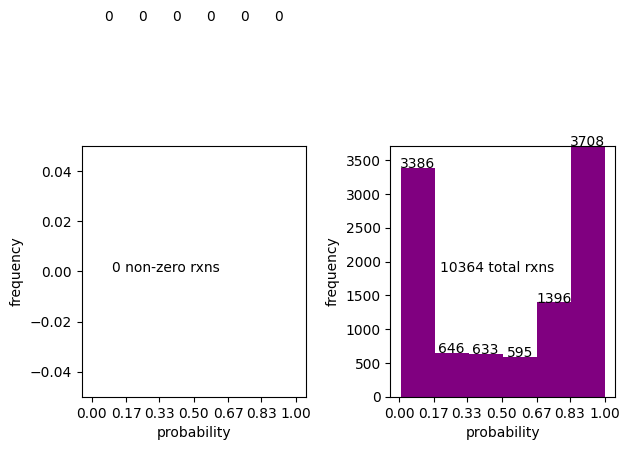

In [7]:
nonZeroFlux = {ID: flux for ID, flux in fluxes_dic.items() if flux != 0}

from matplotlib.ticker import FormatStrFormatter
from matplotlib import pyplot
fig, axs = pyplot.subplots(1, 2, tight_layout=True)
from re import sub
model_rxns = {model: [rxn.id for rxn in model.reactions] for model in megaModels}
rxnProbabilities = [round(float(model.reactions.get_by_id(sub("(\_c\d)", "_c0", rxnID)).notes["probability"]), 3)
                    for rxnID in nonZeroFlux for model, modelRxnIDs in model_rxns.items() if rxnID in modelRxnIDs]
counts1, bins1, patches1 = axs[0].hist(rxnProbabilities, bins=len(megaModels), color="green")
counts2, bins2, patches2 = axs[1].hist([round(float(rxn.notes["probability"]), 3) for model in megaModels for rxn in model.reactions],
                                        bins=len(megaModels), color="purple")

# Label each bar
for count1, bin1, patch1 in zip(counts1, bins1, patches1):
    # Center the text horizontally on the patch (bar)
    x = bin1 + patch1.get_width() / 2
    # Position the text slightly above the top of the bar
    y = patch1.get_height() + 0.1
    # Use the count as the label
    axs[0].text(x, y, str(int(count1)), ha='center')

for count2, bin2, patch2 in zip(counts2, bins2, patches2):
    # Center the text horizontally on the patch (bar)
    x = bin2 + patch2.get_width() / 2
    # Position the text slightly above the top of the bar
    y = patch2.get_height() + 0.1
    # Use the count as the label
    axs[1].text(x, y, str(int(count2)), ha='center')

# print(max(counts1), len(rxnProbabilities), max(counts2))
# axs[0].set_xlim([0, 1])  ;  axs[1].set_xlim([0, 1])
from numpy import linspace
x_axis_range = [round(x,2) for x in linspace(0, 1, num=len(megaModels)+1)]
axs[0].set_xticks(x_axis_range)  ;  axs[1].set_xticks(x_axis_range)

axs[0].set_ylim([0, max(counts1)]) ;  axs[1].set_ylim([0, max(counts2)])
axs[0].text(.1, max(counts1)/2, f"{len(rxnProbabilities)} non-zero rxns")
axs[1].text(.2, max(counts2)/2, f"{sum(map(len, model_rxns.values()))} total rxns")
axs[0].set_xlabel("probability") ; axs[1].set_xlabel("probability")
axs[0].set_ylabel("frequency")   ; axs[1].set_ylabel("frequency")
# pyplot.show()
fig.savefig("probabilities_histogram.jpg")

# locs, labels = pyplot.xticks()
# print(locs, labels)
# rounded_labels = [round(loc, 3) for loc in locs]
# pyplot.xticks(locs, rounded_labels)
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))



# from matplotlib import pyplot
# pyplot.bar(nonZeroFlux.keys(), nonZeroFlux.values())
# pyplot.xticks(rotation=90)
# pyplot.show()


In [ ]:
%run ../

constructed_model = build_from_species_models()